In [1]:
import json
import os

from plot_utils import *
from plot_main import *
from choice_analysis import *
import seaborn as sns
import scipy.stats as stats
from mne.stats import permutation_cluster_test
from dPCA import dPCA

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'

plt.rc('axes', linewidth=1)
plt.rc('xtick.major', width=2, size=8)
plt.rc('ytick.major', width=2, size=8)
plt.rc('xtick.minor', width=1, size=4)
plt.rc('ytick.minor', width=1, size=4)
plt.rc('mathtext', default='regular')


from models import HierarchicalPlasticRNN
from task import MDPRL


import random
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# %load_ext autoreload
# %autoreload 0

### Load model and run simulation on experimental reward schedule and stimuli

In [2]:
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/'
plot_save_dir = 'fp_approx'
os.chdir('/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN')

model_array_dir = [f'two_losses_{i}' for i in range(1,9)]

# model_array_dir = [f'test{i}' for i in range(1,9)]


f = open(os.path.join(exp_dir, model_array_dir[0], 'args.json'), 'r')
args = json.load(f)
print('loaded args')
# load model
# experiment timeline [0.75 fixation, 2.5 stimulus, 0.5 action presentation, 1.0 reward presentation]
# 2021 paper          [0.5          , 0.7         , 0.3                    , 0.2                   ]
# here                [0.4          , 0.8         , 0.6                    , 0.02                  ]

exp_times = {
    'fixation': 0.4,
    'stimulus_presentation': 0.8,
    'choice_presentation': 0.6,
    'total_time': 1.8,
    'dt': args['dt']}

task_mdprl = MDPRL(exp_times, args['input_type'], args['decision_space'])

input_size = {
    'feat': args['stim_dim']*args['stim_val'],
    'feat+obj': args['stim_dim']*args['stim_val']+args['stim_val']**args['stim_dim'], 
    'feat+conj+obj': args['stim_dim']*args['stim_val']+args['stim_dim']*args['stim_val']*args['stim_val']+args['stim_val']**args['stim_dim'],
}[args['input_type']]
output_size = args['stim_val']**args['stim_dim']

input_config = {
    'stim': (input_size, [0]),
    'action': (output_size, [1]),
}

#  'reward': (4, [0,1]),

output_config = {
    'action': (output_size, [1]),
    'chosen_obj': (output_size, [0]),
}

args['num_options'] = 2 if 'double' in args['task_type'] else 1

num_options = 1 if args['task_type']=='value' else 2
if args['decision_space']=='action':
    output_size = num_options
elif args['decision_space']=='good':
    output_size = args['stim_val']**args['stim_dim']
else:
    raise ValueError('Invalid decision space')
args['output_size'] = output_size


model_specs = {'input_config': input_config, 'hidden_size': args['hidden_size'], 'output_config': output_config,
                'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt_x': args['dt'], 'dt_w': exp_times['total_time'],  'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'num_areas': args['num_areas'],
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1)}

E_SIZE = round(args['hidden_size']*args['e_prop'])
I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
NUM_AREAS = args['num_areas']


all_models = []

for model_dir in model_array_dir:
    model = HierarchicalPlasticRNN(**model_specs)
#     print(model)
#     for n, p in model.named_parameters():
#         print(n, p.numel())
    state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'), 
                            map_location=torch.device('cpu'))['model_state_dict']
    print(model.load_state_dict(state_dict))
    all_models.append(model)
    print(f'model at {model_dir} loaded successfully')


loaded args
<All keys matched successfully>
model at two_losses_1 loaded successfully
<All keys matched successfully>
model at two_losses_2 loaded successfully
<All keys matched successfully>
model at two_losses_3 loaded successfully
<All keys matched successfully>
model at two_losses_4 loaded successfully
<All keys matched successfully>
model at two_losses_5 loaded successfully
<All keys matched successfully>
model at two_losses_6 loaded successfully
<All keys matched successfully>
model at two_losses_7 loaded successfully
<All keys matched successfully>
model at two_losses_8 loaded successfully


/scratch/f005d7d/ipykernel_2602013/918056159.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.ta

In [3]:
def generate_stim_sensory_mappings():
    
    dim_perms = [[0,1,2], [0,2,1],
                 [1,0,2], [1,2,0],
                 [2,0,1], [2,1,0]]
    model_assignments = np.arange(8)
    rep_per_condition = np.arange(4)
    indices_product = list(itertools.product(list(range(len(dim_perms))), model_assignments, rep_per_condition))
    
    test_stim_dim_order = []
    test_stim_dim_order_reverse = []
    
    test_stim_val_order = []
    test_stim_val_order_reverse = []
    
    test_stim2sensory_idx = []
    test_sensory2stim_idx = []
    
    all_model_assignments = []
    
    for dim_perm_idx, mdl_idx, rep_idx in indices_product:
        all_model_assignments.append(mdl_idx)
        # to test for the network's behavior without bias:
        # randomly permute correspondence between stim dim and schedule dim
        curr_stim_dim_order = dim_perms[dim_perm_idx]
        test_stim_dim_order.append(curr_stim_dim_order)
        test_stim_dim_order_reverse.append(np.argsort(curr_stim_dim_order))
        # randomly permute correspondence of feature values with stim dim
        test_stim_val_order.append([])
        test_stim_val_order_reverse.append([])
        # for each dimension, randomly permute
        for d in range(3):
            curr_dim_val_order = np.random.permutation(3)
            test_stim_val_order[-1].append(curr_dim_val_order)
            test_stim_val_order_reverse[-1].append(np.argsort(curr_dim_val_order))
        test_stim_val_order[-1] = np.stack(test_stim_val_order[-1], axis=0)
        test_stim_val_order_reverse[-1] = np.stack(test_stim_val_order_reverse[-1], axis=0)
        # using the above two permutations, permute the objects to get the 
        curr_stim2sensory_idx, curr_sensory2stim_idx = task_mdprl.stim_to_sensory(test_stim_dim_order[-1], \
                                                                                test_stim_val_order[-1])
        test_stim2sensory_idx.append(curr_stim2sensory_idx)
        test_sensory2stim_idx.append(curr_sensory2stim_idx)
        
    return all_model_assignments, \
           {"test_stim_dim_order": test_stim_dim_order, 
            "test_stim_dim_order_reverse": test_stim_dim_order_reverse, 
            "test_stim_val_order": test_stim_val_order, 
            "test_stim_val_order_reverse": test_stim_val_order_reverse,
            "test_stim2sensory_idx": test_stim2sensory_idx, 
            "test_sensory2stim_idx": test_sensory2stim_idx} 

all_model_assignments, stim_sensory_mapping_dict = generate_stim_sensory_mappings()

In [4]:
def run_model(args, model_list, task_mdprl, model_assignment, stim_sensory_mapping_dict):
    """
    Runs the provided models on the given task and collects all relevant states and outputs.

    Args:
        args (dict): Dictionary of model and task parameters.
        model_list (list): List of PyTorch models to evaluate.
        task_mdprl: Task object with methods for generating input and test stimulus order.
        n_samples (int, optional): Number of samples to run. If None, uses the number of test stimuli.

    Returns:
        dict: Dictionary containing all saved states, outputs, and metadata from the model runs.
    """
    all_saved_states = defaultdict(list)
    output_size = args['output_size']    

    for model in model_list:
        model.eval()
        for p in model.parameters():
            p.requires_grad = False # disable gradient calculation for parameters
    
    n_samples = len(model_assignment) 
    n_models = len(model_list)

    print(np.unique(model_assignment, return_counts=True))
    
    for batch_idx in tqdm.tqdm(range(n_samples)):
        model = model_list[model_assignment[batch_idx]]
        pop_s, rwd_s, _, index_s, prob_s, _ = task_mdprl.generateinput(
            batch_size=1, N_s=args['test_N_s'], num_choices=args['num_options'], 
            rwd_schedule=task_mdprl.prob_mdprl, 
            stim2sensory_idx=stim_sensory_mapping_dict['test_stim2sensory_idx'][batch_idx])
        
        # add empty list for the current episode
        all_saved_states['whs'].append([])

        all_saved_states['stimuli'].append(torch.from_numpy(np.expand_dims(index_s, axis=(1,2)))) # num trials X time_steps(1) X batch_size(1) X num_choices
        all_saved_states['reward_probs'].append(torch.from_numpy(np.expand_dims(prob_s, axis=(1,)))) # num_trials X time_steps(1) X batch_size X num_choices
        
        all_saved_states['logits'].append([])
        all_saved_states['choices'].append([])
        all_saved_states['foregone'].append([])
        all_saved_states['rewards'].append([])
        all_saved_states['choose_better'].append([])
        all_saved_states['hs'].append([])
        all_saved_states['rwd_sensitivity'].append([])
#         all_saved_states['ch_sensitivity'].append([])

        # reinitialize hidden layer activity
        hidden = None
        w_hidden = None

        for i in range(len(pop_s)):
            
            curr_trial_hs = []
            
            # first phase, give stimuli and no feedback
            all_x = {
                'stim': torch.zeros_like(pop_s[i]),
                'action': torch.zeros(1, output_size),
            }
            _, hidden, w_hidden, hs = model(all_x, steps=task_mdprl.T_fixation, neumann_order = args['neumann_order'],
                                        hidden=hidden, w_hidden=w_hidden, DAs=None, save_all_states=True)
            
            curr_trial_hs.append(hs.detach())

            # second phase, give stimuli and no feedback
            all_x = {
                'stim': pop_s[i],
                'action': torch.zeros(1, output_size),
            }
            output, hidden, w_hidden, hs = model(all_x, steps=task_mdprl.T_stim, neumann_order = args['neumann_order'],
                                        hidden=hidden, w_hidden=w_hidden, DAs=None, save_all_states=True)
            curr_trial_hs.append(hs.detach())

            if args['task_type']=='on_policy_double':
                # use output to calculate action, reward, and record loss function
                if args['decision_space']=='action':
                    raise NotImplementedError
                elif args['decision_space']=='good':
                    # action_valid = torch.argmax(output[:,index_s[i]], -1) # the object that can be chosen (0~1), (batch size, )
                    action_valid = torch.multinomial(output['action'][:,index_s[i]].softmax(-1), num_samples=1).squeeze(-1)
                    all_saved_states['logits'][-1].append(
                        (output['action'][:,index_s[i,1]]-output['action'][:,index_s[i,0]]).detach()[None,...])
                    # backpropagate from choice to previous reward
                    if i>0:
                        (output['action'][:,index_s[i,1]]-output['action'][:,index_s[i,0]]).squeeze().backward()
                        all_saved_states['rwd_sensitivity'][-1].append(DAs.grad[None])
#                         all_saved_states['ch_sensitivity'][-1].append(action_enc.grad[None])
                        DAs.grad=None
                    else:
                        all_saved_states['rwd_sensitivity'][-1].append(torch.zeros(1, 1))
#                         all_saved_states['ch_sensitivity'][-1].append(torch.zeros(1, 1, 27))
                    
                    action = index_s[i, action_valid] # (batch size, )
                    nonaction = index_s[i, 1-action_valid] # (batch size, )
                    # rwd = (torch.rand(args['batch_size'])<prob_s[i][range(args['batch_size']), action_valid]).long()
                    rwd = rwd_s[i][0, action_valid]
                    all_saved_states['choose_better'][-1].append((action_valid==torch.argmax(prob_s[i], -1)).float()[None,...]) 
                all_saved_states['rewards'][-1].append(rwd.float()[None,...])
                all_saved_states['choices'][-1].append(action[None,...])
                all_saved_states['foregone'][-1].append(nonaction[None,...])
            elif args['task_type'] == 'value':
                raise NotImplementedError
            
            if args['task_type']=='on_policy_double':
                all_x = {
                    'stim': pop_s[i],
                    'action': F.one_hot(action, num_classes=output_size).float(),
                }
                
                DAs = (2*rwd.float()-1)
                DAs = DAs.requires_grad_()
                
                hidden = hidden.detach()
                w_hidden = w_hidden.detach()

                _, hidden, w_hidden, hs = model(all_x, steps=task_mdprl.T_ch, neumann_order = args['neumann_order'],
                                                hidden=hidden, w_hidden=w_hidden, DAs=DAs, save_all_states=True)
                curr_trial_hs.append(hs.detach())

            elif args['task_type'] == 'value':
                raise NotImplementedError
            
            all_saved_states['hs'][-1].append(torch.cat(curr_trial_hs)) 
            # [num_sessions, [num_trials, [time, num_batch_size, hidden_size]]]
            all_saved_states['whs'][-1].append(w_hidden.detach()[None]) 
            # [num_sessions, [num_trials, [1, num_batch_size, hidden_size, hidden_size]]]

        # stack to create a trial dimension for each session
        for k in all_saved_states.keys():
            if isinstance(all_saved_states[k][-1], list):
                all_saved_states[k][-1] = torch.stack(all_saved_states[k][-1], axis=0)
        # [num_sessions, [num_trials, time_steps, num_batch_size, ...]]

    # concatenate all saved states along the batch dimension
    for k in all_saved_states.keys():
        all_saved_states[k] = torch.cat(all_saved_states[k], axis=2) # [num_trials, time_steps, num_sessions, ...]

    # concatenate all accuracies and rewards
    print(all_saved_states['rewards'].mean(), all_saved_states['choose_better'].mean())
    
    for k, v in all_saved_states.items():
        print(k, v.shape)
        
    all_saved_states['model_assignment'] = model_assignment
    all_saved_states['test_stim_dim_order'] = stim_sensory_mapping_dict['test_stim_dim_order']
    all_saved_states['test_stim_dim_order_reverse'] = stim_sensory_mapping_dict['test_stim_dim_order_reverse']
    all_saved_states['test_stim_val_order'] = stim_sensory_mapping_dict['test_stim_val_order']
    all_saved_states['test_stim_val_order_reverse'] = stim_sensory_mapping_dict['test_stim_val_order_reverse']
    all_saved_states['test_stim2sensory_idx'] = stim_sensory_mapping_dict['test_stim2sensory_idx']
    all_saved_states['test_sensory2stim_idx'] = stim_sensory_mapping_dict['test_sensory2stim_idx']
    
    return all_saved_states


In [5]:
# run model

import pickle

test_activities_dir = '/dartfs/rc/lab/S/SoltaniA/f005d7d/attn-rnn/test_activities'

if os.path.exists(test_activities_dir):
    print('found previous record pickle, loading previous results')
    with open(test_activities_dir, 'rb') as f:
        all_saved_states = pickle.load(f)
    print('loaded previous results')
    print(all_saved_states['rewards'].mean(), all_saved_states['choose_better'].mean())
else:
    all_saved_states = run_model(args, all_models, task_mdprl, all_model_assignments, stim_sensory_mapping_dict)
    print('simulation complete')
    with open(test_activities_dir, 'wb') as f:
        pickle.dump(all_saved_states, f)
    print(f'saved results to {test_activities_dir}')


found previous record pickle, loading previous results
loaded previous results
tensor(0.5557) tensor(0.6589)


### Learning Curve

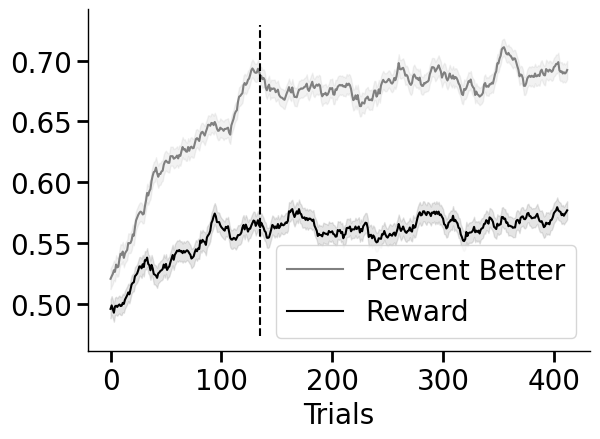

Figure saved at plots/fp_approx/learning_curve.pdf


In [6]:
plot_learning_curve(args, all_saved_states['rewards'], all_saved_states['choose_better'], plot_save_dir)

Finished calculating norm of update
Finished calculating weight norms
Finished calculating variability


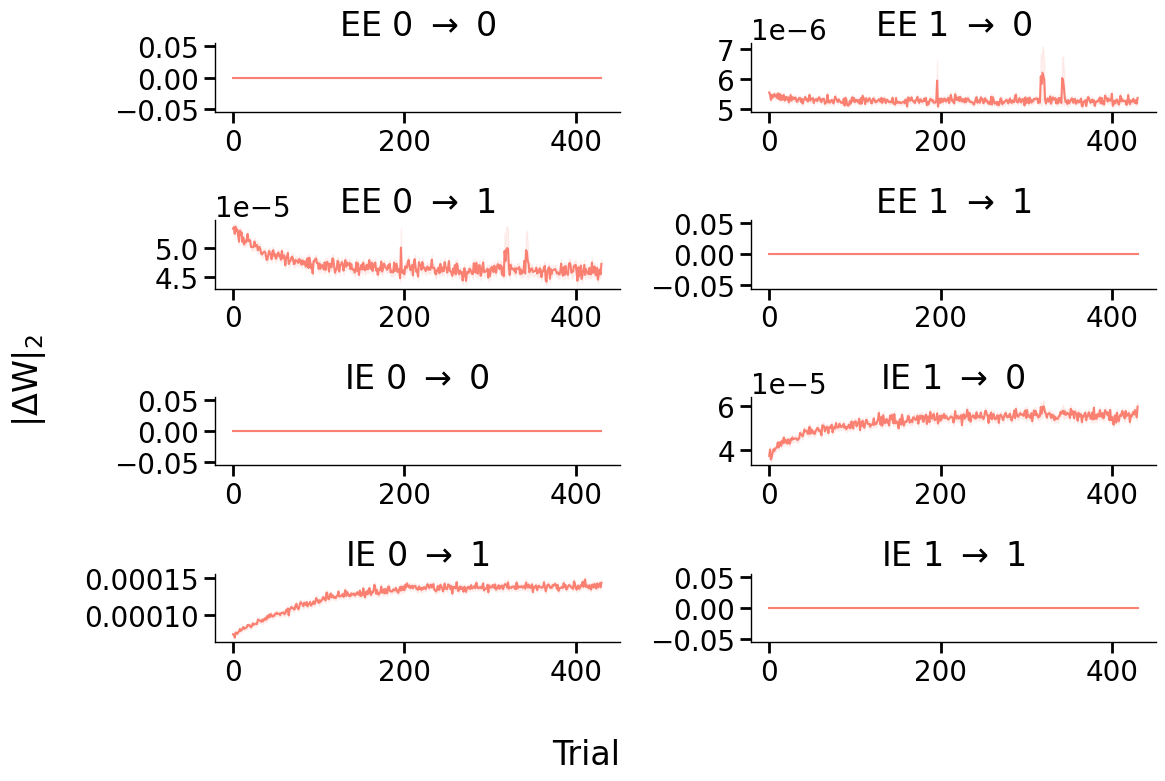

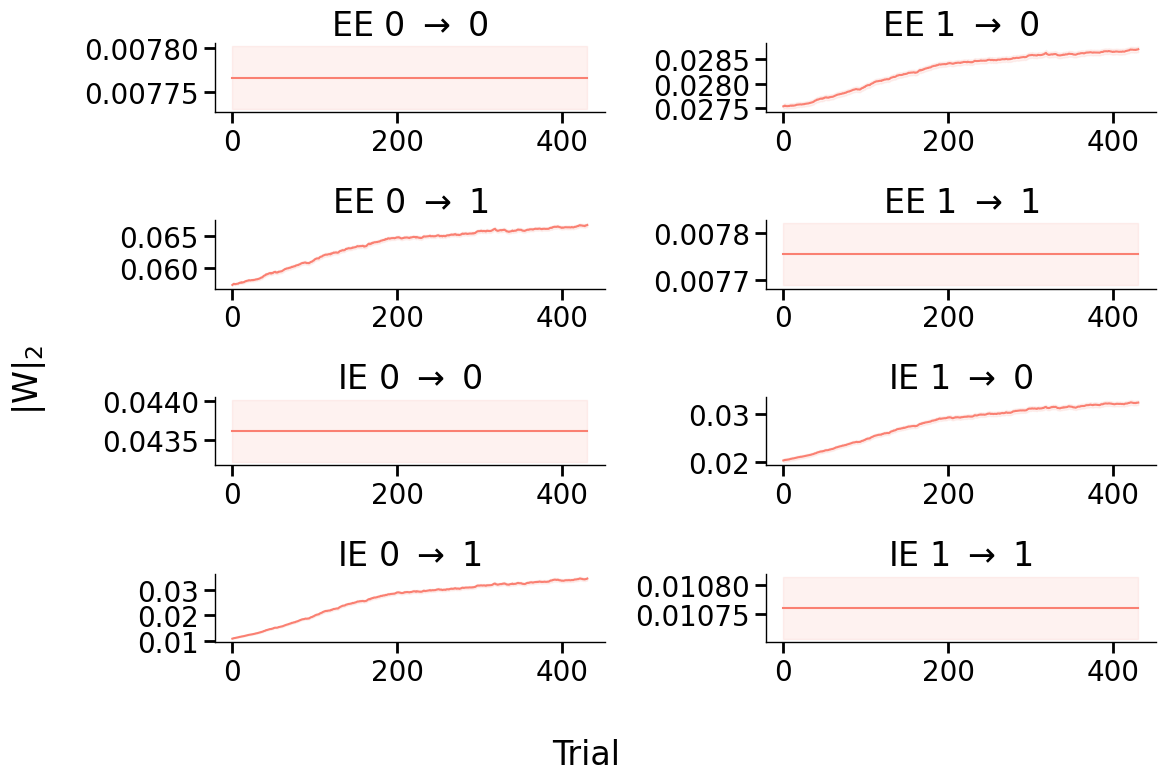

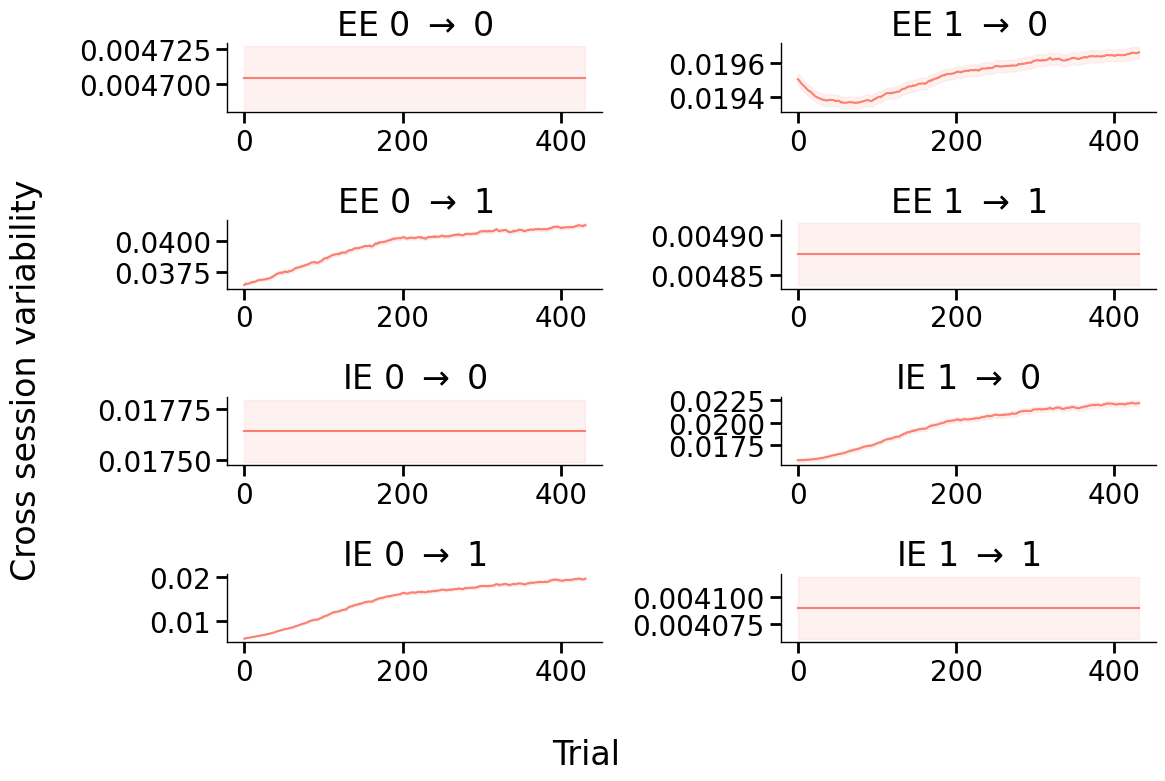

In [7]:
plot_weight_summary(args, all_saved_states['whs']*model.rnn.h2h.mask)

# Behavioral Analysis

In [6]:
def steady_state_choice_analysis(all_saved_states, task_mdprl, plot_save_dir, start_trial=216):
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(432-start_trial, num_trials)
    num_subj = all_saved_states['rewards'].shape[2]

    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        # stim in sensory space, ntrials X 2
        stims = all_saved_states['stimuli'][num_trials_to_fit,0,idx_subj,:] 
        # stim back to reward schedule space, ntrials X 2
        stims_rwd_mat = task_mdprl.permute_mapping(stims, all_saved_states['test_sensory2stim_idx'][idx_subj]) 
        pF1, pC1, pO = obj_to_value_est(stims_rwd_mat, task_mdprl) # ntrials X 2 for each
        # choices are in sensory space, map back to schedule space
        choices = all_saved_states['choices'][num_trials_to_fit,0,idx_subj]==stims[:,1]

        all_Xs.append(np.stack([np.log(pF1[:,1]/pF1[:,0]), 
                                np.log(pC1[:,1]/pC1[:,0]),
                                np.log(pO[:,1]/pO[:,0]),], axis=1))
        all_Ys.append(choices)
        
    all_Xs = np.concatenate(all_Xs, 0)
    all_Ys = np.concatenate(all_Ys, 0)[:, None]
    
    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=['pFinf', 'pCinf', 'pO', 'choice']).fillna(0)
    data_group_by_F_m = all_data.groupby('pFinf').mean().apply(np.array).loc[:,'choice']
    data_group_by_F_se = all_data.groupby('pFinf').sem().apply(np.array).loc[:,'choice']
    data_group_by_C_m = all_data.groupby('pCinf').mean().apply(np.array).loc[:,'choice']
    data_group_by_C_se = all_data.groupby('pCinf').sem().apply(np.array).loc[:,'choice']

    fig, axes = plt.subplots()
    fig.set_size_inches((6.4, 4.8))
    axes.errorbar(data_group_by_F_m.index.values, 
                 data_group_by_F_m.values, 
                 data_group_by_F_se.values,
                 c=mpl.colormaps['Blues'](180),
                 ls='', marker='o', mfc='white')
    axes.errorbar(data_group_by_C_m.index.values, 
                 data_group_by_C_m.values, 
                 data_group_by_C_se.values,
                 c=mpl.colormaps['Reds'](180),
                 ls='', marker='o', mfc='white')
    
    mdl = smf.glm('choice~pFinf+pCinf+pO', all_data, missing='drop', family=sm.families.Binomial())
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:]
    all_ses = mdlf.bse[1:]
    all_ps = mdlf.pvalues[1:]

    all_coeffs = np.stack(all_coeffs)
    all_ses = np.stack(all_ses)
    all_ps = np.stack(all_ps)

    var_names = [r'$F_{I}$', r'$C_{I}$', 'O']
    
    xs = np.linspace(-1.4, 1.4, 100)
    
    axes.plot(xs, 1/(1+np.exp(-all_coeffs[0]*xs)), color=mpl.colormaps['Blues'](180), label=r'$F_{I}$')
    axes.plot(xs, 1/(1+np.exp(-all_coeffs[1]*xs)), color=mpl.colormaps['Reds'](180), label=r'$C_{I}$')
    axes.legend()
    
    axin = axes.inset_axes([0.65, 0.15, 0.3, 0.3])
    axin.bar(np.arange(1, len(var_names)+1), all_coeffs, 
             color=[mpl.colormaps['Blues'](180), mpl.colormaps['Reds'](180), mpl.colormaps['Purples'](180)])
    axin.errorbar(np.arange(1, len(var_names)+1), all_coeffs, all_ses, linestyle="", color='k')
    axin.text(1, all_coeffs[0]+all_ses[0]+0.05, convert_pvalue_to_asterisks(all_ps[0]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.text(2, all_coeffs[1]+all_ses[1]+0.05, convert_pvalue_to_asterisks(all_ps[1]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.text(3, all_coeffs[2]+np.sign(all_coeffs[2])*(all_ses[2]+0.05), convert_pvalue_to_asterisks(all_ps[2]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.set_xticks(range(1,4), labels=var_names, fontsize=12)
    axin.set_yticks(range(0,3), labels=range(0,3), fontsize=12)
    axin.set_ylim(np.array(axin.get_ylim())*1.2)
    axin.set_ylabel('Slopes', fontsize=16)
    axes.set_xlabel('Log odd of reward')
    axes.set_ylabel('Choice probability')
    plt.tight_layout()
    sns.despine()
    sns.despine(ax=axin)
    plt.savefig(os.path.join('plots/', plot_save_dir, "choice_curves_slopes.pdf"))
    print(f'Figure saved at plots/{plot_save_dir}/choice_curves_slopes.pdf')
    plt.show()
    plt.close()
    return


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                41472
Model:                            GLM   Df Residuals:                    41468
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24050.
Date:                Thu, 13 Nov 2025   Deviance:                       48100.
Time:                        01:15:22   Pearson chi2:                 4.15e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2025
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0194      0.011     -1.760      0.0

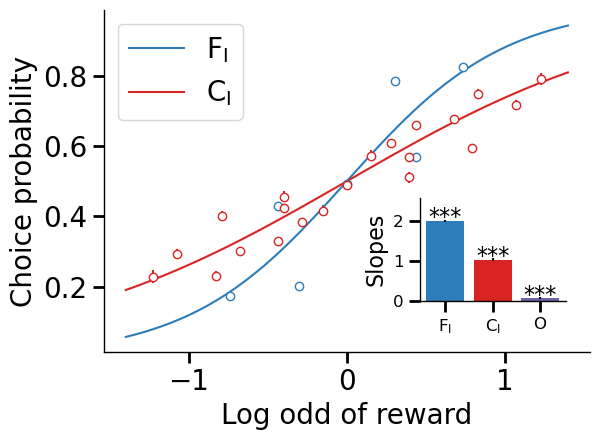

In [7]:
steady_state_choice_analysis(all_saved_states, task_mdprl, plot_save_dir)

In [8]:
def credit_assignment(all_saved_states, task_mdprl, plot_save_dir, end_trial=432):
    # find chosen feedback, unchosen feedback
    # stimuli torch.Size([432, 1, 92, 2])
    # reward_probs torch.Size([432, 1, 92, 2])
    # choices torch.Size([432, 1, 92])
    # rewards torch.Size([432, 1, 92])
    # choose_better torch.Size([432, 1, 92])
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(0, end_trial-1)
    num_subj = all_saved_states['rewards'].shape[2]
    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        
        stims_post_perceptual = all_saved_states['stimuli'][num_trials_to_fit+1,0,idx_subj,:] # ntrials X 2
        stims_post = task_mdprl.permute_mapping(stims_post_perceptual, all_saved_states['test_sensory2stim_idx'][idx_subj]) 
        stims_pre_chosen_perceptual = all_saved_states['choices'][num_trials_to_fit,0,idx_subj] # ntrials
        stims_pre_chosen = task_mdprl.permute_mapping(stims_pre_chosen_perceptual, all_saved_states['test_sensory2stim_idx'][idx_subj]) 
        choices = all_saved_states['choices'][num_trials_to_fit+1,0,idx_subj]
        choices = task_mdprl.permute_mapping(choices, all_saved_states['test_sensory2stim_idx'][idx_subj]) 
        choices = choices==stims_post[:,1]
        rwd_pre = 2*all_saved_states['rewards'][num_trials_to_fit,0,idx_subj]-1 # ntrials
        
        stimsFCO_pre_chosen = obj_to_ft_conj(stims_pre_chosen, task_mdprl) # ntrials X 7
        stimsFCO_post = obj_to_ft_conj(stims_post, task_mdprl) # ntrials X 2 X 7
        
        # predictors are inf dim R chosen, inf dim C chosen, noninf dim R chosen, noninf dim C chosen, 
        subj_Xs = np.concatenate([rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:]),\
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:])], axis=-1)
        
        all_Xs.append(subj_Xs)
        all_Ys.append(choices)

    all_Xs = np.concatenate(all_Xs, axis=0)
    all_Ys = np.concatenate(all_Ys, axis=0)[:,None]
    
    var_names = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']

    rw_ch = ['R', 'C']

    all_var_names = ['_'.join([s, 'R']) for s in var_names] + ['_'.join([s, 'C']) for s in var_names]

    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=[*all_var_names, 'choice'])

    mdl = smf.glm('choice~'+'+'.join(all_var_names), data=all_data, family=sm.families.Binomial())
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:].to_numpy()
    all_ses = mdlf.bse[1:].to_numpy()
    all_ps = mdlf.pvalues[1:].to_numpy()

    all_xlabels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4.8))
    
    
    
    bar_rw = axes[0].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[:len(var_names)], \
                yerr=all_ses[:len(var_names)], \
                color=np.concatenate([mpl.colormaps['Blues']([180, 100, 50]), 
                       mpl.colormaps['Reds']([180, 100, 50]), 
                       mpl.colormaps['Purples']([180])]), 
                capsize=5)
    bar_ch = axes[1].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[len(var_names):], \
                yerr=all_ses[len(var_names):], \
                color=np.concatenate([mpl.colormaps['Blues']([180, 100, 50]), 
                       mpl.colormaps['Reds']([180, 100, 50]), 
                       mpl.colormaps['Purples']([180])]), 
                capsize=5)
    axes[0].set_ylabel('Regression weights')
    axes[0].set_xlabel('Win-stay lose-switch')
    axes[1].set_xlabel('Choice autocorrelation')
    axes[0].set_ylim(np.array(axes[0].get_ylim())*1.1)
    axes[1].set_ylim(np.array(axes[1].get_ylim())*1.1)
    axes[0].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    axes[1].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    for i in range(len(var_names)):
        axes[0].text(i+1, all_coeffs[i]+np.sign(all_coeffs[i])*(all_ses[i]+0.03), 
                     convert_pvalue_to_asterisks(all_ps[i]), 
                     verticalalignment='center', horizontalalignment='center')

    for i in range(len(var_names)):
        axes[1].text(i+1, all_coeffs[i+len(var_names)]+np.sign(all_coeffs[i+len(var_names)])*(all_ses[i+len(var_names)]+0.05)-0.01, 
                     convert_pvalue_to_asterisks(all_ps[i+len(var_names)]), 
                     verticalalignment='center', horizontalalignment='center')
    plt.tight_layout()
    sns.despine()
    with PdfPages(f'plots/{plot_save_dir}/credit_assignment.pdf') as pdf:
        pdf.savefig(fig)
        print(f'Figure saved at plots/{plot_save_dir}/credit_assignment.pdf')
    plt.show()
    plt.close()
    return


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                82752
Model:                            GLM   Df Residuals:                    82737
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -56478.
Date:                Thu, 13 Nov 2025   Deviance:                   1.1296e+05
Time:                        01:15:24   Pearson chi2:                 8.28e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02101
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0122      0.007     -1.737      0.0

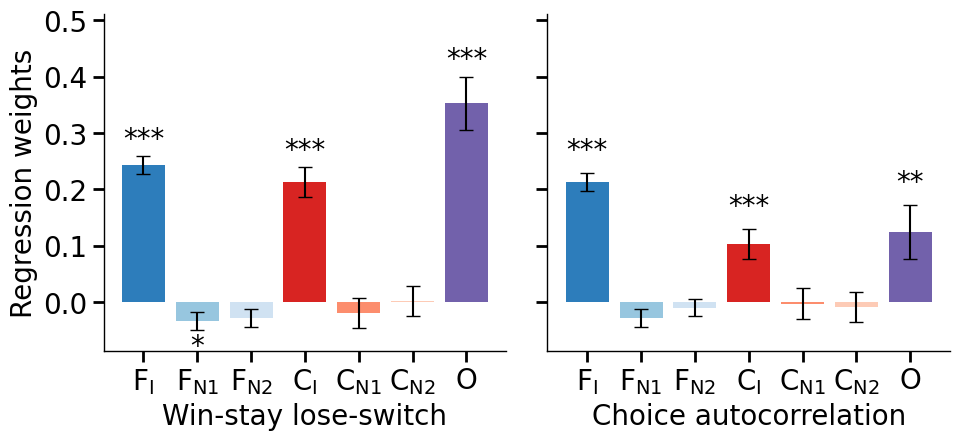

In [9]:
credit_assignment(all_saved_states, task_mdprl, plot_save_dir)

In [10]:
def credit_assignment_by_block(all_saved_states, task_mdprl, plot_save_dir, end_trial=432):
    # find chosen feedback, unchosen feedback
    # run logistic regression separately for each run (92 runs total)
    # do not permute features - work directly with perceptual stimuli without permute_mapping
    # stimuli torch.Size([432, 1, 92, 2])
    # reward_probs torch.Size([432, 1, 92, 2])
    # choices torch.Size([432, 1, 92])
    # rewards torch.Size([432, 1, 92])
    # choose_better torch.Size([432, 1, 92])
    num_trials = all_saved_states['rewards'].shape[0]
    num_subj = all_saved_states['rewards'].shape[2]
    
    num_trials_to_fit = np.arange(0, end_trial-1)
    
    var_names = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    all_var_names = ['_'.join([s, 'R']) for s in var_names] + ['_'.join([s, 'C']) for s in var_names]
    all_xlabels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']
    
    # Store results for each run
    all_run_coeffs = []
    all_run_ses = []
    all_run_ps = []
    all_run_models = []
    valid_run_indices = []
    
    # Process each run separately
    for idx_subj in range(num_subj):
        
        # Work directly with perceptual stimuli - do not use permute_mapping
        stims_post_perceptual = all_saved_states['stimuli'][num_trials_to_fit+1,0,idx_subj,:] # ntrials X 2
        stims_pre_chosen_perceptual = all_saved_states['choices'][num_trials_to_fit,0,idx_subj] # ntrials
        choices_perceptual = all_saved_states['choices'][num_trials_to_fit+1,0,idx_subj]
        choices = choices_perceptual==stims_post_perceptual[:,1]
        logits = all_saved_states['logits'][num_trials_to_fit+1,0,idx_subj]
        rwd_pre = 2*all_saved_states['rewards'][num_trials_to_fit,0,idx_subj]-1 # ntrials
        
        # Convert to reward schedule space for feature identification (but don't permute/shuffle features)
        # stims_post = task_mdprl.permute_mapping(stims_post_perceptual, all_saved_states['test_sensory2stim_idx'][idx_subj]) 
        stims_post = stims_post_perceptual
        # stims_pre_chosen = task_mdprl.permute_mapping(stims_pre_chosen_perceptual, all_saved_states['test_sensory2stim_idx'][idx_subj]) 
        stims_pre_chosen = stims_pre_chosen_perceptual
        
        stimsFCO_pre_chosen = obj_to_ft_conj(stims_pre_chosen, task_mdprl) # ntrials X 7
        stimsFCO_post = obj_to_ft_conj(stims_post, task_mdprl) # ntrials X 2 X 7
        
        # predictors are inf dim R chosen, inf dim C chosen, noninf dim R chosen, noninf dim C chosen, 
        subj_Xs = np.concatenate([rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:]),\
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:])], axis=-1)
        
#         plt.imshow(np.corrcoef(subj_Xs.T))
#         plt.colorbar()
#         plt.show()
        
        # Create dataframe for this run
        run_data = pd.DataFrame(np.concatenate([subj_Xs, logits[:,None]], axis=1), 
                               columns=[*all_var_names, 'choice'])
        
                
        # Run logistic regression for this run
#         mdl = smf.glm('choice~'+'+'.join(all_var_names), data=run_data, family=sm.families.Binomial())
        mdl = smf.ols('choice~'+'+'.join(all_var_names), data=run_data)
        mdlf = mdl.fit()
        
        all_run_models.append(mdlf)
        all_run_coeffs.append(mdlf.params[1:].to_numpy())
        # all_run_ses.append(mdlf.bse[1:].to_numpy())
    
    # Convert to arrays for easier manipulation
    all_run_coeffs = np.stack(all_run_coeffs)  # n_runs x n_features
    # all_run_ses = np.stack(all_run_ses)  # n_runs x n_features

    return all_run_coeffs


In [11]:
all_run_coeffs = credit_assignment_by_block(all_saved_states, task_mdprl, plot_save_dir)

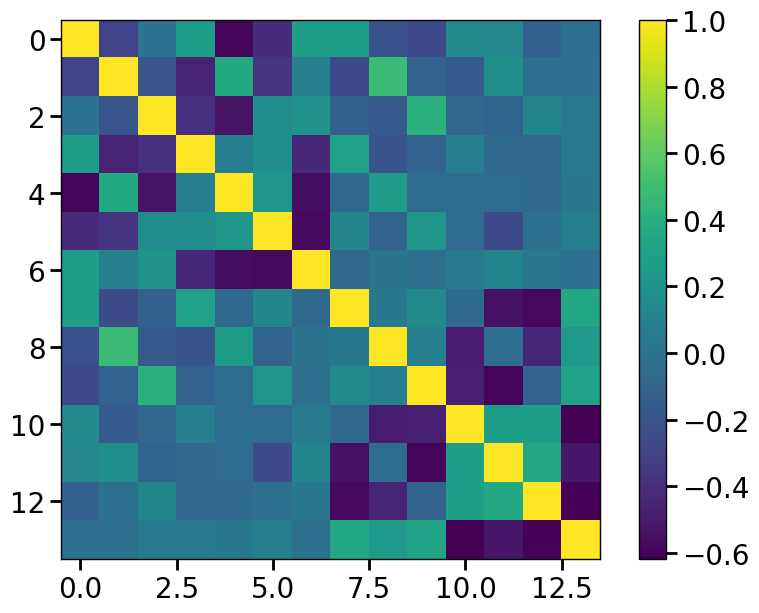

In [12]:
plt.imshow(np.corrcoef(all_run_coeffs.T))
plt.colorbar()

In [762]:
def steady_state_choice_logit_analysis(all_saved_states, task_mdprl, plot_save_dir, start_trial=432//2):
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(432-start_trial, num_trials)
    num_subj = all_saved_states['rewards'].shape[2]

    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        # stim in sensory space, ntrials X 2
        stims = all_saved_states['stimuli'][num_trials_to_fit,0,idx_subj,:] 
        # stim back to reward schedule space, ntrials X 2
        stims_rwd_mat = task_mdprl.permute_mapping(stims, all_saved_states['test_sensory2stim_idx'][idx_subj]) 
        pF1, pC1, pO = obj_to_value_est(stims_rwd_mat, task_mdprl) # ntrials X 2 for each
        # choices are in sensory space, map back to schedule space
        logits = all_saved_states['logits'][num_trials_to_fit,0,idx_subj]

        all_Xs.append(np.stack([np.log(pF1[:,1]/pF1[:,0]), 
                                np.log(pC1[:,1]/pC1[:,0]),
                                np.log(pO[:,1]/pO[:,0]),
                                np.ones_like(logits)*idx_subj], axis=1))
        all_Ys.append(logits)
        
    all_Xs = np.concatenate(all_Xs, 0)
    all_Ys = np.concatenate(all_Ys, 0)[:, None]
    
    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=['pFinf', 'pCinf', 'pO', 'idx_subj', 'logits']).fillna(0)

    fig, axes = plt.subplots(figsize=(7,5))
    
    sns.stripplot(data=all_data, x='pFinf', y='logits', jitter=True, native_scale=True,
                  color=mpl.colormaps['tab10']([0]), alpha=0.02)
    sns.stripplot(data=all_data, x='pCinf', y='logits', jitter=True, native_scale=True,
                  color=mpl.colormaps['tab10']([3]), alpha=0.02)

    mdl = smf.mixedlm('logits~pFinf+pCinf+pO', all_data, missing='drop', groups=all_data['idx_subj'],
                      re_formula='~pFinf+pCinf+pO')
    free = sm.regression.mixed_linear_model.MixedLMParams.from_components(np.ones(4), np.eye(4))
    
    mdlf = mdl.fit(free=free, method=['lbfgs'])
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:]
    all_ses = mdlf.bse[1:]
    all_ps = mdlf.pvalues[1:]

    all_coeffs = np.stack(all_coeffs)
    all_ses = np.stack(all_ses)
    all_ps = np.stack(all_ps)

    var_names = [r'$F_{I}$', r'$C_{I}$', 'O']
    
    xs = np.linspace(-1.5, 1.5, 100)
    
    axes.plot(xs, all_coeffs[0]*xs, color=mpl.colormaps['tab10']([0]), label=r'$F_{I}$')
    axes.plot(xs, all_coeffs[1]*xs, color=mpl.colormaps['tab10']([3]), label=r'$C_{I}$')
    axes.legend()
    axes.set_ylim(np.array(axes.get_ylim())+[0, 2])
    axes.set_xlim([-1.6, 1.6])
    
    axes.text(axes.get_xlim()[1], all_coeffs[0], convert_pvalue_to_asterisks(all_ps[0]), 
              verticalalignment='center', horizontalalignment='left', fontsize=16,
              color=mpl.colormaps['tab10'](0))
    axes.text(axes.get_xlim()[1], all_coeffs[1], convert_pvalue_to_asterisks(all_ps[1]), 
              verticalalignment='center', horizontalalignment='left', fontsize=16,
              color=mpl.colormaps['tab10'](3))

    
    axes.set_xlabel('Log odd of reward')
    axes.set_ylabel('Choice logits')
    plt.tight_layout()
    sns.despine()
    plt.savefig(os.path.join('plots/', plot_save_dir, "choice_logit_curves_slopes.pdf"))
    print(f'Figure saved at plots/{plot_save_dir}/choice_logit_curves_slopes.pdf')
    plt.show()
    plt.close()
    return mdlf


/dartfs-hpc/rc/home/d/f005d7d/.conda/envs/attn-rnn/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  logits     
No. Observations:  41472    Method:              REML       
No. Groups:        192      Scale:               6.5159     
Min. group size:   216      Log-Likelihood:      -98086.1712
Max. group size:   216      Converged:           Yes        
Mean group size:   216.0                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.000    0.013  0.025 0.980 -0.024  0.025
pFinf              4.212    0.094 44.870 0.000  4.028  4.396
pCinf              2.453    0.054 45.174 0.000  2.347  2.560
pO                -0.126    0.019 -6.724 0.000 -0.163 -0.089
Group Var          0.000    0.001                           
Group x pFinf Cov  0.000    0.000                           
pFinf Var          1.390    0.063   

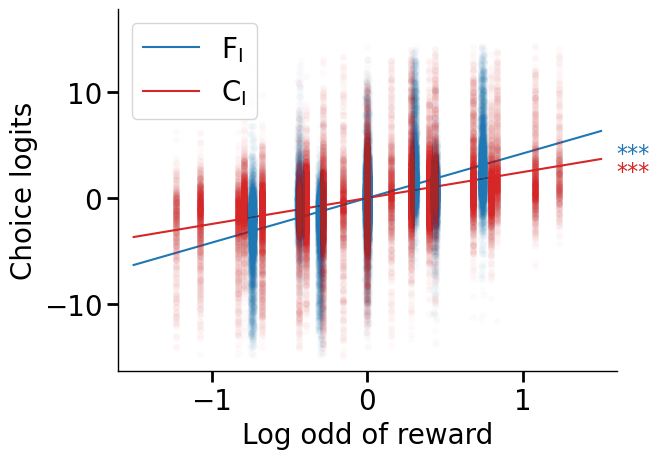

In [763]:
choice_curve_logit_mdl = steady_state_choice_logit_analysis(all_saved_states, task_mdprl, plot_save_dir)

In [765]:
def credit_assignment_logit(all_saved_states, task_mdprl, plot_save_dir, end_trial=432//2):
    # find chosen feedback, unchosen feedback
    # stimuli torch.Size([432, 1, 92, 2])
    # reward_probs torch.Size([432, 1, 92, 2])
    # choices torch.Size([432, 1, 92])
    # rewards torch.Size([432, 1, 92])
    # choose_better torch.Size([432, 1, 92])
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(0, end_trial-1)
    num_subj = all_saved_states['rewards'].shape[2]
    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        
        stims_post_perceptual = all_saved_states['stimuli'][num_trials_to_fit+1,0,idx_subj,:] # ntrials X 2
        stims_post = task_mdprl.permute_mapping(stims_post_perceptual, all_saved_states['test_sensory2stim_idx'][idx_subj]) 
        stims_pre_chosen_perceptual = all_saved_states['choices'][num_trials_to_fit,0,idx_subj] # ntrials
        stims_pre_chosen = task_mdprl.permute_mapping(stims_pre_chosen_perceptual, all_saved_states['test_sensory2stim_idx'][idx_subj]) 
        logits = all_saved_states['logits'][num_trials_to_fit+1,0,idx_subj]
        rwd_pre = 2*all_saved_states['rewards'][num_trials_to_fit,0,idx_subj]-1 # ntrials
        
        stimsFCO_pre_chosen = obj_to_ft_conj(stims_pre_chosen, task_mdprl) # ntrials X 7
        stimsFCO_post = obj_to_ft_conj(stims_post, task_mdprl) # ntrials X 2 X 7
        
        
        # predictors are inf dim R chosen, inf dim C chosen, noninf dim R chosen, noninf dim C chosen, 
        subj_Xs = np.concatenate([rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:]),\
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:]),
                                  np.ones_like(logits)[:,None]*idx_subj], axis=-1)
        
        all_Xs.append(subj_Xs)
        all_Ys.append(logits)

    all_Xs = np.concatenate(all_Xs, axis=0)
    all_Ys = np.concatenate(all_Ys, axis=0)[:,None]
    
    var_names = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    rw_ch = ['R', 'C']

    all_var_names = ['_'.join([s, 'R']) for s in var_names] + ['_'.join([s, 'C']) for s in var_names]

    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=[*all_var_names, 'idx_subj', 'logits'])

    mdl = smf.mixedlm('logits~'+'+'.join(all_var_names), data=all_data, groups=all_data['idx_subj'],
                     re_formula='~'+'+'.join(all_var_names))
    free = sm.regression.mixed_linear_model.MixedLMParams.from_components(np.ones(15), np.eye(15))
    
    mdlf = mdl.fit(free=free, method=['lbfgs'])
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:15].to_numpy()
    all_ses = mdlf.bse[1:15].to_numpy()
    all_ps = mdlf.pvalues[1:15].to_numpy()

    all_xlabels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']

    fig, axes = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches((10, 5))
    
    bar_rw = axes[0].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[:len(var_names)], \
                yerr=all_ses[:len(var_names)], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)
    bar_ch = axes[1].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[len(var_names):], \
                yerr=all_ses[len(var_names):], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)
    axes[0].set_ylabel('Regression weights')
    axes[0].set_ylim(np.array(axes[0].get_ylim())*1.1)
    axes[1].set_ylim(np.array(axes[1].get_ylim())*1.1)
    axes[0].set_xlabel('Win-stay lose-switch')
    axes[1].set_xlabel('Choice autocorrelation')
    axes[0].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    axes[1].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    for i in range(len(var_names)):
        axes[0].text(i+1, all_coeffs[i]+np.sign(all_coeffs[i])*(all_ses[i]+0.05)-0.01, 
                     convert_pvalue_to_asterisks(all_ps[i]), 
                     verticalalignment='center', horizontalalignment='center')

    for i in range(len(var_names)):
        axes[1].text(i+1, all_coeffs[i+len(var_names)]+np.sign(all_coeffs[i+len(var_names)])*(all_ses[i+len(var_names)]+0.05)-0.01, 
                     convert_pvalue_to_asterisks(all_ps[i+len(var_names)]), 
                     verticalalignment='center', horizontalalignment='center')
    plt.tight_layout()
    sns.despine()
    with PdfPages(f'plots/{plot_save_dir}/credit_assignment_logit.pdf') as pdf:
        pdf.savefig(fig)
        print(f'Figure saved at plots/{plot_save_dir}/credit_assignment_logit.pdf')
    plt.show()
    plt.close()
        
    return mdlf

/dartfs-hpc/rc/home/d/f005d7d/.conda/envs/attn-rnn/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/dartfs-hpc/rc/home/d/f005d7d/.conda/envs/attn-rnn/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/dartfs-hpc/rc/home/d/f005d7d/.conda/envs/attn-rnn/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1236.024776
  warnings.warn(msg, ConvergenceWarning)
/dartfs-hpc/rc/home/d/f005d7d/.conda/envs/attn-rnn/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, Converge

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: logits     
No. Observations:   41280   Method:             REML       
No. Groups:         192     Scale:              4.2495     
Min. group size:    215     Log-Likelihood:     -90920.2446
Max. group size:    215     Converged:          No         
Mean group size:    215.0                                  
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.008    0.066  0.115 0.908 -0.121  0.136
F0_R              0.389    0.059  6.547 0.000  0.273  0.506
F1_R             -0.050    0.062 -0.807 0.420 -0.171  0.071
F2_R             -0.055    0.061 -0.899 0.369 -0.176  0.065
C0_R              0.404    0.055  7.315 0.000  0.296  0.513
C1_R             -0.019    0.056 -0.345 0.730 -0.129  0.091
C2_R             -0.014    0.056 -0.247 0.805 -0.12

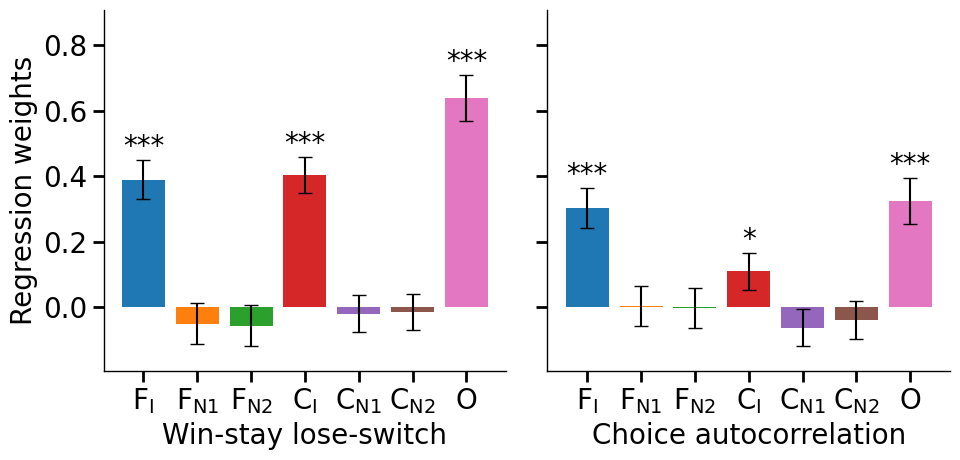

In [766]:
credit_assignment_logit_mdl = credit_assignment_logit(all_saved_states, task_mdprl, plot_save_dir)
sess_ca_weights = credit_assignment_logit_mdl.params[:15].values+np.stack([credit_assignment_logit_mdl.random_effects[i].values for i in range(92)])


# Extract weights and learning rates

In [13]:
def get_weights_by_area(all_models, args):
    all_model_rec_intra = []
    all_model_rec_inter_ff = []
    all_model_rec_inter_fb = []

    for model in all_models:
        h2h = model.rnn.h2h.effective_weight().detach()

        rec_intra = []
        for i in range(args['num_areas']):
            rec_intra.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                            [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        
        all_model_rec_intra.append(rec_intra)

        rec_inter_ff = []
        rec_inter_fb = []

        for i in range(args['num_areas']-1):
            rec_inter_ff.append(h2h[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                    list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                                [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                    list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
            rec_inter_fb.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                    list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                                [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                    list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
            
        all_model_rec_inter_ff.append(rec_inter_ff)
        all_model_rec_inter_fb.append(rec_inter_fb)

    return all_model_rec_intra, all_model_rec_inter_ff, all_model_rec_inter_fb


def get_lrs_by_area(all_models, args):
    all_model_kappa_rec_intra = []
    all_model_kappa_inter_ff = []
    all_model_kappa_inter_fb = []

    for model in all_models:

        kappa_rec = model.plasticity.effective_lr().detach()

        kappa_rec_intra = []
        for i in range(args['num_areas']):
            kappa_rec_intra.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                    list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                                    [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                        list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])

        all_model_kappa_rec_intra.append(kappa_rec_intra)
        
        
        kappa_inter_ff = []
        kappa_inter_fb = []

        for i in range(args['num_areas']-1):
            kappa_inter_ff.append(kappa_rec[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                        list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                                    [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                        list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
            kappa_inter_fb.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                        list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                                        [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                        list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
            
        all_model_kappa_inter_ff.append(kappa_inter_ff)
        all_model_kappa_inter_fb.append(kappa_inter_fb)

    return all_model_kappa_rec_intra, all_model_kappa_inter_ff, all_model_kappa_inter_fb



In [14]:
all_model_rec_intra, all_model_rec_inter_ff, all_model_rec_inter_fb = get_weights_by_area(all_models, args)
all_model_kappa_rec_intra, all_model_kappa_inter_ff, all_model_kappa_inter_fb = get_lrs_by_area(all_models, args)

# Subspace Analysis


### Decompose each input, output, and choice pattern as a sum of feature, conjunction, and object patterns
$I_{i} = I_{ft}(i)+I_{conj}(i)+I_{obj}(i)$

In [15]:
def get_dpca_results_by_weights(all_model_weights, n_components_for_dpca):

    dpca_results = defaultdict(list)

    for model_idx, model_weights in enumerate(all_model_weights):
        dpca_mdl = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
        low_hs = dpca_mdl.fit_transform(model_weights.reshape((-1,3,3,3)))

        dpca_results['low_hs'].append(low_hs)
        dpca_results['encoding_axes'].append(dpca_mdl.P)
        dpca_results['unitwise_explained_var'].append(dpca_mdl.unitwise_explained_variance_ratio_)
        dpca_results['total_explained_var'].append(dpca_mdl.explained_variance_ratio_)
        dpca_results['marginalized_psth'].append(dpca_mdl.marginalized_psth)

    dpca_results = dict(dpca_results)

    return dpca_results

def align_dpca_axes(all_model_dpca_to_align, all_model_dpca_target, n_components_for_dpca, args):
    # use the procrustes alignment to calculate the transformation matrix across low_hs
    # use the transformation matrix to align the encoding axes
    # full_matrix (num) = low_hs_orig [num_obj, num_components] @ encoding_axes_orig [num_components, num_units]
    #                   = (low_hs_target [num_obj, num_components] @ R [num_components, num_components]) @ encoding_axes_orig [num_components, num_units]
    #                   = low_hs_target [num_obj, num_components] @ (R [num_components, num_components] @ encoding_axes_orig [num_components, num_units])
    # so the new encoding_axes = R @ encoding_axes_orig, where R is the transformation matrix such that low_hs_target @ R = low_hs_orig

    all_model_dpca_to_align['original_encoding_axes'] = all_model_dpca_to_align['encoding_axes']
    # calculate the transformation matrix
    for mdl_idx in range(len(all_model_dpca_to_align['low_hs'])):
        for k_name in n_components_for_dpca.keys():
            low_hs_to_align = all_model_dpca_to_align['low_hs'][mdl_idx][k_name]
            low_hs_to_align = low_hs_to_align.reshape((n_components_for_dpca[k_name],-1)) # (num_dims, 27)

            low_hs_target = all_model_dpca_target['low_hs'][mdl_idx][k_name]
            low_hs_target = low_hs_target.reshape((n_components_for_dpca[k_name],-1)) # (num_dims, 27)

            # calculate the transformation matrix ensured to have determinant 1
            u, _, vh = np.linalg.svd(low_hs_target@low_hs_to_align.T)
            transformation_matrix = u@vh

            all_model_dpca_to_align['encoding_axes'][mdl_idx][k_name] = \
                (transformation_matrix@all_model_dpca_to_align['encoding_axes'][mdl_idx][k_name].T).T
    


def get_all_dpca_results(all_models, task_mdprl, n_components_for_dpca, args):
    all_model_stims_in = []
    all_model_choice_out = []
    all_model_choice_in = []
    all_model_stim_out = []

    # run the dpca for input and output weights from each area
    for model in all_models:
        stim_in = model.rnn.x2h['stim'].effective_weight()[input_weight_inds].detach().numpy().copy()@task_mdprl.stim_encoding('all_onehot').T
        all_model_stims_in.append(stim_in.reshape((args['hidden_size'],3,3,3)))

        choice_out = model.h2o['action'].effective_weight().detach().numpy().copy()[:,output_weight_inds]
        all_model_choice_out.append(choice_out.T.reshape((args['hidden_size'],3,3,3)))

        choice_in = model.rnn.x2h['action'].effective_weight().detach().numpy().copy()[output_weight_inds,:]
        all_model_choice_in.append(choice_in.reshape((args['hidden_size'],3,3,3)))
        
        stim_out = model.h2o['chosen_obj'].effective_weight().detach().numpy().copy()[:,input_weight_inds]
        all_model_stim_out.append(stim_out.T.reshape((args['hidden_size'],3,3,3)))

    all_model_dpca_stim_in = get_dpca_results_by_weights(all_model_stims_in, n_components_for_dpca)
    all_model_dpca_choice_out = get_dpca_results_by_weights(all_model_choice_out, n_components_for_dpca)
    all_model_dpca_choice_in = get_dpca_results_by_weights(all_model_choice_in, n_components_for_dpca)
    all_model_dpca_stim_out = get_dpca_results_by_weights(all_model_stim_out, n_components_for_dpca)

    # all_model_dpca_stim_in_exc = get_dpca_results_by_weights(all_model_stims_in[:E_SIZE], n_components_for_dpca)
    # all_model_dpca_stim_in_inh = get_dpca_results_by_weights(all_model_stims_in[E_SIZE:], n_components_for_dpca)
    # all_model_dpca_choice_in_exc = get_dpca_results_by_weights(all_model_choice_in[:E_SIZE], n_components_for_dpca)
    # all_model_dpca_choice_in_inh = get_dpca_results_by_weights(all_model_choice_in[E_SIZE:], n_components_for_dpca)

    # align the encoding axes across weights and areas by using the stimulus input as reference
    # this makes each encoding axes the same for all models
    align_dpca_axes(all_model_dpca_stim_out, all_model_dpca_stim_in, n_components_for_dpca, args)
    align_dpca_axes(all_model_dpca_choice_out, all_model_dpca_stim_in, n_components_for_dpca, args)
    align_dpca_axes(all_model_dpca_choice_in, all_model_dpca_stim_in, n_components_for_dpca, args)

    return all_model_dpca_stim_in, all_model_dpca_choice_out, all_model_dpca_choice_in, all_model_dpca_stim_out
    


In [16]:
n_components_for_dpca = {'s':2, 'p':2, 'c':2, 'sc':4, 'sp':4, 'pc':4, 'spc': 8}
dim_labels = [r'$F_1$', r'$F_2$', r'$F_3$', r'$C_1$', r'$C_2$', r'$C_3$', r'$O$']

input_weight_inds = list(range(E_SIZE)) + list(range(E_SIZE*args['num_areas'], E_SIZE*args['num_areas']+I_SIZE))
output_weight_inds = list(range(E_SIZE, 2*E_SIZE)) + list(range(E_SIZE*args['num_areas']+I_SIZE, E_SIZE*args['num_areas']+2*I_SIZE))


all_model_dpca_stim_in, all_model_dpca_choice_out, all_model_dpca_choice_in, all_model_dpca_stim_out = \
    get_all_dpca_results(all_models, task_mdprl, n_components_for_dpca, args)

/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:984: RuntimeWarning: invalid value encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]


# Clustering Analysis

In [81]:
def plot_selectivity_clusters(all_dpca_results, keys, ideal_centroids, E_SIZE, I_SIZE, label, axes):
    
    num_models = len(all_dpca_results[0]['unitwise_explained_var'])
    all_mdl_exp_vars = []

    for mdl_all_dpca_results in zip(*[dpca_results_dict['unitwise_explained_var'] for dpca_results_dict in all_dpca_results]):
        curr_mdl_exp_vars = []
        for unitwise_exp_var_dict in mdl_all_dpca_results:
            curr_mdl_exp_vars.append(np.stack([np.sum(unitwise_exp_var_dict[k], 0) for k in keys]))
        all_mdl_exp_vars.append(np.concatenate(curr_mdl_exp_vars))

    # Loop through each model's dPCA results and extract the unitwise explained variance ratios
    all_mdl_exp_vars = np.stack([exp_vars.T for exp_vars in all_mdl_exp_vars]) # (num_models, num_units, 2*num_keys)
    
    # Extract the excitatory unitwise explained variance ratios and cluster them
    concat_exp_vars_exc = all_mdl_exp_vars[:,:E_SIZE,:].reshape(-1,len(keys))
    
    for num_clus_test in range(2, 20):
        kmeans_mdl_exc = SpectralClustering(n_clusters=num_clus_test, assign_labels="kmeans", n_init=20,
                            affinity='rbf', kernel_params={'gamma': 0.5/len(keys)}).fit(concat_exp_vars_exc)
        print(num_clus_test, np.mean(silhouette_samples(concat_exp_vars_exc, kmeans_mdl_exc.labels_)))
    print("-"*50)
    
    num_clus_exc = len(ideal_centroids[0])
    kmeans_mdl_exc = SpectralClustering(n_clusters=num_clus_exc, assign_labels="kmeans", n_init=20,
                            affinity='rbf', kernel_params={'gamma': 0.5/len(keys)}).fit(concat_exp_vars_exc)
    
    # Compute the centroids of the excitatory clusters and match them to the ideal centroids
    exp_vars_centroids_exc = []
    for clus in range(num_clus_exc):
        exp_vars_centroids_exc.append(concat_exp_vars_exc[kmeans_mdl_exc.labels_==clus].mean(0))
    exp_vars_centroids_exc = np.stack(exp_vars_centroids_exc)

    # Match the excitatory centroids to the ideal centroids, for each ideal centroid find the centroid that is most correlated
    # ideal_to_clus: index of ideal centroid -> index of excitatory centroid
    # Compute correlation between each cluster centroid and each ideal centroid
    corr_matrix = np.zeros((num_clus_exc, num_clus_exc))
    for i in range(num_clus_exc):
        for j in range(num_clus_exc):
            corr_matrix[i, j] = np.corrcoef(ideal_centroids[0][i], exp_vars_centroids_exc[j])[0, 1]
    _, ideal_to_clus = linear_sum_assignment(-corr_matrix)
    exp_vars_centroids_exc = exp_vars_centroids_exc[ideal_to_clus]

    # change the cluster labels to match the ideal centroids
    clus_to_ideal = np.argsort(ideal_to_clus) # index of excitatory centroid -> index of ideal centroid
    exc_clusters = clus_to_ideal[kmeans_mdl_exc.labels_].reshape((num_models, E_SIZE))

    
    # Extract the inhibitory unitwise explained variance ratios and cluster them
    concat_exp_vars_inh = all_mdl_exp_vars[:,E_SIZE:].reshape(-1,len(keys))
    num_clus_inh = len(ideal_centroids[1])

    if np.all(np.isnan(concat_exp_vars_inh)):
        inh_clusters = np.zeros((num_models, I_SIZE))
        exp_vars_centroids_inh = np.zeros((num_clus_inh, len(keys)))
    else:
        concat_exp_vars_inh = np.nan_to_num(concat_exp_vars_inh, 0)
        
        for num_clus_test in range(2, 20):
            kmeans_mdl_inh = SpectralClustering(n_clusters=num_clus_test, assign_labels="kmeans", n_init=20,
                                affinity='cosine', kernel_params={'gamma': 0.5/len(keys)}).fit(concat_exp_vars_inh)
            print(num_clus_test, np.mean(silhouette_samples(concat_exp_vars_inh, kmeans_mdl_inh.labels_)))
        print("-"*50)

        kmeans_mdl_inh = SpectralClustering(n_clusters=num_clus_inh, assign_labels="kmeans", n_init=20,
                                    affinity='cosine', kernel_params={'gamma': 0.5/len(keys)}).fit(concat_exp_vars_inh)
        inh_clusters = kmeans_mdl_inh.labels_
        exp_vars_centroids_inh = []
        for clus in range(num_clus_inh):
            exp_vars_centroids_inh.append(concat_exp_vars_inh[kmeans_mdl_inh.labels_==clus].mean(0))
        exp_vars_centroids_inh = np.stack(exp_vars_centroids_inh)   
        
        # match the inhibitory centroids to the ideal centroids
        # Compute correlation between each cluster centroid and each ideal centroid
        corr_matrix = np.zeros((num_clus_inh, num_clus_inh))
        for i in range(num_clus_inh):
            for j in range(num_clus_inh):
                corr_matrix[i, j] = np.corrcoef(ideal_centroids[1][i], exp_vars_centroids_inh[j])[0, 1]
        _, ideal_to_clus = linear_sum_assignment(-corr_matrix)
        exp_vars_centroids_inh = exp_vars_centroids_inh[ideal_to_clus]
        
        # change the cluster labels to match the ideal centroids
        clus_to_ideal = np.argsort(ideal_to_clus) # index of inhibitory centroid -> index of ideal centroid
        inh_clusters = clus_to_ideal[inh_clusters].reshape((num_models, I_SIZE))

    # else:
    #     concat_exp_vars_inh = np.nan_to_num(concat_exp_vars_inh)
    #     exp_vars_centroids_inh = np.zeros((num_clus_inh, len(keys)*2))
    #     inh_clusters = np.zeros((num_models, I_SIZE))
    
    # concatenate the excitatory and inhibitory centroids
    exp_vars_centroids = np.concatenate([exp_vars_centroids_exc, exp_vars_centroids_inh])

    cmap_scale = min(np.nanmax(np.abs(exp_vars_centroids))*0.9,0.4)
    
    sns.heatmap(exp_vars_centroids, \
                   cmap='viridis', vmin=0, vmax=cmap_scale, ax=axes[0], 
                    annot_kws={'fontdict':{'fontsize':12}}, cbar_kws={"shrink": 0.8})
    axes[0].set_xticks(np.arange(len(keys))+0.5, [r'$F_1$', r'$F_2$', r'$F_3$', r'$C_1$', r'$C_2$', r'$C_3$', r'$O$'])
    # axes[0].set_yticks(np.arange(num_clus_exc+num_clus_inh)+0.5, 
    #                    [f'E{i+1}' for i in range(num_clus_exc)]+[f'I{i+1}' for i in range(num_clus_inh)], 
    #                    rotation=0)
    axes[0].set_yticks([])
    axes[0].axhline(num_clus_exc, c='k', lw=2)
    
    
    all_model_exp_var_corr = np.stack([spearmanr(exp_vars, nan_policy='omit').statistic-np.eye(len(keys))
                                              for exp_vars in all_mdl_exp_vars])
    
    cmap_scale = np.nanmax(np.abs(all_model_exp_var_corr.mean(0)))*1.1
    
    # Only plot the lower triangle of the matrix
    mean_corr = all_model_exp_var_corr.mean(0)
    sns.heatmap(mean_corr, mask=np.triu(np.ones_like(mean_corr)),
                cmap='RdBu_r', vmin=-cmap_scale, vmax=cmap_scale, ax=axes[1], square=True,
                annot_kws={'fontdict':{'fontsize':12}}, cbar_kws={"shrink": 0.8})
    axes[1].set_xticks(np.arange(len(keys))+0.5, [r'$F_1$', r'$F_2$', r'$F_3$', r'$C_1$', r'$C_2$', r'$C_3$', r'$O$'])
    axes[1].set_yticks(np.arange(len(keys))+0.5, [r'$F_1$', r'$F_2$', r'$F_3$', r'$C_1$', r'$C_2$', r'$C_3$', r'$O$'], 
                       rotation=0)

    axes[0].set_title(label)
    
    return np.concatenate([exc_clusters, inh_clusters+num_clus_exc], axis=-1)


def run_plot_selectivity_clusters(all_model_dpca_stim_in, all_model_dpca_choice_out, 
                                  all_model_dpca_choice_in, all_model_dpca_stim_out, args):
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), height_ratios=(1, 2))

    # ideal_centroids = [np.concatenate([np.eye(7), np.eye(7)], axis=1),
    #                     np.concatenate([
    #                         np.concatenate([np.eye(7), np.eye(7)], axis=1),
    #                         np.concatenate([np.zeros((7,7)), np.eye(7)], axis=1)[3:]]),
    #                     np.concatenate([np.eye(7), np.zeros((7,7))], axis=1)]
    ideal_centroids = [np.eye(7), np.eye(7), np.eye(7)]

    # cluster units in stim and choice areas based on both the input and output weights
    all_model_selectivity_clusters_stim = \
                        plot_selectivity_clusters([all_model_dpca_stim_in], ['s','p','c','pc','sc','sp','spc'], 
                            [ideal_centroids[0], ideal_centroids[2]], E_SIZE, I_SIZE, "Stimuli input", axes[:,0])
    all_model_selectivity_clusters_choice = \
                        plot_selectivity_clusters([all_model_dpca_choice_out], ['s','p','c','pc','sc','sp','spc'], 
                            [ideal_centroids[1], ideal_centroids[2]], E_SIZE, I_SIZE, "Choice output", axes[:,1])

    axes[0,0].set_ylabel('Centroids', labelpad=20)
    axes[1,0].set_ylabel("Rank corr.", labelpad=20)

    fig.tight_layout()
#     with PdfPages(f'plots/{plot_save_dir}/fixed_weight_selectivity_clusters.pdf') as pdf:
#         pdf.savefig(fig)
#         print(f'Figure saved at plots/{plot_save_dir}/fixed_weight_selectivity_clusters.pdf')
    
    return all_model_selectivity_clusters_stim, all_model_selectivity_clusters_choice

2 0.17765092357236187
3 0.18868566561480124
4 0.22876610386781174
5 0.2449227293769069
6 0.27635843000308635
7 0.25195302973691835
8 0.22546998250402123
9 0.18231879090296116
10 0.17184226386322657
11 0.17186147386643258
12 0.15522184514569254
13 0.15045122498237354
14 0.13923171969684378
15 0.13324590423107383
16 0.1355774341942151
17 0.13859133374721735
18 0.14550212234674606
19 0.14756352733356953
--------------------------------------------------
2 0.21959742849665986
3 0.25037198329056987
4 0.2896234559725814
5 0.307693237236008
6 0.31476952039422007
7 0.3027405678209513
8 0.12408998845435935
9 0.08220197220342082
10 0.051698125311090554
11 0.045570898746161784
12 0.02367829382677355
13 0.0010641238512602118
14 -0.024447998998147338
15 -0.044868446544960416
16 -0.0577615988963627
17 -0.09503673547820615
18 -0.068890392795995
19 -0.08805457631270527
--------------------------------------------------
2 0.16012219
3 0.16451174
4 0.18304928
5 0.21063636
6 0.21443689
7 0.19872563
8 0.1

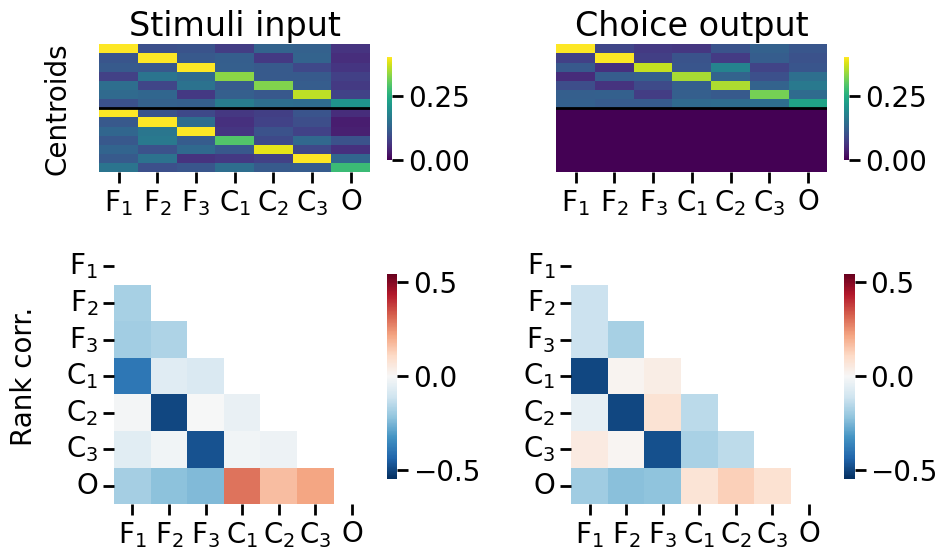

In [82]:
all_model_selectivity_clusters_stim, all_model_selectivity_clusters_choice = run_plot_selectivity_clusters(all_model_dpca_stim_in, all_model_dpca_choice_out, 
                                          all_model_dpca_choice_in, all_model_dpca_stim_out, args)
    

# Analysis of Naive Weights of RNN

## Analysis by cluster

TypeError: 'numpy.float64' object cannot be interpreted as an integer

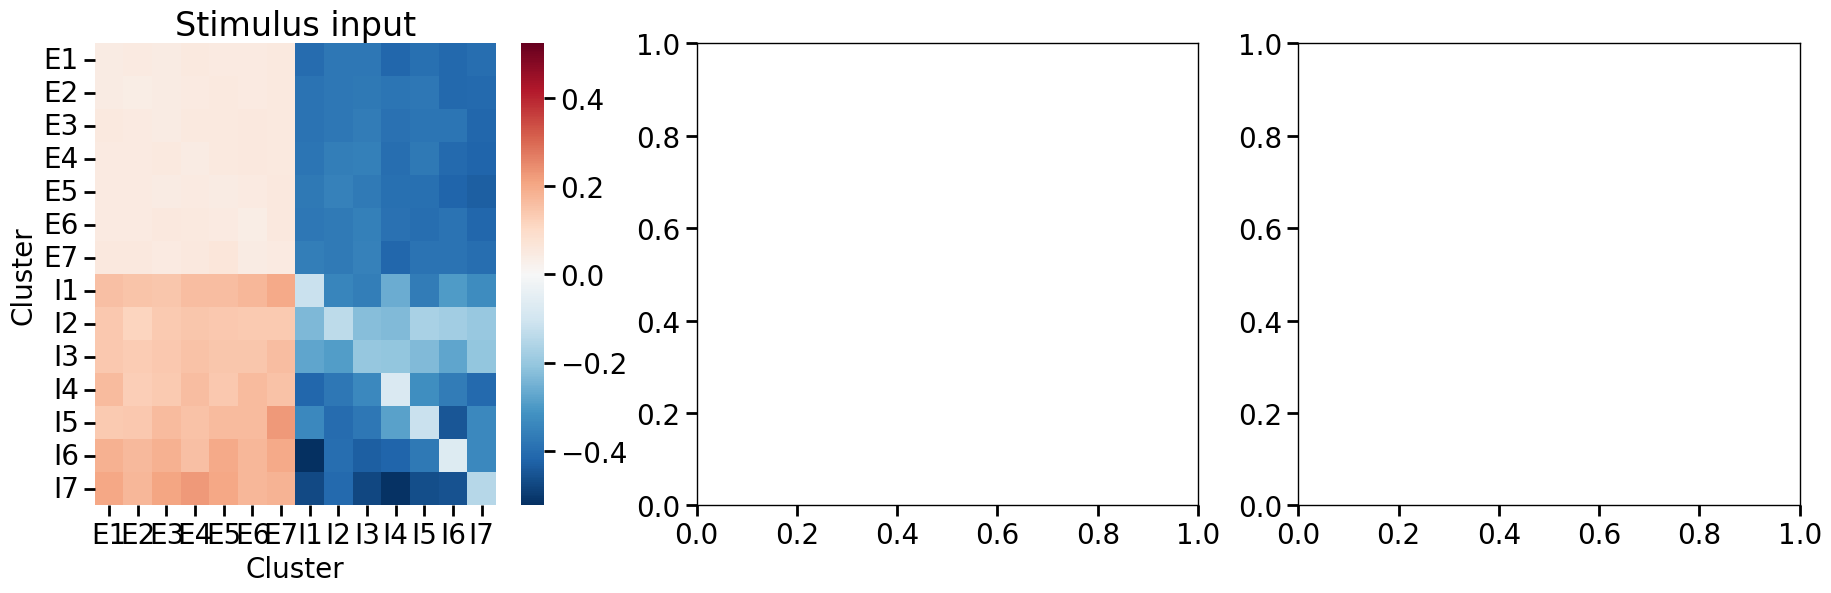

In [21]:
def plot_connectivity_by_clusters(all_model_rec, all_model_clusters_pre, all_model_clusters_post, label, axes):
    num_clusters_exc_pre = np.unique(all_model_clusters_pre[0])[-1]+1
    if all_model_clusters_pre[1] is not None:
        num_clusters_inh_pre = np.unique(all_model_clusters_pre[1])[-1]+1
    else:
        num_clusters_inh_pre = 0

    num_clusters_exc_post = np.unique(all_model_clusters_post[0])[-1]+1
    if all_model_clusters_post[1] is not None:
        num_clusters_inh_post = np.unique(all_model_clusters_post[1])[-1]+1
    else:
        num_clusters_inh_post = 0
    
    clus_conn_mat = np.zeros((len(all_model_rec), num_clusters_exc_post+num_clusters_inh_post, num_clusters_exc_pre+num_clusters_inh_pre ))

    
    for mdl_idx, mdl_rec in enumerate(all_model_rec):
        for clus_i in range(num_clusters_exc_post):
            for clus_j in range(num_clusters_exc_pre):
                clus_mask_i = all_model_clusters_post[0][mdl_idx]==clus_i
                clus_mask_j = all_model_clusters_pre[0][mdl_idx]==clus_j
                clus_conn_mat[mdl_idx, clus_i, clus_j] = mdl_rec[:E_SIZE,:E_SIZE][clus_mask_i][:,clus_mask_j].mean()

        for clus_i in range(num_clusters_exc_post):
            for clus_j in range(num_clusters_inh_pre):
                clus_mask_i = all_model_clusters_post[0][mdl_idx]==clus_i
                clus_mask_j = all_model_clusters_pre[1][mdl_idx]==clus_j
                clus_conn_mat[mdl_idx, clus_i, num_clusters_exc_pre+clus_j] = mdl_rec[:E_SIZE,E_SIZE:][clus_mask_i][:,clus_mask_j].mean()

        for clus_i in range(num_clusters_inh_post):
            for clus_j in range(num_clusters_exc_pre):
                clus_mask_i = all_model_clusters_post[1][mdl_idx]==clus_i
                clus_mask_j = all_model_clusters_pre[0][mdl_idx]==clus_j
                clus_conn_mat[mdl_idx, num_clusters_exc_pre+clus_i, clus_j] = mdl_rec[E_SIZE:,:E_SIZE][clus_mask_i][:,clus_mask_j].mean()

        for clus_i in range(num_clusters_inh_post):
            for clus_j in range(num_clusters_inh_pre):
                clus_mask_i = all_model_clusters_post[1][mdl_idx]==clus_i
                clus_mask_j = all_model_clusters_pre[1][mdl_idx]==clus_j
                clus_conn_mat[mdl_idx, num_clusters_exc_pre+clus_i, num_clusters_exc_pre+clus_j] = mdl_rec[E_SIZE:,E_SIZE:][clus_mask_i][:,clus_mask_j].mean()

    cmap_scale = max(np.abs(np.nanmean(clus_conn_mat, 0)).max(), 0)
    sns.heatmap(np.nanmean(clus_conn_mat, 0), ax=axes, cmap='RdBu_r', norm=mpl.colors.CenteredNorm(halfrange=cmap_scale))
    axes.set_xticks(np.arange(0,num_clusters_exc_pre+num_clusters_inh_pre)+0.5)
    axes.set_xticklabels([f'E{i+1}' for i in range(num_clusters_exc_pre)]+[f'I{i+1}' for i in range(num_clusters_inh_pre)], 
                       rotation=0)
    axes.set_yticks(np.arange(0,num_clusters_exc_post+num_clusters_inh_post)+0.5)
    axes.set_yticklabels([f'E{i+1}' for i in range(num_clusters_exc_post)]+[f'I{i+1}' for i in range(num_clusters_inh_post)], 
                       rotation=0)
    axes.set_xlabel('Cluster')
    axes.set_ylabel('Cluster')
    axes.set_title(label)

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

plot_connectivity_by_clusters([rec_intra[0] for rec_intra in all_model_rec_intra], 
                            all_model_selectivity_clusters_stim, 
                            all_model_selectivity_clusters_stim, 
                            "Stimulus input", axes[0])
plot_connectivity_by_clusters([rec_intra[1] for rec_intra in all_model_rec_intra], 
                            all_model_selectivity_clusters_choice, 
                            all_model_selectivity_clusters_choice, 
                            "Choice output", axes[1])
plot_connectivity_by_clusters([rec_intra[1] for rec_intra in all_model_rec_intra], 
                            all_model_selectivity_clusters_stim,
                            all_model_selectivity_clusters_stim,
                            "Choice feedback", axes[2])

fig.tight_layout()


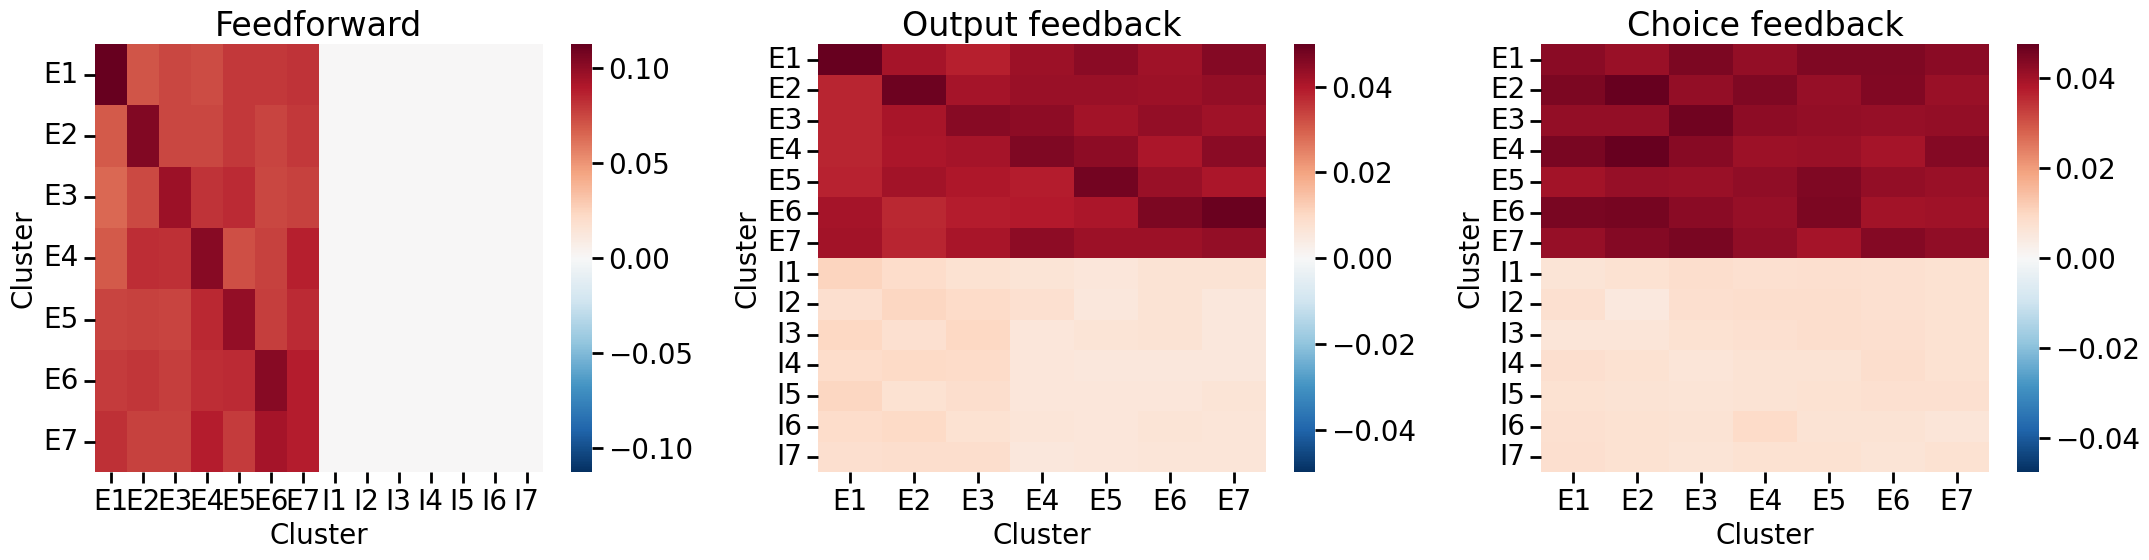

In [681]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

plot_connectivity_by_clusters([rec_inter[0] for rec_inter in all_model_rec_inter_ff], 
                              all_model_selectivity_clusters_in, 
                              all_model_selectivity_clusters_out, 
                              "Feedforward", axes[0])

plot_connectivity_by_clusters([rec_inter[0] for rec_inter in all_model_rec_inter_fb], 
                              all_model_selectivity_clusters_out, 
                              all_model_selectivity_clusters_in, 
                              "Output feedback", axes[1])

plot_connectivity_by_clusters([rec_inter[0] for rec_inter in all_model_rec_inter_fb], 
                              all_model_selectivity_clusters_ch, 
                              all_model_selectivity_clusters_in, 
                              "Choice feedback", axes[2])

fig.tight_layout()


## Analysis by cluster

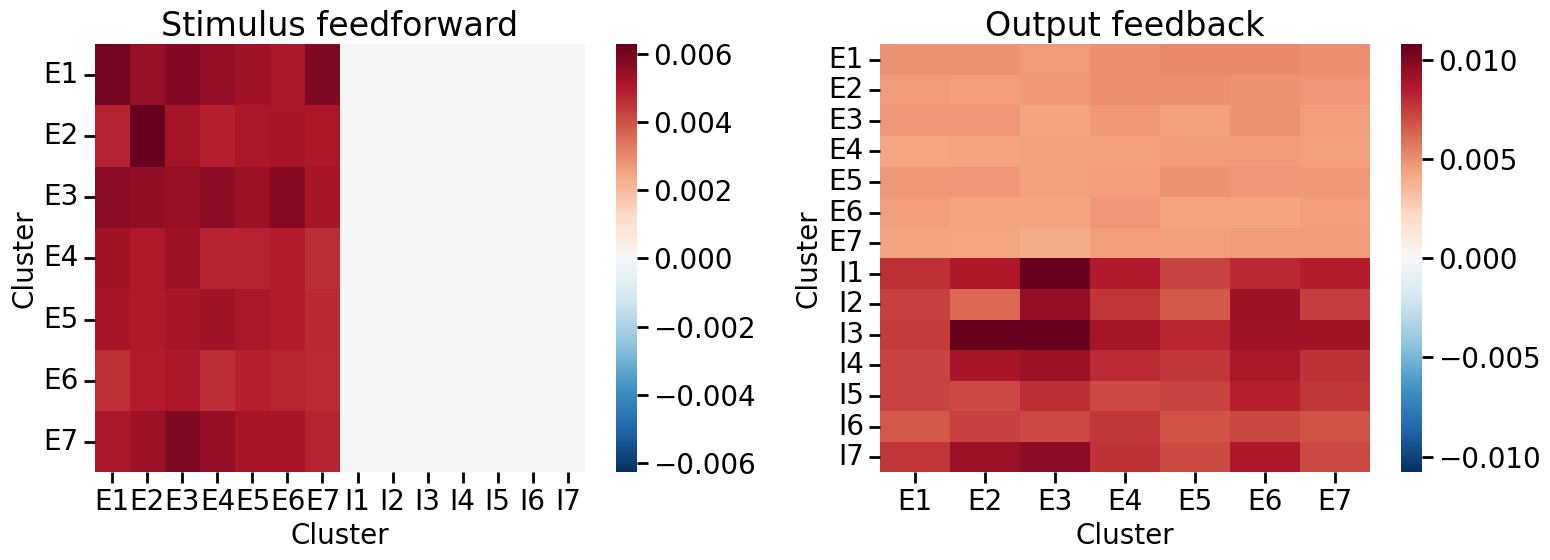

In [327]:
fig, axes = plt.subplots(1,2, figsize=(16, 6))

# plot_connectivity_by_clusters([kappa_intra[0] for kappa_intra in all_model_kappa_rec_intra], 
#                               all_model_selectivity_clusters_in, 
#                               all_model_selectivity_clusters_in, 
#                               "Input recurrent", axes[0,0])

plot_connectivity_by_clusters([kappa_inter[0] for kappa_inter in all_model_kappa_inter_ff], 
                              all_model_selectivity_clusters_in, 
                              all_model_selectivity_clusters_out, 
                              "Stimulus feedforward", axes[0])

# plot_connectivity_by_clusters([kappa_intra[1] for kappa_intra in all_model_kappa_rec_intra], 
#                               all_model_selectivity_clusters_out, 
#                               all_model_selectivity_clusters_out, 
#                               "Output recurrent", axes[1,1])

plot_connectivity_by_clusters([kappa_inter[0] for kappa_inter in all_model_kappa_inter_fb], 
                              all_model_selectivity_clusters_out, 
                              all_model_selectivity_clusters_in, 
                              "Output feedback", axes[1])

fig.tight_layout()


# Example simulations

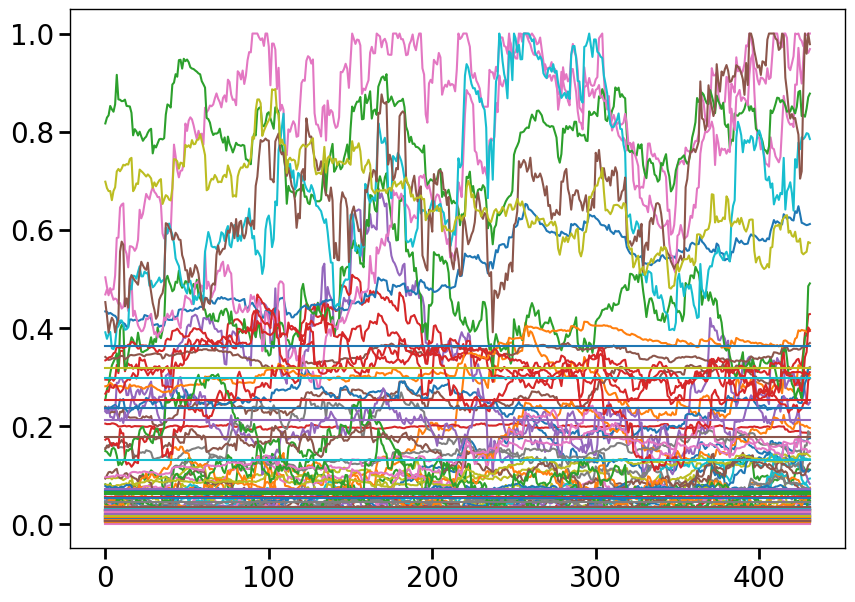

In [22]:
plt.plot(all_saved_states['whs'][:,0,np.random.randint(92),np.random.randint(128),:128]);

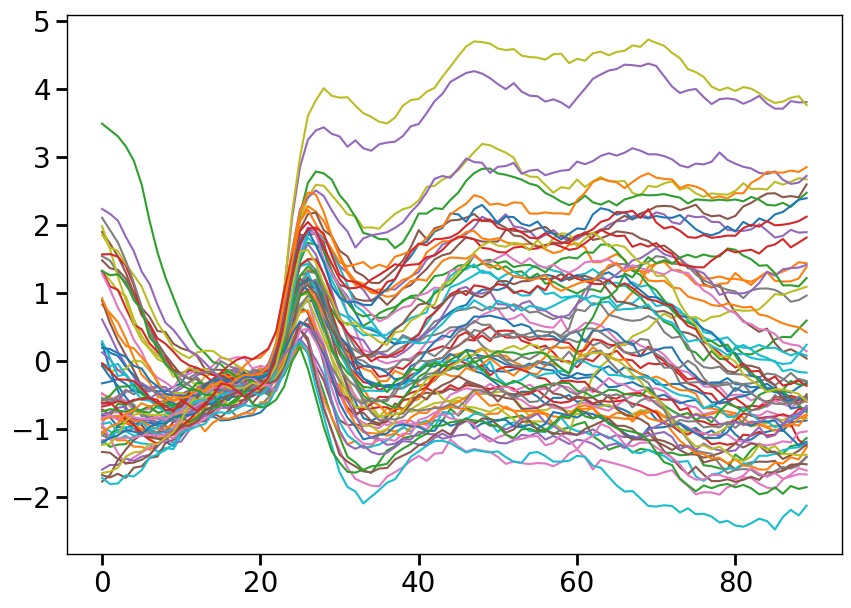

In [28]:
plt.plot(all_saved_states['hs'][np.random.randint(432),:,np.random.randint(92),64:128]);
# plt.colorbar()
# plt.plot(all_saved_states['hs'][np.random.randint(432),:,np.random.randint(92),64:128]);

## dPCA Analysis of the Activity of the RNN

In [207]:
def get_area_ei_indices(args, ind_area):
    hidden_size_per_area = args['hidden_size']
    E_SIZE = round(args['hidden_size']*args['e_prop'])
    I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
    NUM_AREAS = args['num_areas']
    return np.concatenate([np.arange(E_SIZE*ind_area, E_SIZE*(ind_area+1)), 
                           np.arange(E_SIZE*NUM_AREAS+I_SIZE*ind_area, E_SIZE*NUM_AREAS+I_SIZE*(ind_area+1))])

def make_dpca_results(Xs, labels, n_components):
    all_non_time_labels = labels
    join_dict = {}
    for r in range(1, len(labels)+1):
        for label in list(itertools.combinations(all_non_time_labels, r)):
            label_str = ''.join(label)
            join_dict['t'+label_str] = [label_str, 't'+label_str]
#             print(join_dict)

    dpca_model = dPCA.dPCA('t'+labels, join=join_dict, n_components=n_components)
    low_hs = dpca_model.fit_transform(Xs)

    all_axes = []
    all_explained_vars = []
    all_labels = []
    for k in dpca_model.marginalized_psth.keys():
        eff_components = np.sum(np.array(dpca_model.explained_variance_ratio_[k])>0.00)
        all_explained_vars.append(dpca_model.explained_variance_ratio_[k][:eff_components])
#         print(f"Variance explained by {eff_components} of {k}: {np.round(100*np.array(dpca_model.explained_variance_ratio_[k]),4)} %")
        all_axes.append(dpca_model.P[k][:,:eff_components])
        all_labels += [k]*eff_components

    all_axes = np.concatenate(all_axes, axis=1)
    all_explained_vars = np.concatenate(all_explained_vars, axis=0)

    dpca_results = {}
    dpca_results['low_hs'] = low_hs
    dpca_results['encoding_axes'] = dpca_model.P
    dpca_results['explained_variances'] = dpca_model.explained_variance_ratio_
    dpca_results['marginalized_psth'] = dpca_model.marginalized_psth

    return dpca_results

def get_dpca_by_area(all_saved_states, task_mdprl, args, 
                     trials_to_fit, area_to_fit, model_to_fit):
    '''
    (1) regress hs activity with
            previous trial choice shape, color, pattern (3x3x3), 
            previous trial reward (2),
            current trial stimuli shape, color, pattern pairs (3x3x3), 
            current trial choice shape, color, pattern (3x3x3), 
            current trial reward (2),
    (2) get beta weights which is a mixture of value and stimulus intensity: h ~ Xw. 
        This will give beta weights timepoints X trials X hidden X latent variables,
        calculate cpd gives timepoints X trials X hidden X latent variables CPD values
    (3) compare w with marginal reward probability? see which it dimension it corresponds to the best
    '''
    
    n_trials, n_timesteps, n_sessions, n_hidden = all_saved_states['hs'].shape
    n_areas = args['num_areas'] 
    n_hidden = n_hidden//n_areas

    area_inds = get_area_ei_indices(args, area_to_fit)
    sessions_to_fit = all_saved_states['model_assignment'].astype(int)==model_to_fit
    num_sessions_to_fit = np.sum(sessions_to_fit)

    area_hs = all_saved_states['hs'][...,area_inds]
    num_trials_to_fit = len(trials_to_fit)

#     print("Calculating PSTH by prev trial")

    '''
    organize by previous trial outcome
    '''
    hs_by_prev = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    
    flat_hs_post = area_hs.numpy()[trials_to_fit[1:],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1,3)).reshape((num_sessions_to_fit*(num_trials_to_fit-1), n_timesteps, n_hidden))
    flat_rwds_pre = all_saved_states['rewards'].numpy()[trials_to_fit[:-1],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1)).reshape((num_sessions_to_fit*(num_trials_to_fit-1))).astype(int)
    flat_acts_pre = all_saved_states['choices'].numpy()[trials_to_fit[:-1],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1)).reshape((num_sessions_to_fit*(num_trials_to_fit-1))).astype(int)

    # the prev_f{}_vals are IN TERMS OF THE REWARD SCHEDULE, NOT THE PERCEPTUAL DIMENSIONS

    act_f1_val = task_mdprl.index_shp[flat_acts_pre]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_pre]
    act_f3_val = task_mdprl.index_clr[flat_acts_pre]

    n_components_for_dpca_by_prev = {'t':3, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 
                                             'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                             'trs':2, 'trp':2, 'trc':2, 
                                             'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8}
    
    for prev_rwd_val in range(2):
        for prev_f1_val in range(3): 
            for prev_f2_val in range(3):
                for prev_f3_val in range(3):
                    # n_trials, 1, n_sessions, ...
                    where_trial = (flat_rwds_pre==prev_rwd_val) & \
                                  (act_f1_val==prev_f1_val) & \
                                  (act_f2_val==prev_f2_val) & \
                                  (act_f3_val==prev_f3_val)
                    hs_by_prev[:, :, prev_rwd_val, prev_f1_val, prev_f2_val, prev_f3_val] = \
                        flat_hs_post[where_trial,...].mean(0).T
                        

    del flat_hs_post
    del flat_rwds_pre
    del flat_acts_pre
    
    '''
    organize by current trial stimuli
    '''
#     print("Calculating PSTH by current trial stimuli")

    n_components_for_dpca_by_curr_stim = {'t':5, 'ts':2, 'tp':2, 'tc':2, 
                                          'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8}

    hs_by_curr_stim = np.zeros((n_hidden, n_timesteps, 6, 6, 6)) # sort data by current trial choices and outcomes

    flat_hs_curr = area_hs[trials_to_fit][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1,3)).reshape((num_sessions_to_fit*num_trials_to_fit, n_timesteps, n_hidden))
    flat_stims = all_saved_states['stimuli'][trials_to_fit][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1,3)).reshape((num_sessions_to_fit*num_trials_to_fit, 2)).astype(int)

    pair_to_ind = {(0,1): 0, (1,0): 1, (0,2): 2, (2,0): 3, (1,2): 4, (2,1): 5}

    stim_f1_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f2_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f3_val = np.ones_like(flat_stims[:,0])*np.nan
    
    for k, v in pair_to_ind.items():
        stim_f1_val[(task_mdprl.index_shp[flat_stims[:,0]]==k[0]) & (task_mdprl.index_shp[flat_stims[:,1]]==k[1])] = v
        stim_f2_val[(task_mdprl.index_pttrn[flat_stims[:,0]]==k[0]) & (task_mdprl.index_pttrn[flat_stims[:,1]]==k[1])] = v
        stim_f3_val[(task_mdprl.index_clr[flat_stims[:,0]]==k[0]) & (task_mdprl.index_clr[flat_stims[:,1]]==k[1])] = v
    
    for curr_f1_val in range(6):
        for curr_f2_val in range(6):
            for curr_f3_val in range(6):
                # n_trials, 1, n_sessions, ...
                where_trial = (stim_f1_val==curr_f1_val) & \
                              (stim_f2_val==curr_f2_val) & \
                              (stim_f3_val==curr_f3_val)
                hs_by_curr_stim[:, :, curr_f1_val, curr_f2_val, curr_f3_val] = \
                    flat_hs_curr[where_trial,...].mean(0).T

    del flat_stims

    '''
    organize by current trial outcome
    '''
#     print("Calculating PSTH by current trial outcome")

    n_components_for_dpca_by_curr_outcome = {'t':3, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 
                                             'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                             'trs':2, 'trp':2, 'trc':2, 
                                             'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8}

    hs_by_curr_outcome = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    flat_rwds_curr = all_saved_states['rewards'][trials_to_fit,...][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1)).reshape((num_sessions_to_fit*num_trials_to_fit)).astype(int)
    flat_acts_curr = all_saved_states['choices'][trials_to_fit,...][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1)).reshape((num_sessions_to_fit*num_trials_to_fit)).astype(int)

    act_f1_val = task_mdprl.index_shp[flat_acts_curr]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_curr]
    act_f3_val = task_mdprl.index_clr[flat_acts_curr]

    for curr_rew_val in range(2):
        for curr_f1_val in range(3):
            for curr_f2_val in range(3):
                for curr_f3_val in range(3):      
                    # n_trials, 1, n_sessions, ...
                    where_trial = (flat_rwds_curr==curr_rew_val) & \
                                  (act_f1_val==curr_f1_val) & \
                                  (act_f2_val==curr_f2_val) & \
                                  (act_f3_val==curr_f3_val)
                    hs_by_curr_outcome[:, :, curr_rew_val, curr_f1_val, curr_f2_val, curr_f3_val] = \
                        flat_hs_curr[where_trial,...].mean(0).T
         
    del flat_hs_curr
    del flat_rwds_curr
    del flat_acts_curr


#     print("-------------------------------------------")
#     print('Calculating DPCA by previous trial outcome')
    dpca_results_by_prev = make_dpca_results(hs_by_prev, "rspc", n_components=n_components_for_dpca_by_prev)
#     print("-------------------------------------------")
#     print('Calculating DPCA by current trial stimuli')
    dpca_results_by_curr_stim = make_dpca_results(hs_by_curr_stim, "spc", n_components=n_components_for_dpca_by_curr_stim)
#     print("-------------------------------------------")
#     print('Calculating DPCA by current trial outcome')
    dpca_results_by_curr_outcome = make_dpca_results(hs_by_curr_outcome, "rspc", n_components=n_components_for_dpca_by_curr_outcome)

#     fig, axes = plt.subplots(2, 2)
#     for i in range(4):
#         plot_mean_and_std(axes[i//2, i%2], all_cpds[i].mean([0, 2]), 
#                           all_cpds[i].std([0, 2])/np.sqrt(n_trials//4*n_batch), label=['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'])
    return dpca_results_by_prev, dpca_results_by_curr_stim, dpca_results_by_curr_outcome

In [208]:
def get_dpca_axes_overlap(dpca_results_row, dpca_results_col,
                          row_keys=['ts','tp','tc','tpc','tsc','tsp','tspc'], 
                          col_keys=['ts','tp','tc','tpc','tsc','tsp','tspc']):
    overlap_mat = np.empty((7,7))
    for k_row_idx, k_row in enumerate(row_keys):
        for k_col_idx, k_col in enumerate(col_keys):
            overlap_mat[k_row_idx, k_col_idx] = \
                np.sum((dpca_results_row[k_row].T@dpca_results_col[k_col])**2)/dpca_results_row[k_row].shape[1]
    return overlap_mat

def get_dpca_exp_var(dpca_results, keys=['t', 'ts','tp','tc','tpc','tsc','tsp','tspc']):
    exp_var_mat = np.empty(len(keys))
    for k_idx, k in enumerate(keys):
        exp_var_mat[k_idx] = np.sum(dpca_results['explained_variances'][k])
    return exp_var_mat
    

In [209]:
all_model_curr_stim_overlap = []
all_model_curr_outcome_overlap = []

for idx_model in tqdm.tqdm(range(len(all_models))):
    # iterate all area for each model
    all_area_curr_stim_overlap = []
    all_area_curr_outcome_overlap = [] 
    for idx_area in range(NUM_AREAS):
        # for each area of each network, split into two blocks of trials
        dpca_results_by_curr_stim_split = []
        dpca_results_by_curr_outcome_split = []
        for idx_block in range(2):
            trials_to_fit = np.arange(idx_block*27*8, (idx_block+1)*27*8)
            _, area_dpca_by_curr_stim, area_dpca_by_curr_outcome = \
                            get_dpca_by_area(all_saved_states, task_mdprl, args, 
                                             area_to_fit=idx_area, 
                                             trials_to_fit=trials_to_fit,
                                             model_to_fit=idx_model)
            dpca_results_by_curr_stim_split.append(area_dpca_by_curr_stim)
            dpca_results_by_curr_outcome_split.append(area_dpca_by_curr_outcome)
        
            
        curr_stim_overlap = get_dpca_axes_overlap(dpca_results_by_curr_stim_split[0]['encoding_axes'],
                                                  dpca_results_by_curr_stim_split[1]['encoding_axes'])


        curr_outcome_overlap = get_dpca_axes_overlap(dpca_results_by_curr_outcome_split[0]['encoding_axes'],
                                                     dpca_results_by_curr_outcome_split[1]['encoding_axes'])

        
        all_area_curr_stim_overlap.append(np.stack(curr_stim_overlap))
        all_area_curr_outcome_overlap.append(np.stack(curr_outcome_overlap))
        
    all_model_curr_stim_overlap.append(np.stack(all_area_curr_stim_overlap))
    all_model_curr_outcome_overlap.append(np.stack(all_area_curr_outcome_overlap))
    
all_model_curr_stim_overlap = np.stack(all_model_curr_stim_overlap)
all_model_curr_outcome_overlap = np.stack(all_model_curr_outcome_overlap)
        

 88%|████████▊ | 7/8 [01:25<00:12, 12.19s/it]/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:984: RuntimeWarning: invalid value encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]
100%|██████████| 8/8 [01:37<00:00, 12.18s/it]


Figure saved at plots/exp/test1/dpca_stability_by_block.pdf


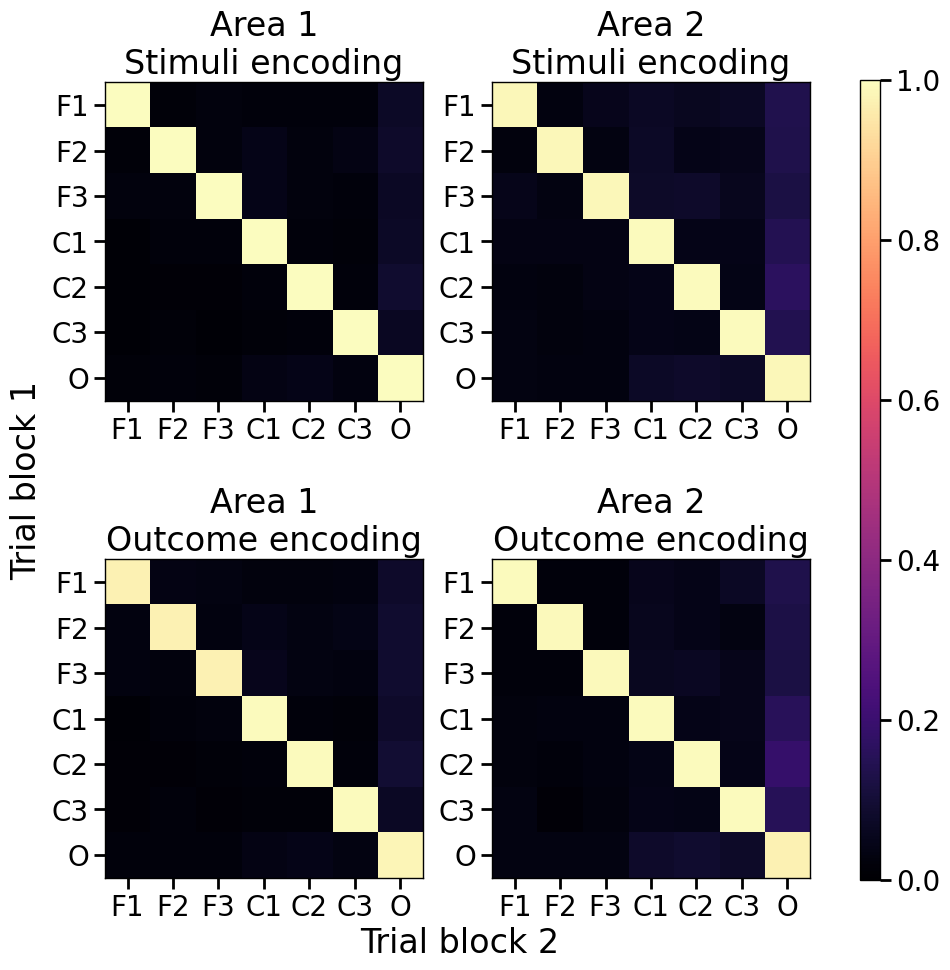

In [210]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


for area in range(2):
    cm = axes[0,area].imshow(all_model_curr_stim_overlap.mean(0)[area], vmin=0, vmax=1, cmap='magma')  
    axes[0,area].set_xticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[0,area].set_yticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[0,area].set_title(f'Area {area+1}\nStimuli encoding')
        
for area in range(2):
    cm = axes[1,area].imshow(all_model_curr_outcome_overlap.mean(0)[area], vmin=0, vmax=1, cmap='magma') 
    axes[1,area].set_xticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[1,area].set_yticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[1,area].set_title(f'Area {area+1}\nOutcome encoding')
        
fig.supxlabel("Trial block 2", y=0.02)
fig.supylabel("Trial block 1", x=0.05)
fig.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.85, top=0.9)
cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


with PdfPages(f'plots/{plot_save_dir}/dpca_stability_by_block.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_stability_by_block.pdf')



In [211]:
all_model_dpca_curr_stim = []
all_model_dpca_curr_outcome = []

for idx_model in tqdm.tqdm(range(len(all_models))):
    # iterate all area for each model
    all_area_dpca_curr_stim = []
    all_area_dpca_curr_outcome = [] 
    for idx_area in range(NUM_AREAS):
        # for each area of each network, split into two blocks of trials
        trials_to_fit = np.arange(args['test_N_s'])
        _, area_dpca_by_curr_stim, area_dpca_by_curr_outcome = \
                        get_dpca_by_area(all_saved_states, task_mdprl, args, 
                                         area_to_fit=idx_area, 
                                         trials_to_fit=trials_to_fit,
                                         model_to_fit=idx_model)
        
        all_area_dpca_curr_stim.append(area_dpca_by_curr_stim)
        all_area_dpca_curr_outcome.append(area_dpca_by_curr_outcome)
        
    all_model_dpca_curr_stim.append(all_area_dpca_curr_stim)
    all_model_dpca_curr_outcome.append(all_area_dpca_curr_outcome)


100%|██████████| 8/8 [00:52<00:00,  6.53s/it]


Figure saved at plots/exp/test1/dpca_curr_outcome_overlap.pdf


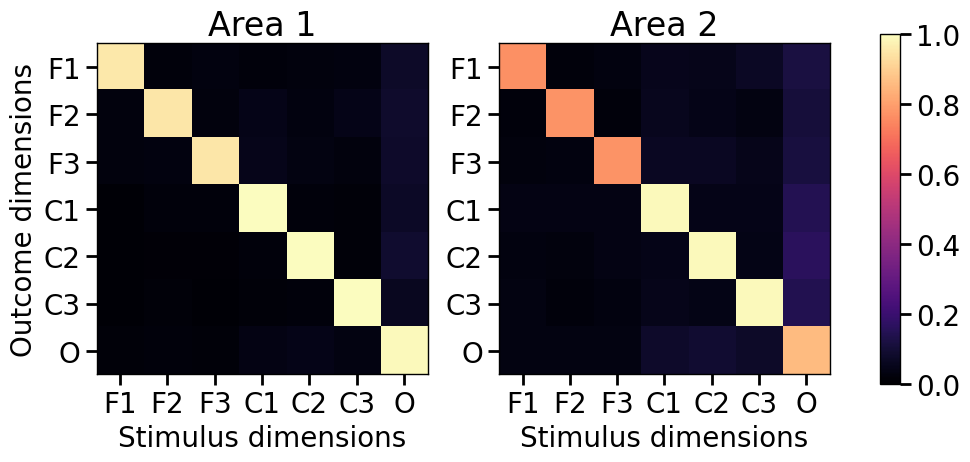

In [212]:
all_model_stim_outcome_overlap = []

fig, axes = plt.subplots(1, 2, figsize=(10, 7))

for idx_model in range(len(all_models)):
    all_areas_stim_outcome_overlap = []
    for idx_area in range(NUM_AREAS):
        stim_outcome_overlap = get_dpca_axes_overlap(all_model_dpca_curr_outcome[idx_model][idx_area]['encoding_axes'],
                                                     all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes'])
#         for k_outcome_idx, k_outcome in enumerate(['s','p','c','pc','sc','sp','spc']):
#             for k_stim_idx, k_stim in enumerate(['s','p','c','pc','sc','sp','spc']):
#                 stim_outcome_overlap[k_outcome_idx, k_stim_idx] = \
#                     np.sum((all_model_dpca_curr_outcome[idx_model][idx_area]['encoding_axes']['t'+k_outcome].T@\
#                             all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes']['t'+k_stim])**2)/\
#                     all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes']['t'+k_stim].shape[1]

        all_areas_stim_outcome_overlap.append(stim_outcome_overlap)
    all_model_stim_outcome_overlap.append(np.stack(all_areas_stim_outcome_overlap))
all_model_stim_outcome_overlap = np.stack(all_model_stim_outcome_overlap)

    
for idx_area in range(NUM_AREAS):
    cm = axes[idx_area].imshow(all_model_stim_outcome_overlap.mean(0)[idx_area], vmin=0, vmax=1, cmap='magma')  
    axes[idx_area].set_xticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[idx_area].set_yticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[idx_area].set_xlabel("Stimulus dimensions")
    axes[idx_area].set_title(f"Area {idx_area+1}")
    
axes[0].set_ylabel("Outcome dimensions")
    
fig.tight_layout()
    
plt.subplots_adjust(bottom=0.05, right=0.85, top=0.95)
cb_ax = fig.add_axes([0.9, 0.25, 0.02, 0.5])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


with PdfPages(f'plots/{plot_save_dir}/dpca_curr_outcome_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_curr_outcome_overlap.pdf')


In [213]:
all_model_weight_dpca_overlap_stim = []
all_model_weight_dpca_overlap_outcome = []


for idx_model in range(len(all_models)):
    
    all_model_weight_dpca_overlap_stim.append(np.stack([
        get_dpca_axes_overlap(all_model_dpca_in[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][0]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_out[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_ch[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc'])
    ]))
    
    all_model_weight_dpca_overlap_outcome.append(np.stack([
        get_dpca_axes_overlap(all_model_dpca_in[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][0]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_out[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_ch[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc'])
    ]))
    
all_model_weight_dpca_overlap_stim = np.stack(all_model_weight_dpca_overlap_stim)
all_model_weight_dpca_overlap_outcome = np.stack(all_model_weight_dpca_overlap_outcome)
    
    

/scratch/ipykernel_733553/2159772354.py:22: UserWarning: Adding colorbar to a different Figure <Figure size 1000x700 with 3 Axes> than <Figure size 1200x700 with 7 Axes> which fig.colorbar is called on.
  fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


Figure saved at plots/exp/test1/dpca_struct_func_overlap.pdf


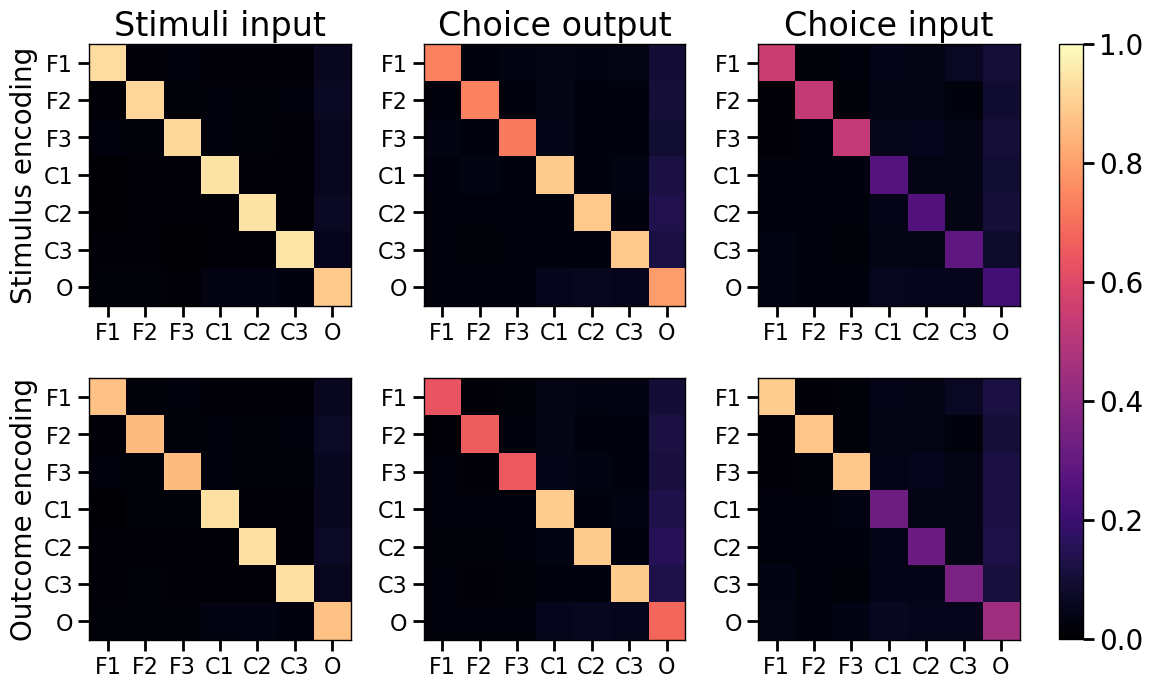

In [214]:
fig, axes = plt.subplots(2, 3, figsize=(12,7))


for i in range(3):
    axes[0,i].imshow(all_model_weight_dpca_overlap_stim.mean(0)[i], vmin=0, vmax=1, cmap='magma')
    axes[1,i].imshow(all_model_weight_dpca_overlap_outcome.mean(0)[i], vmin=0, vmax=1, cmap='magma')

for i in range(2):
    for j in range(3):
        axes[i,j].set_xticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"], fontsize=16)
        axes[i,j].set_yticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"], fontsize=16)

axes[0,0].set_ylabel("Stimulus encoding")
axes[1,0].set_ylabel("Outcome encoding")
axes[0,0].set_title("Stimuli input")
axes[0,1].set_title("Choice output")
axes[0,2].set_title("Choice input")

fig.tight_layout()
plt.subplots_adjust(top=0.95, right=0.88)
cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.85])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)

with PdfPages(f'plots/{plot_save_dir}/dpca_struct_func_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_struct_func_overlap.pdf')


In [215]:
all_models_stim_exp_var = []
all_models_outcome_exp_var = []

for idx_model in range(len(all_models)):
    
    all_areas_stim_exp_var = []
    all_areas_outcome_exp_var = []
    for idx_area in range(NUM_AREAS):
        all_areas_stim_exp_var.append(get_dpca_exp_var(all_model_dpca_curr_stim[idx_model][idx_area]))
        all_areas_outcome_exp_var.append(get_dpca_exp_var(all_model_dpca_curr_outcome[idx_model][idx_area]))
    
    all_areas_stim_exp_var = np.stack(all_areas_stim_exp_var)
    all_models_stim_exp_var.append(all_areas_stim_exp_var)
    all_areas_outcome_exp_var = np.stack(all_areas_outcome_exp_var)
    all_models_outcome_exp_var.append(all_areas_outcome_exp_var)

all_models_stim_exp_var = np.stack(all_models_stim_exp_var)
all_models_outcome_exp_var = np.stack(all_models_outcome_exp_var)




Figure saved at plots/fp_approx/dpca_func_exp_var.pdf


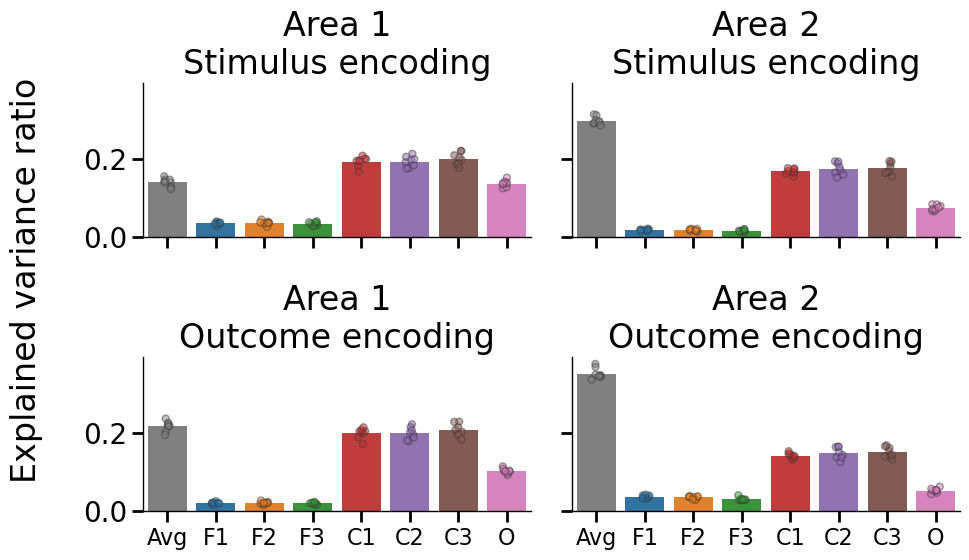

In [216]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 6))

# axes[0,0].bar(np.arange(8), all_models_stim_exp_var.mean(0)[0])
# axes[0,1].bar(np.arange(8), all_models_stim_exp_var.mean(0)[1])
# axes[1,0].bar(np.arange(8), all_models_outcome_exp_var.mean(0)[0])
# axes[1,1].bar(np.arange(8), all_models_outcome_exp_var.mean(0)[1])

def plot_functional_dpca_exp_var(exp_var, ax, title):
    xxx_for_plot = np.repeat(np.arange(8)[None], len(all_models), axis=0)
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(np.concatenate([np.array([[0.5, 0.5, 0.5, 1]]), plt.cm.tab10(np.arange(7))]))
    
    
    sns.barplot(ax=ax, x=xxx_for_plot.flatten(), hue=xxx_for_plot.flatten(),
                y=exp_var.flatten(), palette=cmap, errorbar=None, legend=False)
    sns.stripplot(ax=ax, x=xxx_for_plot.flatten(), y=exp_var.flatten(),
                  hue=xxx_for_plot.flatten(), 
                  palette=cmap, legend=False, linewidth=1, alpha=0.5)
    
    ax.set_title(title)
    ax.set_xticks(np.arange(8),["Avg", "F1", "F2", "F3", "C1", "C2", "C3", "O"], fontsize=16)
    
plot_functional_dpca_exp_var(all_models_stim_exp_var[:,0], axes[0,0], f'Area 1\nStimulus encoding')
plot_functional_dpca_exp_var(all_models_stim_exp_var[:,1], axes[0,1], f'Area 2\nStimulus encoding')
plot_functional_dpca_exp_var(all_models_outcome_exp_var[:,0], axes[1,0], f'Area 1\nOutcome encoding')
plot_functional_dpca_exp_var(all_models_outcome_exp_var[:,1], axes[1,1], f'Area 2\nOutcome encoding')


fig.supylabel('Explained variance ratio')

sns.despine()
fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/dpca_func_exp_var.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/dpca_func_exp_var.pdf')


In [72]:
# kills the kernel, caution

# fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)

# weight_alignment = np.trace(all_saved_states['whs'].squeeze()[...,64:128,:][...,:64]@\
#              all_saved_states['whs'].squeeze()[...,:64,:][...,64:128], axis1=-2, axis2=-1)

# plot_mean_and_std(ax, weight_alignment.mean(1), weight_alignment.std(1)/np.sqrt(weight_alignment.shape[1]), label=None, color='k')
            
# ax.set_xlabel('Trial')
# ax.set_ylabel('Weight alignment')

# fig.tight_layout()

# Candidate mechanisms of modulating attention
$$
\begin{align*}
    \frac{\partial \text{logit}_s}{\partial r_{s-1}}=\underbrace{B diag(\sigma'_{ })}_{\text{1.gain modulation}} 
    \underbrace{(I-W_sdiag(\sigma'_{}))^{-1}}_{\text{2.recurrence}}
    \underbrace{(A\odot(h_{s-1}h_{s-1}^{\top}))h_s}_{\text{3.routing through alignment}}
\end{align*}
$$
1. Gain modulation
2. Amplification through recurrence
2. Dynamic routing through alignment

### activity of rnn at the end of choice trials and choice presentation approximately converges, so we can simplify with implicit function

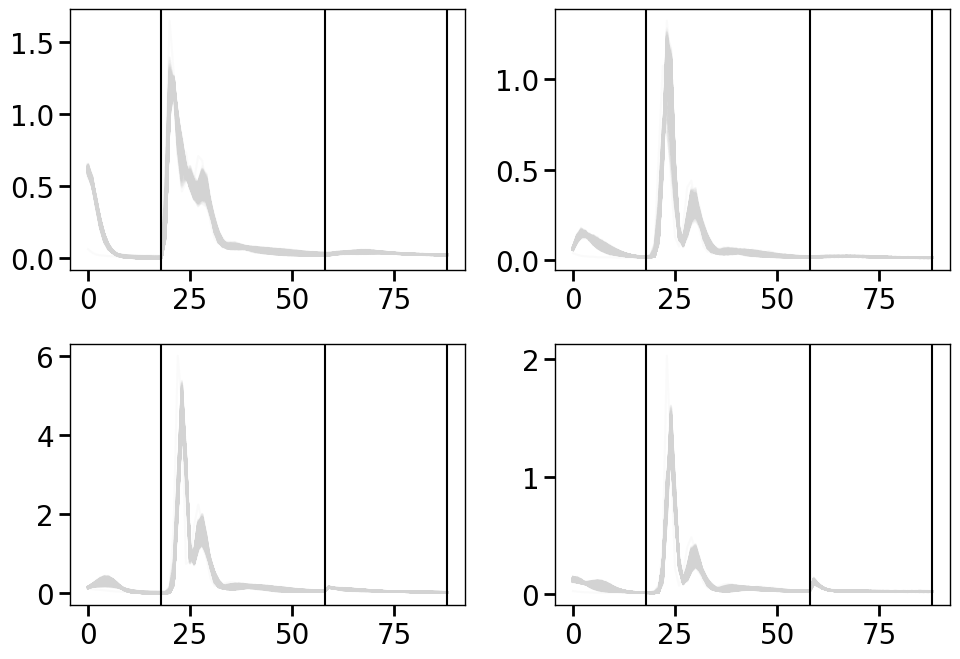

In [29]:
fig, axes = plt.subplots(2, 2)

all_saved_hs = model.rnn.activation(all_saved_states['hs'])

delta_h = ((all_saved_hs[:,1:,:,:]-all_saved_hs[:,:-1,:,:])**2).mean(2) 
# shape = trial X time X units

axes[0,0].plot(delta_h[...,input_weight_inds[:64]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');
axes[0,1].plot(delta_h[...,input_weight_inds[64:]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');
axes[1,0].plot(delta_h[...,output_weight_inds[:64]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');
axes[1,1].plot(delta_h[...,output_weight_inds[64:]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');

for i in range(2):
    for j in range(2):
        axes[i,j].axvline(task_mdprl.T_fixation-2, color='black')
        axes[i,j].axvline(task_mdprl.T_stim+task_mdprl.T_fixation-2, color='black')
        axes[i,j].axvline(task_mdprl.T_stim+task_mdprl.T_fixation+task_mdprl.T_ch-2, color='black')
#         axes[i,j].set_yscale('log')
#         axes[i,j].axvline(np.where(task_mdprl.T_rwd)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][-1], color='black')

plt.tight_layout()


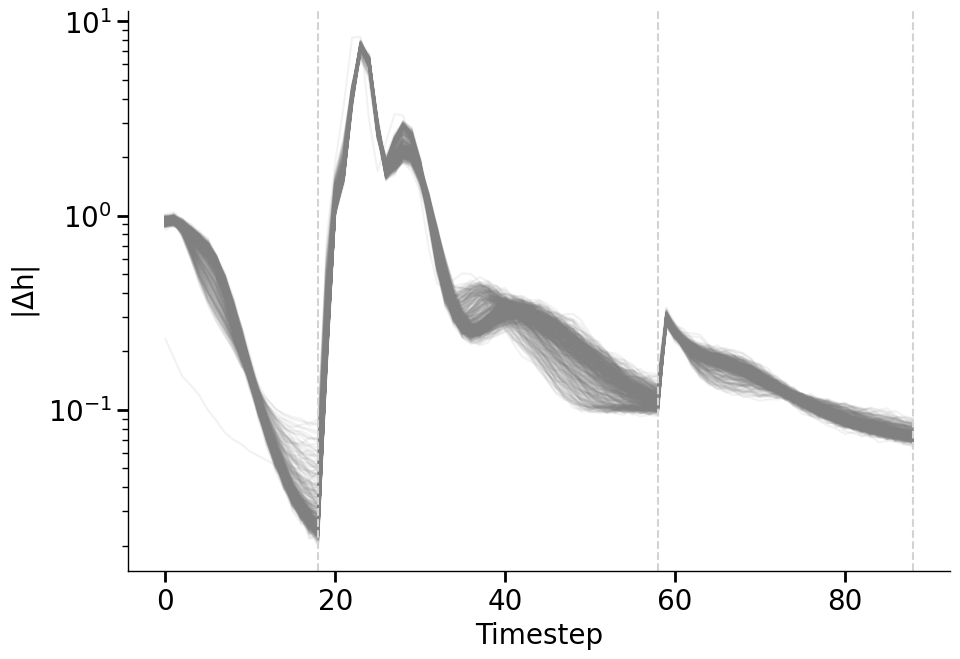

In [30]:
plt.plot(delta_h.sum(-1).T.numpy(), alpha=0.1, color='grey');


plt.axvline(task_mdprl.T_fixation-2, color='lightgrey', ls='--')
plt.axvline(task_mdprl.T_stim+task_mdprl.T_fixation-2, color='lightgrey', ls='--')
plt.axvline(task_mdprl.T_stim+task_mdprl.T_fixation+task_mdprl.T_ch-2, color='lightgrey', ls='--')
#         plt.axvline(np.where(task_mdprl.T_rwd)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][-1], color='black')

# plt.axhline(0.01, linestyle='--', c='k')
plt.yscale('log')
plt.xlabel('Timestep')
plt.ylabel(r'$|\Delta h|$')
sns.despine()
plt.tight_layout()

In [31]:
# get the gains and average firing rates necessary for further calculations

# activity at steady state of decision phase
h_avg_ch = all_saved_hs[:,task_mdprl.T_fixation+task_mdprl.T_stim-1,:,:] 
# activity at steady state of choice feedback phase
h_avg_lrn = all_saved_hs[:,-1,:,:]
h_gain = ((h_avg_ch>0).float()*(1-h_avg_ch**2)) # gain at steady state

print(h_avg_ch.shape, h_avg_lrn.shape, h_gain.shape)
print(model.h2o['action'].effective_weight().detach().shape, all_saved_states['whs'].shape)


torch.Size([432, 192, 160]) torch.Size([432, 192, 160]) torch.Size([432, 192, 160])
torch.Size([27, 160]) torch.Size([432, 1, 192, 160, 160])


In [32]:
whs_no_mod = []
# all_saved_states['whs'] contains weights *after each trial*, so add initial weights back in
# whs_no_mod contains weights *during* each trial

for idx_sess in tqdm.tqdm(range(all_saved_states['hs'].shape[2])):
    model = all_models[all_saved_states['model_assignment'][idx_sess]]
    whs_no_mod.append(torch.cat([
        model.rnn.h2h.effective_weight()[None],
        model.rnn.h2h.effective_weight(all_saved_states['whs'][:-1,0,idx_sess,...])
    ]))

whs_no_mod = torch.stack(whs_no_mod, 1)
print(whs_no_mod.shape)
    

100%|██████████| 192/192 [00:02<00:00, 84.42it/s]


torch.Size([432, 192, 160, 160])


In [33]:
h2o_gain_mod = []
whs_gain_mod = []
delta_ws = []

for idx_sess in tqdm.tqdm(range(all_saved_hs.shape[2])):
    model = all_models[all_saved_states['model_assignment'][idx_sess]]
    # gain modulated readout
    h2o_gain_mod.append(
        h_gain[:,idx_sess:idx_sess+1,:]*\
        model.h2o['action'].effective_weight().detach()[None,:,:])
    # gain modulated recurrent weights
    whs_gain_mod.append(
        h_gain[:,idx_sess:idx_sess+1,:]*whs_no_mod[:,idx_sess,...])
    # weight change (unsigned)
    delta_ws.append((model.plasticity.effective_lr().detach()*model.rnn.h2h.mask)[None]*\
                (h_avg_lrn[:,idx_sess][...,None]*h_avg_lrn[:,idx_sess][...,None,:]))

h2o_gain_mod = torch.stack(h2o_gain_mod, axis=1)
whs_gain_mod = torch.stack(whs_gain_mod, axis=1)
delta_ws = torch.stack(delta_ws, axis=1)

print(h2o_gain_mod.shape, whs_gain_mod.shape, delta_ws.shape)


100%|██████████| 192/192 [00:07<00:00, 25.97it/s]


torch.Size([432, 192, 27, 160]) torch.Size([432, 192, 160, 160]) torch.Size([432, 192, 160, 160])


In [34]:
h2o_gain_mod_avail = torch.empty(431, 192, 160)

for idx_trial in range(1,432):
    for idx_sess in range(192):
        curr_stimuli = all_saved_states['stimuli'][idx_trial, 0, idx_sess]
        h2o_gain_mod_avail[idx_trial-1, idx_sess] = \
            h2o_gain_mod[idx_trial,idx_sess,curr_stimuli[1]]-h2o_gain_mod[idx_trial,idx_sess,curr_stimuli[0]]


### correlation between analytical gradient and approximation

In [96]:
# invert I-jacobian 

inv_jac = torch.zeros_like(whs_gain_mod)

for idx_trial in tqdm.tqdm(range(432)):
    for idx_sess in range(92):
        
        lstsq_result = torch.linalg.lstsq(
                    torch.eye(args['hidden_size']*args['num_areas'])-whs_gain_mod[idx_trial, idx_sess], 
                    torch.eye(args['hidden_size']*args['num_areas']),
                    rcond=0.01, driver='gelsd')

        inv_jac[idx_trial, idx_sess] = lstsq_result[0]

print(inv_jac.shape)


100%|██████████| 432/432 [02:14<00:00,  3.20it/s]

torch.Size([432, 92, 160, 160])


In [97]:
inv_jac_times_hebb = torch.zeros_like(h_avg_ch)*torch.nan
hebb_times_hs = torch.zeros_like(h_avg_ch)*torch.nan

for idx_trial in tqdm.tqdm(range(432-1)):
    for idx_sess in range(92):
        hebb_times_hs[idx_trial, idx_sess] = \
            delta_ws[idx_trial, idx_sess]@h_avg_ch[idx_trial+1, idx_sess, :]
        inv_jac_times_hebb[idx_trial, idx_sess] = \
            (inv_jac[idx_trial+1, idx_sess]@hebb_times_hs[idx_trial, idx_sess][:,None]).squeeze()

inv_jac_times_hebb = inv_jac_times_hebb[:-1]
hebb_times_hs = hebb_times_hs[:-1]

print(inv_jac_times_hebb.shape, hebb_times_hs.shape)

100%|██████████| 431/431 [00:02<00:00, 212.95it/s]

torch.Size([431, 92, 160]) torch.Size([431, 92, 160])


In [98]:
# calculate approximate sensitivity
approx_sensitivity = h2o_gain_mod_avail[...,None,:]@inv_jac_times_hebb[...,None]
print(approx_sensitivity.shape, all_saved_states['rwd_sensitivity'].shape)

torch.Size([431, 92, 1, 1]) torch.Size([432, 1, 92])


removed 0 trial(s)
LinregressResult(slope=0.6193800061711615, intercept=-3.666480823272207e-05, rvalue=0.8570052964628361, pvalue=0.0, stderr=0.001870331668105911, intercept_stderr=0.00041223289764844625)
Figure saved at plots/exp/test1/true_approx_sensitivity_corr.pdf


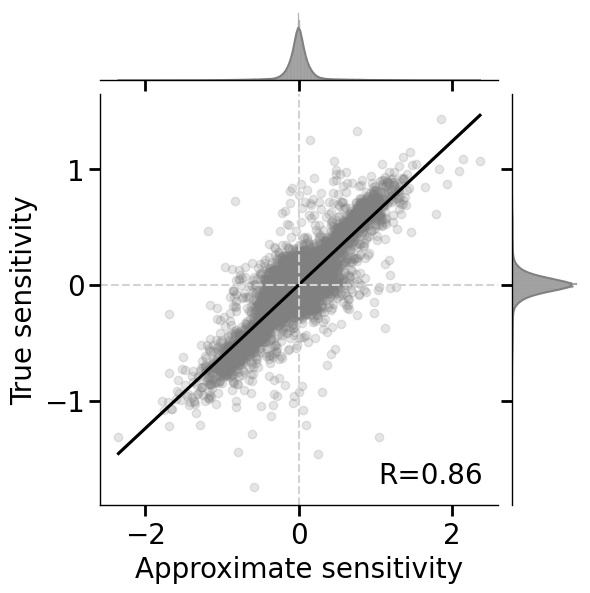

In [99]:
# plot scatter 
# fig, ax = plt.subplots(figsize=(6,6))

true_sensitivity = all_saved_states['rwd_sensitivity'][1:].squeeze().flatten().numpy()
# true_sensitivity_outlier_mask = np.abs(true_sensitivity-np.median(true_sensitivity))<\
#                                         np.mean(np.abs(true_sensitivity-np.median(true_sensitivity)))*20
true_sensitivity_outlier_mask = np.abs(true_sensitivity)<5
print(f"removed {(~true_sensitivity_outlier_mask).sum()} trial(s)")
true_sensitivity_no_outlier = true_sensitivity[true_sensitivity_outlier_mask]
approx_sensitivity_no_outlier = approx_sensitivity.detach().squeeze().flatten().numpy()
approx_sensitivity_no_outlier = approx_sensitivity_no_outlier[true_sensitivity_outlier_mask]

jp = sns.jointplot(x=approx_sensitivity_no_outlier, 
                  y=true_sensitivity_no_outlier,
                  kind='reg', color='grey', scatter_kws={'color':'grey', 'alpha':0.2}, line_kws={'color':'k'})

# scatter_kws={'color':'grey', 'alpha':0.2}, line_kws={'color':'k'}
sensitivity_approx_corr = stats.linregress(approx_sensitivity.detach().flatten(), true_sensitivity.flatten())
print(sensitivity_approx_corr)


jp.ax_joint.axhline(0, color='lightgrey', linestyle='--')
jp.ax_joint.axvline(0, color='lightgrey', linestyle='--')
jp.ax_joint.set_xlabel('Approximate sensitivity')
jp.ax_joint.set_ylabel('True sensitivity')
# jp.ax_joint.axis('equal')
fig.tight_layout()

axlim = max(np.abs(true_sensitivity_no_outlier).max(), np.abs(approx_sensitivity_no_outlier).max())*1.1

# jp.ax_joint.set_xlim([-axlim, axlim])
# jp.ax_joint.set_ylim([-axlim, axlim])
jp.ax_joint.text(jp.ax_joint.get_xlim()[1]*0.4, jp.ax_joint.get_ylim()[0]*0.9, 
        f"R={np.round(sensitivity_approx_corr.rvalue, 2)}", 
        fontsize=20)

with PdfPages(f'plots/{plot_save_dir}/true_approx_sensitivity_corr.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/true_approx_sensitivity_corr.pdf')


## Calculate gain modulation of readout
$$ 
B diag(\sigma')
$$

In [1048]:
def get_readout_overlap_dynamic(all_model_dpca, all_sess_h2o_gain_mod, 
                                all_sess_chosen, all_sess_foregone,
                                all_sess_model_assignment, all_sess_dim_order_reverse,
                                ax):
    all_sess_choice_dir = []
    all_sess_overlap_exp_var = []

    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    
    num_sessions = all_sess_chosen.shape[-1]
    
    for sess_idx in tqdm.tqdm(range(num_sessions)):

        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]
        
        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3, [6]])
        
        curr_sess_dpca_psth = all_model_dpca['marginalized_psth'][all_sess_model_assignment[sess_idx]]
        curr_sess_encoding_axes = all_model_dpca['encoding_axes'][all_sess_model_assignment[sess_idx]]
        
        curr_sess_exp_var = np.zeros((431,7))
        curr_sess_choice_dir = np.zeros((431,7))
        
        stim_chosen_FCO = obj_to_ft_conj(all_sess_chosen[...,sess_idx], task_mdprl).squeeze()
        stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]
        stim_foregone_FCO = obj_to_ft_conj(all_sess_foregone[...,sess_idx], task_mdprl).squeeze()
        stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
        
        for k_idx, k_name in enumerate(permutted_key_order):
            
            curr_sess_dim_psth = curr_sess_dpca_psth[k_name].squeeze().reshape((args['hidden_size'], -1))
            
            choice_direction = curr_sess_dim_psth[:,stim_chosen_FCO[1:,k_idx]]\
                              -curr_sess_dim_psth[:,stim_foregone_FCO[1:,k_idx]]
            choice_direction = choice_direction/(np.linalg.norm(choice_direction, axis=0, keepdims=True)+1e-10)
            
            h2o_reparam = all_sess_h2o_gain_mod[:, sess_idx, output_weight_inds[:E_SIZE]].detach().numpy()@curr_sess_encoding_axes[k_name][:E_SIZE,:]
            curr_sess_exp_var[:,k_idx] = (h2o_reparam**2).sum(1)\
                                    /(all_sess_h2o_gain_mod[:, sess_idx].detach().numpy()**2+1e-8).sum((1))
            
            h2o_proj = all_sess_h2o_gain_mod[:, None, sess_idx, output_weight_inds[:E_SIZE]].detach().numpy()@choice_direction.T[:,:E_SIZE,None]
            
            curr_sess_choice_dir[:,k_idx] = (h2o_proj**2).squeeze()\
                                    /(all_sess_h2o_gain_mod[:, sess_idx].detach().numpy()**2+1e-8).sum((1))
        
        all_sess_overlap_exp_var.append(curr_sess_exp_var)
        all_sess_choice_dir.append(curr_sess_choice_dir)
        
    all_sess_overlap_exp_var = np.stack(all_sess_overlap_exp_var, 1)
    all_sess_choice_dir = np.stack(all_sess_choice_dir, 1)
    
    w_size = 432//32
    
    for idx_k in range(7):
        smth_exp_var = np.stack([
            np.convolve(all_sess_choice_dir[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(num_sessions)
        ], axis=1)
        
        plot_mean_and_std(ax=axes[0],
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(num_sessions),
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))

    for idx_k in range(7):
        smth_exp_var = np.stack([
            np.convolve(all_sess_overlap_exp_var[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(num_sessions)
        ], axis=1)
        
        plot_mean_and_std(ax=axes[1],
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(num_sessions),
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))

    axes[1].set_xlabel('Trial')
    axes[0].set_ylabel('Disc. Direction')
    axes[1].set_ylabel('Total var.')
    
    return all_sess_choice_dir, all_sess_overlap_exp_var
    

100%|██████████| 192/192 [00:00<00:00, 303.79it/s]


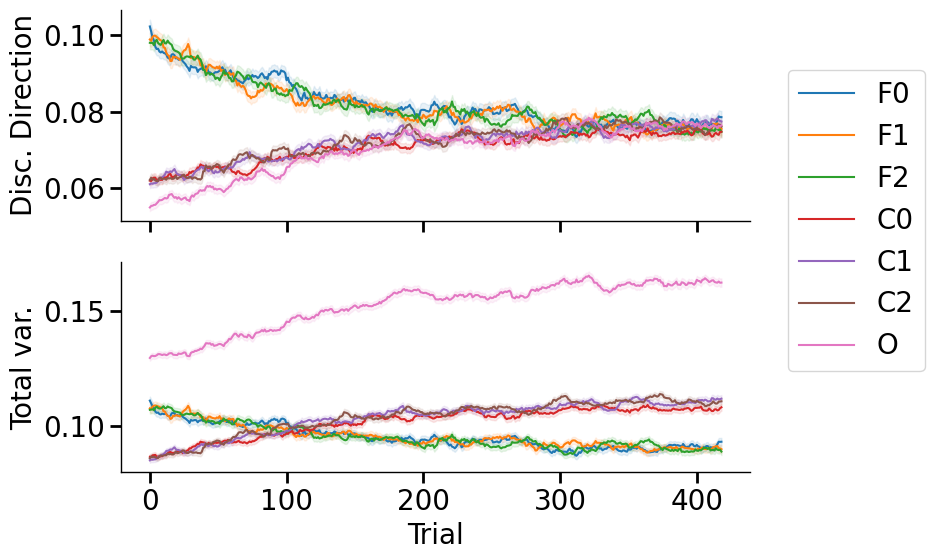

In [1049]:
fig, axes = plt.subplots(2,1, figsize=(8, 6), sharex=True)
_, _ = get_readout_overlap_dynamic(all_model_dpca_choice_out, h2o_gain_mod_avail,
                                   all_saved_states['choices'], all_saved_states['foregone'], 
                                   all_saved_states['model_assignment'], 
                                   all_saved_states['test_stim_dim_order'], axes)
fig.tight_layout()
sns.despine()
lgd = axes[0].legend(bbox_to_anchor=(1.3, 0), loc='center right')

In [42]:
all_model_selectivity_clusters_stim.shape

(8, 80)

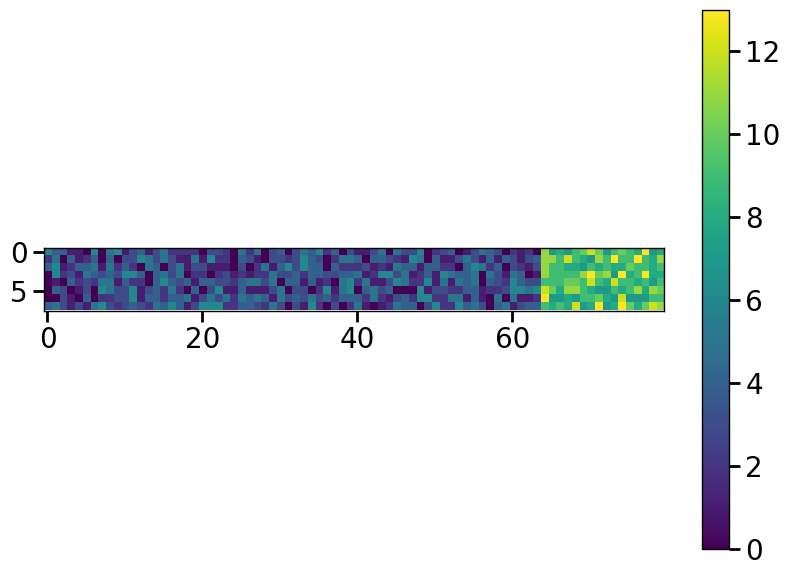

In [43]:
plt.imshow(all_model_selectivity_clusters_stim)
plt.colorbar()

  0%|          | 0/192 [00:00<?, ?it/s]/scratch/f005d7d/ipykernel_2602013/2332360040.py:40: RuntimeWarning: Mean of empty slice
  curr_sess_clus_gains[:,k_idx] = np.nanmean(curr_sess_gains[:,curr_sess_clusters==k_idx], -1)
100%|██████████| 192/192 [00:00<00:00, 2378.82it/s]


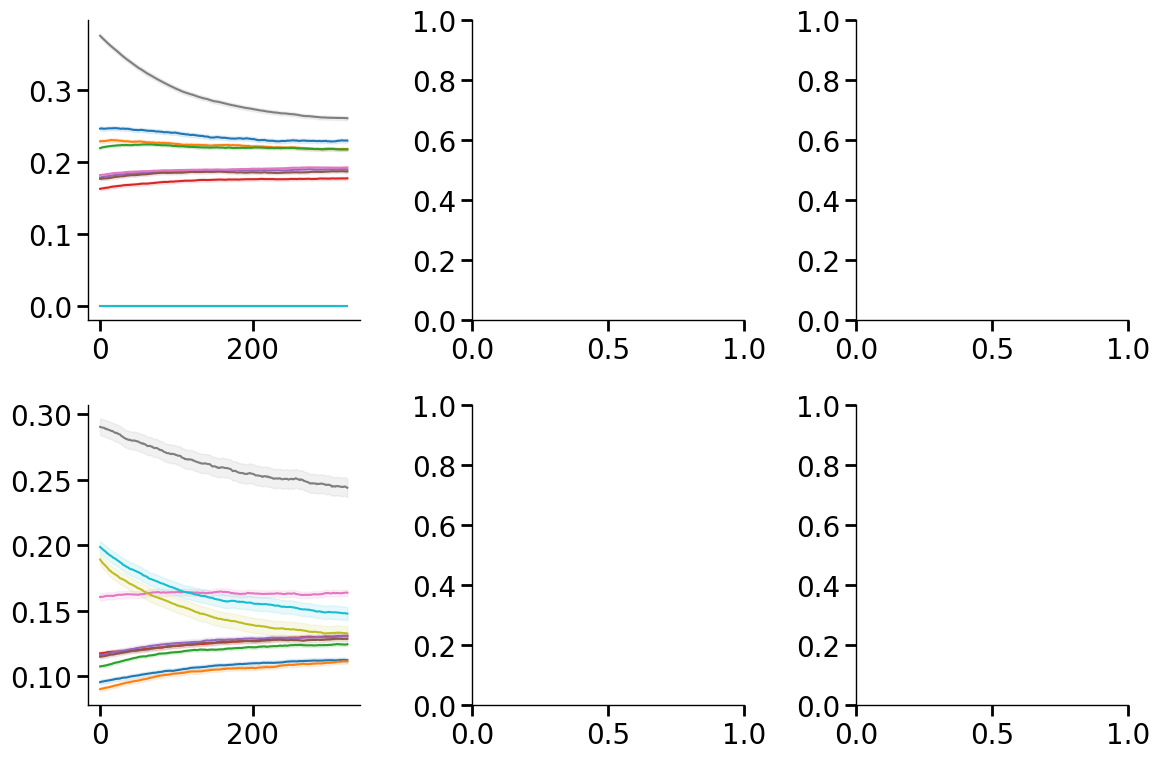

In [106]:
def plot_cluster_gains_dynamic(all_model_clusters, all_sess_gains,
                                all_sess_model_assignment, all_sess_dim_order_reverse, task_mdprl,
                                ax):

    all_sess_clus_gains = []
    
    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
#     dim_labels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O'] + \
#                     [r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$'] + 
                    
    dim_labels = np.unique(all_model_clusters)
    
    for sess_idx in tqdm.tqdm(range(192)):
        
#         if (all_sess_model_assignment[sess_idx]!=2):
#             continue
        
        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]

        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3, [6], 
            np.array(all_sess_dim_order_reverse[sess_idx])+7])
    
        curr_sess_clusters = all_model_clusters[all_sess_model_assignment[sess_idx]]
        
        num_trials = len(all_sess_gains)
        
        curr_sess_clus_gains = np.zeros((num_trials,20))
        
        curr_sess_gains = all_sess_gains[:, sess_idx, :].detach().numpy().copy()
        
        for k_idx, k_name in enumerate(permutted_key_index):
            
            curr_sess_clus_gains[:,k_idx] = np.nanmean(curr_sess_gains[:,curr_sess_clusters==k_idx], -1)

        all_sess_clus_gains.append(curr_sess_clus_gains)
        
    all_sess_clus_gains = np.stack(all_sess_clus_gains, 1)

    
    w_size = 432//4
    
    all_sess_clus_gains = np.nan_to_num(all_sess_clus_gains)
    
    for idx_k in range(10):
        
        smth_exp_var = np.stack([
            np.convolve(all_sess_clus_gains[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(all_sess_clus_gains.shape[1])], axis=1)
        
        plot_mean_and_std(ax=ax,
                      m=np.nanmean(smth_exp_var, 1), 
                      sd=np.nanstd(smth_exp_var, 1)/np.sqrt(192), 
                      label=idx_k, 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
        
#         ax.set_ylim([-ax.get_ylim()[1]*0.1, ax.get_ylim()[1]*1.])
#         ax.set_ylim([-0.1, 0.6])

    fig.tight_layout()
    
    return 

fig, axes = plt.subplots(2,3, figsize=(12, 8))

plot_cluster_gains_dynamic(all_model_selectivity_clusters_choice, 
                            h_gain[...,output_weight_inds],
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[0,0])
plot_cluster_gains_dynamic(all_model_selectivity_clusters_stim, 
                            h_gain[...,input_weight_inds],
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[1,0])

# plot_cluster_gains_dynamic(all_model_selectivity_clusters_out[0], 
#                         h_avg_ch[...,output_weight_inds[:E_SIZE]],
#                         all_saved_states['model_assignment'], 
#                         all_saved_states['test_stim_dim_order'], 
#                         task_mdprl, axes[0,1])

# plot_cluster_gains_dynamic(all_model_selectivity_clusters_ch[0],
#                         h_avg_ch[...,output_weight_inds[:E_SIZE]],
#                         all_saved_states['model_assignment'], 
#                         all_saved_states['test_stim_dim_order'], 
#                         task_mdprl, axes[0,2])
# plot_cluster_gains_dynamic(all_model_selectivity_clusters_ch[1],
#                         h_avg_ch[...,output_weight_inds[E_SIZE:]],
#                         all_saved_states['model_assignment'], 
#                         all_saved_states['test_stim_dim_order'], 
#                         task_mdprl, axes[1,2])

sns.despine()
fig.tight_layout()
plt.show()
    

In [84]:
np.unique(all_model_selectivity_clusters_stim, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([66, 71, 77, 93, 89, 74, 42, 19, 28, 38, 13, 13,  8,  9]))

100%|██████████| 192/192 [00:00<00:00, 3193.21it/s]


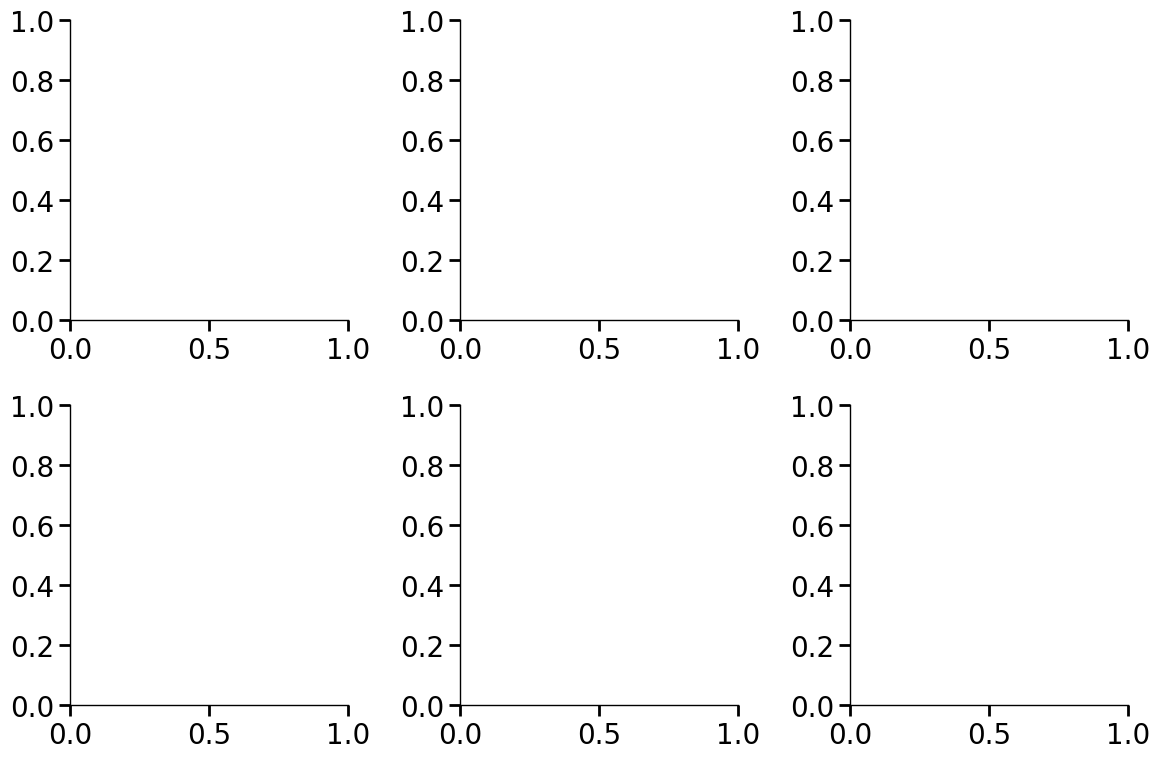

In [85]:
def plot_cluster_gains_by_block(all_model_clusters, all_sess_gains,
                                all_sess_model_assignment, all_sess_dim_order_reverse, task_mdprl,
                                ax):

    all_sess_clus_gains = []
    
    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
#     dim_labels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O'] + \
#                     [r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$'] + 
                    
    dim_labels = np.unique(all_model_clusters)
    num_clusters = 7
    
    for sess_idx in tqdm.tqdm(range(192)):
        
#         if (all_sess_model_assignment[sess_idx]!=2):
#             continue
        
#         permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
#                               [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
#                               [obj_key]

#         permutted_key_index = np.concatenate([
#             np.array(all_sess_dim_order_reverse[sess_idx]), 
#             np.array(all_sess_dim_order_reverse[sess_idx])+3, [6], 
#             np.array(all_sess_dim_order_reverse[sess_idx])+7, 
#         np.array(all_sess_dim_order_reverse[sess_idx])+10, ])

        key_index = np.arange(num_clusters)
    
        curr_sess_clusters = all_model_clusters[all_sess_model_assignment[sess_idx]]
        
        num_trials = len(all_sess_gains)
        
        curr_sess_clus_gains = np.zeros((num_trials,num_clusters))
        
        curr_sess_gains = all_sess_gains[:, sess_idx, :].detach().numpy().copy()
        
        for k_idx, k_name in enumerate(key_index):
            curr_sess_clus_gains[:,k_idx] = np.nanmean(curr_sess_gains[:,curr_sess_clusters==k_idx], -1)

        all_sess_clus_gains.append(curr_sess_clus_gains)
        
    all_sess_clus_gains = np.stack(all_sess_clus_gains, 1)

    
#     w_size = 432//8
    
#     print(np.max(dim_labels))
    
#     for idx_k in range(np.max(dim_labels)):
        
#         smth_exp_var = np.stack([
#             np.convolve(all_sess_clus_gains[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
#                 for idx_sess in range(all_sess_clus_gains.shape[1])], axis=1)
        
#         plot_mean_and_std(ax=ax,
#                       m=np.nanmean(smth_exp_var, 1), 
#                       sd=np.nanstd(smth_exp_var, 1)/np.sqrt(92), 
#                       label=idx_k, 
#                       color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
        
# #         ax.set_ylim([-ax.get_ylim()[1]*0.1, ax.get_ylim()[1]*1.])
# #         ax.set_ylim([-0.1, 0.6])

#     fig.tight_layout()
    
    return all_sess_clus_gains

fig, axes = plt.subplots(2,3, figsize=(12, 8))

cluster_gains_stim = plot_cluster_gains_by_block(all_model_selectivity_clusters_stim, 
                            h_gain[...,input_weight_inds],
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[0,0])
cluster_gains_choice = plot_cluster_gains_by_block(all_model_selectivity_clusters_choice, 
                            h_gain[...,output_weight_inds],
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[1,0])

# plot_cluster_gains_dynamic(all_model_selectivity_clusters_out[0], 
#                         h_avg_ch[...,output_weight_inds[:E_SIZE]],
#                         all_saved_states['model_assignment'], 
#                         all_saved_states['test_stim_dim_order'], 
#                         task_mdprl, axes[0,1])

# plot_cluster_gains_dynamic(all_model_selectivity_clusters_ch[0],
#                         h_avg_ch[...,output_weight_inds[:E_SIZE]],
#                         all_saved_states['model_assignment'], 
#                         all_saved_states['test_stim_dim_order'], 
#                         task_mdprl, axes[0,2])
# plot_cluster_gains_dynamic(all_model_selectivity_clusters_ch[1],
#                         h_avg_ch[...,output_weight_inds[E_SIZE:]],
#                         all_saved_states['model_assignment'], 
#                         all_saved_states['test_stim_dim_order'], 
#                         task_mdprl, axes[1,2])

sns.despine()
fig.tight_layout()
plt.show()
    

In [86]:
all_run_coeffs.shape

(192, 14)

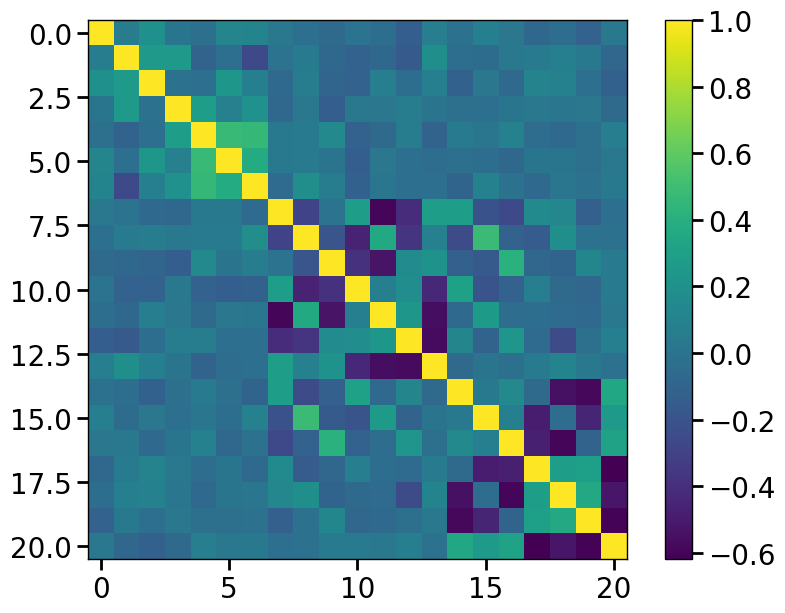

In [87]:
plt.imshow(np.corrcoef(cluster_gains_choice.mean(0).T, all_run_coeffs.T))
plt.colorbar()

In [88]:
cluster_gains_choice.mean(0).shape

(192, 7)

In [89]:
all_run_coeffs.shape

(192, 14)

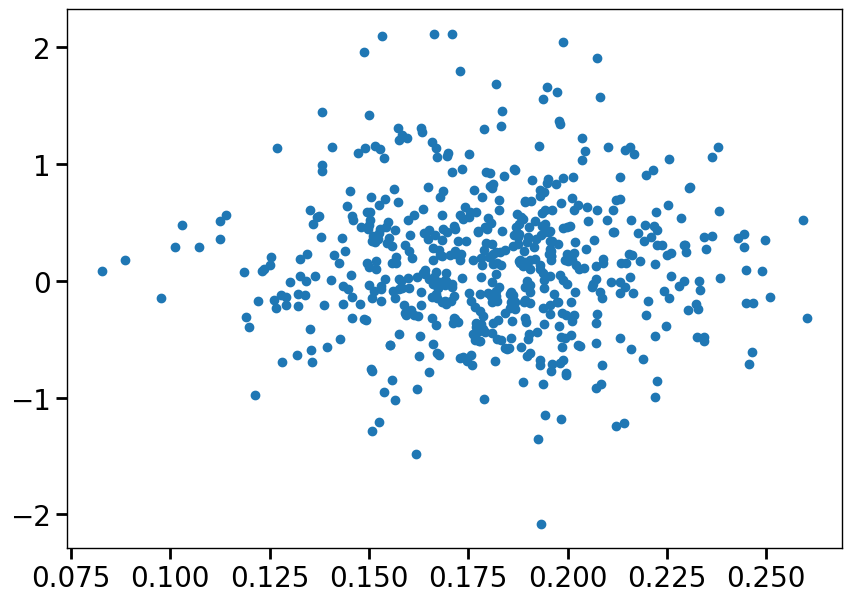

In [90]:
plt.scatter(cluster_gains_choice.mean(0)[:,3:6], all_run_coeffs[:,3:6])

## Recurrence through plastic weights
$$
(I-W_sdiag(\sigma'_{}))^{-1} = \sum_{k=0}^T (W_sdiag(\sigma'_{}))^k \approx W_sdiag(\sigma')
$$

In [91]:
whs_diffs = []


h_stims = all_saved_hs[:,task_mdprl.T_fixation:task_mdprl.T_fixation+task_mdprl.T_stim-1]
h_gain_avg = ((h_stims>0).float()*(1-h_stims**2)).mean(1)

for sess_idx in tqdm.tqdm(range(192)):
    curr_m = all_models[all_saved_states['model_assignment'][sess_idx]]
    whs_diffs.append(curr_m.rnn.h2h.effective_weight(all_saved_states['whs'][:,0,sess_idx])\
                    -curr_m.rnn.h2h.effective_weight().detach())    
    
whs_diffs = np.stack(whs_diffs, axis=1)
whs_diffs_gain_mod = whs_diffs*h_gain_avg[:,:,None,:].numpy()


100%|██████████| 192/192 [00:03<00:00, 54.04it/s]


In [170]:
def get_rec_overlap_dynamic(all_model_dpca_pre, all_model_dpca_post, all_sess_whs,
                            all_sess_chosen, all_sess_foregone,
                            all_sess_model_assignment, all_sess_dim_order_reverse,
                            n_components_for_dpca,
                            ax, w_size):
    all_sess_choice_dir = []
    all_sess_overlap_exp_var = []

    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']
    
    dim_boundaries = np.cumsum([0]+list(n_components_for_dpca.values()))
    final_reparam_whs = []
    
    for sess_idx in tqdm.tqdm(range(192)):

        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]
        
        curr_sess_dpca_pre = all_model_dpca_pre['encoding_axes'][all_sess_model_assignment[sess_idx]]
        curr_sess_pre_axes = np.concatenate([curr_sess_dpca_pre[k] for k in permutted_key_order], axis=-1)
        curr_sess_dpca_post = all_model_dpca_post['encoding_axes'][all_sess_model_assignment[sess_idx]]
        curr_sess_post_axes = np.concatenate([curr_sess_dpca_post[k] for k in permutted_key_order], axis=-1)
        
        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3, [6]])
        
        curr_sess_exp_var = np.zeros((432,7))
        curr_sess_choice_dir = np.zeros((432,7))
        
        stim_chosen_FCO = obj_to_ft_conj(all_sess_chosen[...,sess_idx], task_mdprl).squeeze()
        stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]
        stim_foregone_FCO = obj_to_ft_conj(all_sess_foregone[...,sess_idx], task_mdprl).squeeze()
        stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
                
        for idx_trial in range(432):
            wh_reparam = curr_sess_post_axes.T@all_sess_whs[idx_trial, sess_idx]@curr_sess_pre_axes
            for k_idx, k_name in enumerate(permutted_key_order):
                curr_sess_exp_var[idx_trial,k_idx] = \
                    (wh_reparam[dim_boundaries[k_idx]:dim_boundaries[k_idx+1]]**2).sum() #/wh_reparam.shape[-1]


        final_reparam_whs.append(wh_reparam)
        all_sess_overlap_exp_var.append(curr_sess_exp_var)
        
#     all_sess_choice_dir = np.stack(all_sess_choice_dir, 1)
    final_reparam_whs = np.stack(final_reparam_whs, 0)
    all_sess_overlap_exp_var = np.stack(all_sess_overlap_exp_var, 1)
#     all_sess_overlap_exp_var_within = np.diagonal(all_sess_overlap_exp_var, axis1=-2, axis2=-1)

    smth_exp_var = []
    for idx_k in range(7):
        smth_exp_var.append(np.stack([
            np.convolve(all_sess_overlap_exp_var[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(192)
        ], axis=1))
        
    smth_exp_var = np.stack(smth_exp_var, -1)
    
    colormap = np.concatenate([mpl.colormaps['Blues']([180, 100, 50]), 
                       mpl.colormaps['Reds']([180, 100, 50]), 
                       mpl.colormaps['Purples']([180])])

    for idx_k in range(7):
        plot_mean_and_std(ax=ax,
                      m=smth_exp_var[...,idx_k].mean(1), 
                      sd=smth_exp_var[...,idx_k].std(1)/np.sqrt(192),
                      label=dim_labels[idx_k], 
                      color=colormap[idx_k]*np.array([1,1,1,1]))
    
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [smth_exp_var[...,0].T, smth_exp_var[...,1].T, smth_exp_var[...,2].T],
        n_permutations=1000,
        n_jobs=None,
        verbose=False,
    )
    
    sig_dot_y = -ax.get_ylim()[1]*0.05
    for (clus, clus_p) in zip(clusters, cluster_p_values):
        if clus_p<0.05:
            ax.scatter(clus, sig_dot_y*np.ones_like(clus), color='tab:blue', s=1)
    
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [smth_exp_var[...,3].T, smth_exp_var[...,4].T, smth_exp_var[...,5].T],
        n_permutations=1000,
        n_jobs=None,
        verbose=False,
    )
    
    sig_dot_y *= 2
    for (clus, clus_p) in zip(clusters, cluster_p_values):
        if clus_p<0.05:
            ax.scatter(clus, sig_dot_y*np.ones_like(clus), color='tab:red', s=1)
    
    
    return final_reparam_whs
        

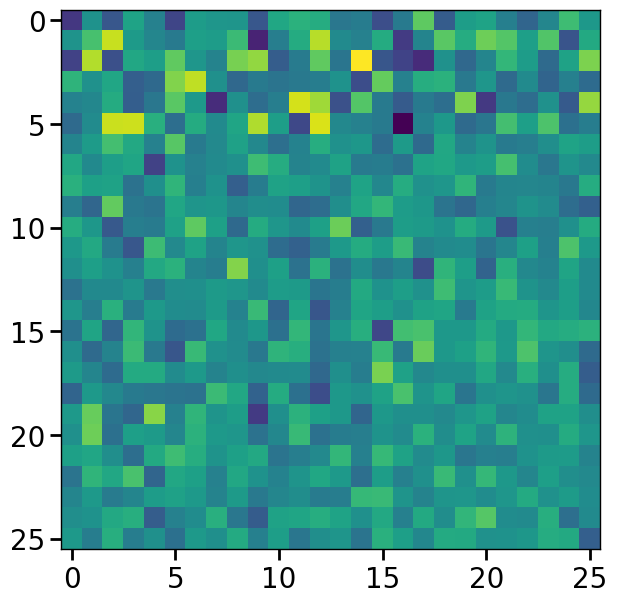

In [149]:
plt.imshow(reparam_dw_ff[3])

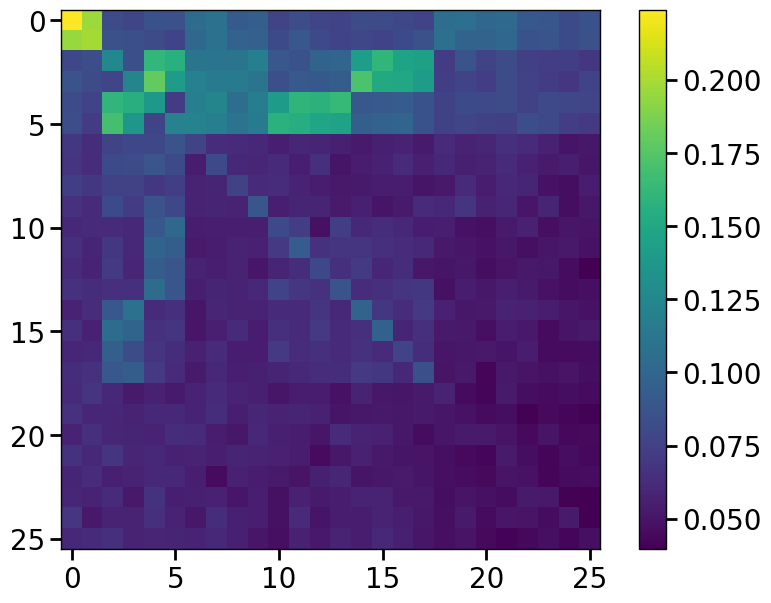

In [157]:
plt.imshow(np.abs(reparam_dw_ff).mean(0))
plt.colorbar()

100%|██████████| 192/192 [00:21<00:00,  9.03it/s]
/scratch/f005d7d/ipykernel_2602013/452181869.py:72: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/f005d7d/ipykernel_2602013/452181869.py:84: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/f005d7d/ipykernel_2602013/452181869.py:84: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| 192/192 [00:20<00:00,  9.29it/s]
/scratch/f005d7d/ipykernel_2602013/452181869.py:72: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/f005d7d/ipykernel_2602013/452181869.py:72: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

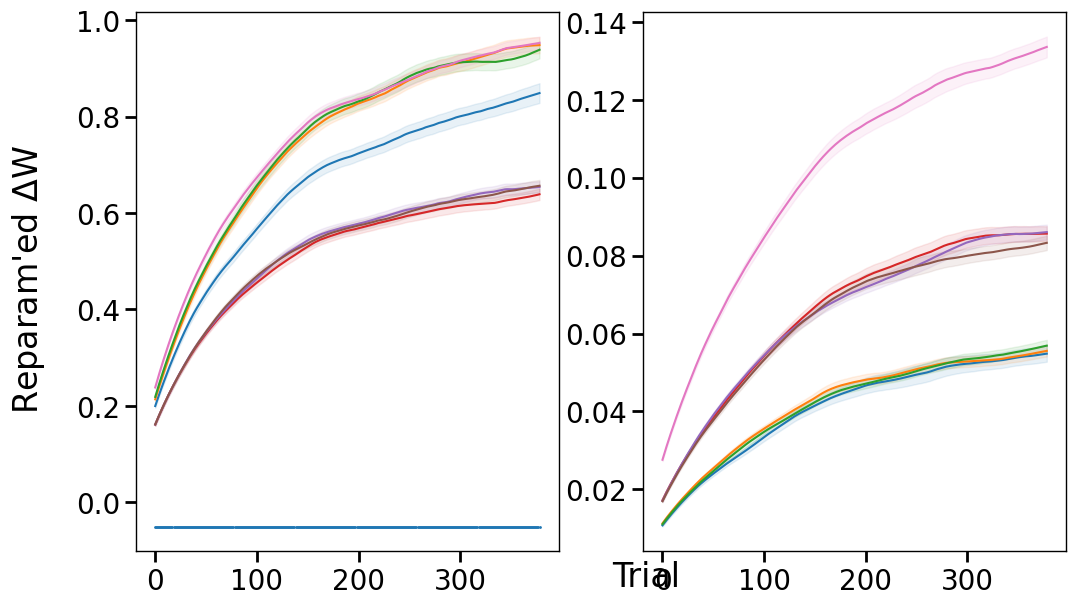

In [154]:
fig, axes = plt.subplots(1,2,figsize=(12,7),sharex=True)

w_size = 432//8

reparam_dw_ff = get_rec_overlap_dynamic(all_model_dpca_stim_in, all_model_dpca_choice_out, 
                            whs_diffs[...,output_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],n_components_for_dpca,
                            axes[0], w_size)

# reparam_dw_fb = get_rec_overlap_dynamic(all_model_dpca_stim_in, all_model_dpca_choice_in, 
#                             whs_diffs[...,output_weight_inds,:][...,input_weight_inds],
#                             all_saved_states['choices'], all_saved_states['foregone'], 
#                             all_saved_states['model_assignment'], 
#                             all_saved_states['test_stim_dim_order'],n_components_for_dpca,
#                             axes[1], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_choice_out, all_model_dpca_stim_in, 
                            whs_diffs[...,input_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],n_components_for_dpca,
                            axes[1], w_size)

# _ = get_rec_overlap_dynamic(all_model_dpca_choice_in, all_model_dpca_stim_in, 
#                             whs_diffs[...,input_weight_inds,:][...,output_weight_inds],
#                             all_saved_states['choices'], all_saved_states['foregone'], 
#                             all_saved_states['model_assignment'], 
#                             all_saved_states['test_stim_dim_order'],n_components_for_dpca,
#                             axes[1,1], w_size)


fig.supylabel(r"Reparam'ed $\Delta W$")
fig.supxlabel('Trial', x=0.55, y=0.05)

axes[0,0].set_title('Input->Output')
axes[1,0].set_title('Input->Choice')
axes[0,1].set_title('Output->Input')
axes[1,1].set_title('Choice->Input')

plt.tight_layout()
sns.despine()

with PdfPages(f'plots/{plot_save_dir}/dw_by_subspace.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/dw_by_subspace.pdf')



100%|██████████| 192/192 [00:22<00:00,  8.47it/s]
/scratch/f005d7d/ipykernel_2602013/3419137090.py:76: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/f005d7d/ipykernel_2602013/3419137090.py:88: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| 192/192 [00:24<00:00,  7.97it/s]
/scratch/f005d7d/ipykernel_2602013/3419137090.py:76: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/f005d7d/ipykernel_2602013/3419137090.py:88: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Figure saved at plots/exp/test1/dw_gain_mod_by_subspace.pdf


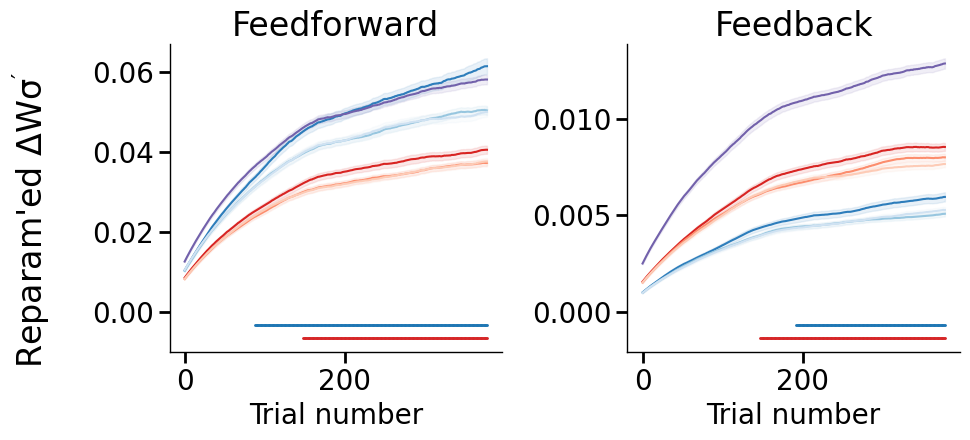

In [171]:
fig, axes = plt.subplots(1,2,figsize=(10,4.8),sharex=True)


w_size = 432//8


reparam_dw_gain_ff = get_rec_overlap_dynamic(all_model_dpca_stim_in, all_model_dpca_choice_out, 
                            whs_diffs_gain_mod[...,output_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],n_components_for_dpca,
                            axes[0], w_size)

reparam_dw_gain_fb = get_rec_overlap_dynamic(all_model_dpca_choice_out, all_model_dpca_stim_in, 
                            whs_diffs_gain_mod[...,input_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],n_components_for_dpca,
                            axes[1], w_size)

# _ = get_rec_overlap_dynamic(all_model_dpca_choice_out, all_model_dpca_stim_in, 
#                             whs_diffs_gain_mod[...,input_weight_inds,:][...,output_weight_inds],
#                             all_saved_states['choices'], all_saved_states['foregone'], 
#                             all_saved_states['model_assignment'], 
#                             all_saved_states['test_stim_dim_order'],n_components_for_dpca,
#                             axes[0,1], w_size)

# _ = get_rec_overlap_dynamic(all_model_dpca_choice_in, all_model_dpca_stim_in, 
#                             whs_diffs_gain_mod[...,input_weight_inds,:][...,output_weight_inds],
#                             all_saved_states['choices'], all_saved_states['foregone'], 
#                             all_saved_states['model_assignment'], 
#                             all_saved_states['test_stim_dim_order'],n_components_for_dpca,
#                             axes[1,1], w_size)


fig.supylabel(r"Reparam'ed $\Delta W\sigma^\prime$")
axes[0].set_xlabel('Trial number')
axes[1].set_xlabel('Trial number')

axes[0].set_title('Feedforward')
axes[1].set_title('Feedback')
# axes[0,1].set_title('Output->Input')
# axes[1,1].set_title('Choice->Input')


plt.tight_layout()
sns.despine()

with PdfPages(f'plots/{plot_save_dir}/dw_gain_mod_by_subspace.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/dw_gain_mod_by_subspace.pdf')


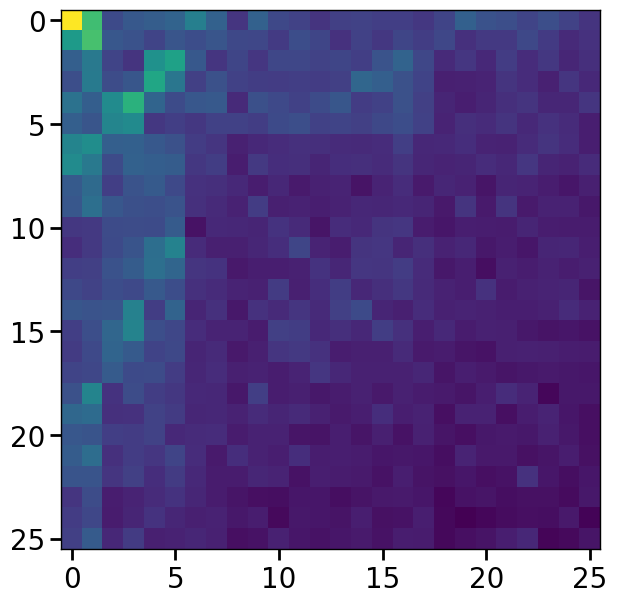

In [160]:
plt.imshow((reparam_dw_gain_fb**2).mean(0))

## Routing through alignment
$$
(A\odot(h_{s-1}h_{s-1}^{\top}))h_s
$$

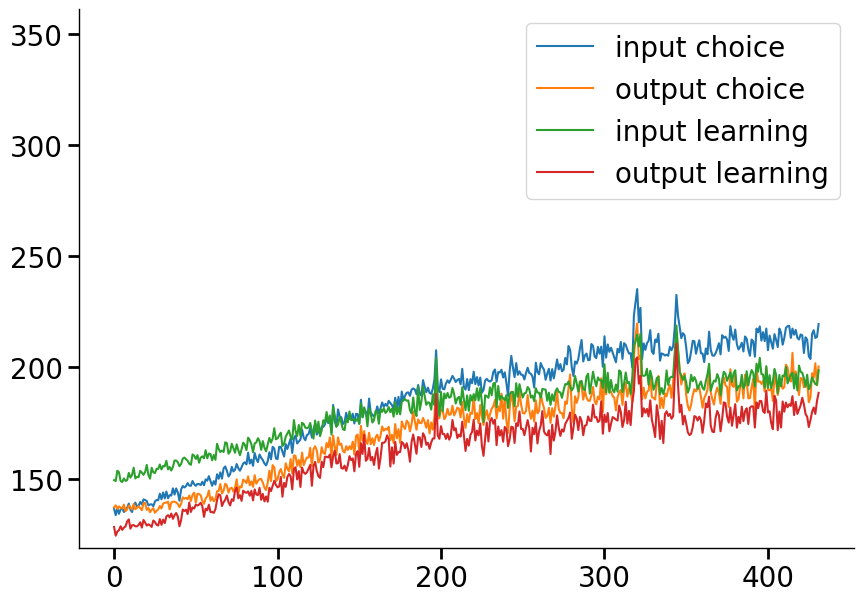

In [100]:
plt.plot((h_avg_ch[...,input_weight_inds]**2).sum(-1).mean(1), label='input choice')
plt.plot((h_avg_ch[...,output_weight_inds]**2).sum(-1).mean(1), label='output choice')
plt.plot((h_avg_lrn[...,input_weight_inds]**2).sum(-1).mean(1), label='input learning')
plt.plot((h_avg_lrn[...,output_weight_inds]**2).sum(-1).mean(1), label='output learning')
plt.ylim([plt.ylim()[0], plt.ylim()[1]*1.5])
plt.legend()
sns.despine()

In [50]:
def plot_hs_exp_var_dynamic(all_model_dpca, all_sess_hs, all_sess_chosen, all_sess_foregone,
                            all_sess_model_assignment, all_sess_dim_order_reverse, task_mdprl,
                            ax):

    all_sess_choice_proj = []
    all_sess_exp_var = []
    
    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']
    
    num_sessions = all_sess_chosen.shape[-1]
    
    for sess_idx in tqdm.tqdm(range(num_sessions)):
        
#         if (all_sess_model_assignment[sess_idx]!=2):
#             continue
        
        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]

        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3, [6]])
    
        curr_sess_dpca_psth = all_model_dpca['marginalized_psth'][all_sess_model_assignment[sess_idx]]
        curr_sess_dpca_encoding_axes = all_model_dpca['encoding_axes'][all_sess_model_assignment[sess_idx]]
        
        num_trials = len(all_sess_chosen)
        
        curr_sess_choice_proj = np.zeros((num_trials,7))
        curr_sess_exp_var = np.zeros((num_trials,7))
        
        curr_sess_better = np.empty_like(all_sess_chosen[...,sess_idx])*np.nan
        curr_sess_worse = np.empty_like(all_sess_chosen[...,sess_idx])*np.nan

        curr_sess_correct = all_saved_states['choose_better'][...,sess_idx]
        curr_sess_chosen = all_sess_chosen[...,sess_idx].long()
        curr_sess_foregone = all_sess_foregone[...,sess_idx].long()
                
        curr_sess_better[curr_sess_correct>0.5] = curr_sess_chosen[curr_sess_correct>0.5]
        curr_sess_better[curr_sess_correct<0.5] = curr_sess_foregone[curr_sess_correct<0.5]
        curr_sess_better = curr_sess_better.astype(int)
        
        curr_sess_worse[curr_sess_correct>0.5] = curr_sess_foregone[curr_sess_correct>0.5]
        curr_sess_worse[curr_sess_correct<0.5] = curr_sess_chosen[curr_sess_correct<0.5]
        curr_sess_worse = curr_sess_worse.astype(int)
        
        stim_chosen_FCO = obj_to_ft_conj(curr_sess_chosen, task_mdprl).squeeze()
#         stim_chosen_FCO = obj_to_ft_conj(curr_sess_better, task_mdprl).squeeze()
        stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]

        stim_foregone_FCO = obj_to_ft_conj(curr_sess_foregone, task_mdprl).squeeze()
#         stim_foregone_FCO = obj_to_ft_conj(curr_sess_worse, task_mdprl).squeeze()
        stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
        
        curr_sess_hs = all_sess_hs[:, sess_idx, :].detach().numpy().copy()
#         curr_sess_hs -= curr_sess_hs.mean(-1, keepdims=True)
        
        for k_idx, k_name in enumerate(permutted_key_order):
                        
            curr_sess_dim_psth = curr_sess_dpca_psth[k_name].squeeze()[:].reshape((args['hidden_size'], -1))
            
            chosen_direction = curr_sess_dim_psth[:,stim_chosen_FCO[:,k_idx]]
#             chosen_direction = chosen_direction/np.linalg.norm(chosen_direction, axis=0, keepdims=True)
            foregone_direction = curr_sess_dim_psth[:,stim_foregone_FCO[:,k_idx]]            
#             foregone_direction = foregone_direction/np.linalg.norm(foregone_direction, axis=0, keepdims=True)
            choice_direction = (chosen_direction-foregone_direction)
            choice_direction = choice_direction/(np.linalg.norm(choice_direction, axis=0, keepdims=True)+1e-10)
        
            
            h_choice_proj = (curr_sess_hs*choice_direction.T).sum(1)
            h_reparam = (curr_sess_hs@curr_sess_dpca_encoding_axes[k_name])
            
            curr_sess_choice_proj[:,k_idx] = np.abs(h_choice_proj)/(np.linalg.norm(curr_sess_hs, axis=1)+1e-6)
            curr_sess_exp_var[:,k_idx] = (h_reparam**2).sum(1)/(np.linalg.norm(curr_sess_hs, axis=1)**2+1e-6)

        all_sess_choice_proj.append(curr_sess_choice_proj)
        all_sess_exp_var.append(curr_sess_exp_var)
        
    all_sess_choice_proj = np.stack(all_sess_choice_proj, 1)
    
#     all_sess_choice_proj[:,:,:3] -= all_sess_choice_proj[:,:,:3].mean(-1, keepdims=True)
#     all_sess_choice_proj[:,:,3:6] -= all_sess_choice_proj[:,:,3:6].mean(-1, keepdims=True)
    
    all_sess_exp_var = np.stack(all_sess_exp_var, 1)
    all_sess_smth_exp_var = []
    
    w_size = 432//8
    
    colormap = np.concatenate([mpl.colormaps['Blues']([180, 100, 50]), 
                       mpl.colormaps['Reds']([180, 100, 50]), 
                       mpl.colormaps['Purples']([180])])
    
    for idx_k in range(7):
        
        smth_exp_var = np.stack([
            np.convolve(all_sess_choice_proj[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(all_sess_choice_proj.shape[1])], axis=1)
        
        plot_mean_and_std(ax=ax,
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(num_sessions), 
                      label=dim_labels[idx_k], 
                      color=colormap[idx_k])
        
#         ax.set_ylim([-ax.get_ylim()[1]*0.1, ax.get_ylim()[1]*1.])
#         ax.set_ylim([-0.1, 0.6])

        all_sess_smth_exp_var.append(smth_exp_var)
    
    all_sess_smth_exp_var = np.stack(all_sess_smth_exp_var, -1)

    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [all_sess_smth_exp_var[...,0].T, all_sess_smth_exp_var[...,1].T, all_sess_smth_exp_var[...,2].T],
        n_permutations=1000,
        n_jobs=None,
        verbose=False,
    )
        
    sig_dot_y = ax.get_ylim()[0]-(ax.get_ylim()[1]-ax.get_ylim()[0])*0.1
    for (clus, clus_p) in zip(clusters, cluster_p_values):
        if clus_p<0.05:
            ax.scatter(clus, sig_dot_y*np.ones_like(clus), color='tab:blue', s=1)
    
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [all_sess_smth_exp_var[...,3].T, all_sess_smth_exp_var[...,4].T, all_sess_smth_exp_var[...,5].T],
        n_permutations=1000,
        n_jobs=None,
        verbose=False,
    )
        
    sig_dot_y *= 1.05
    for (clus, clus_p) in zip(clusters, cluster_p_values):
        if clus_p<0.05:
            ax.scatter(clus, sig_dot_y*np.ones_like(clus), color='tab:red', s=1)

    fig.tight_layout()
    
    return all_sess_choice_proj
    
    

100%|██████████| 192/192 [00:00<00:00, 488.38it/s]
/scratch/f005d7d/ipykernel_2602013/913355718.py:117: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/f005d7d/ipykernel_2602013/913355718.py:129: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| 192/192 [00:00<00:00, 579.49it/s]
/scratch/f005d7d/ipykernel_2602013/913355718.py:117: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/f005d7d/ipykernel_2602013/913355718.py:129: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| 192/192 [00:00<00:00, 579.55it/s]
/scratch/f005d7d/ipykernel_2602013/913355718.py:117: RuntimeWarning: Ignoring argument 

Figure saved at plots/exp/test1/activity_subspace_proj.pdf


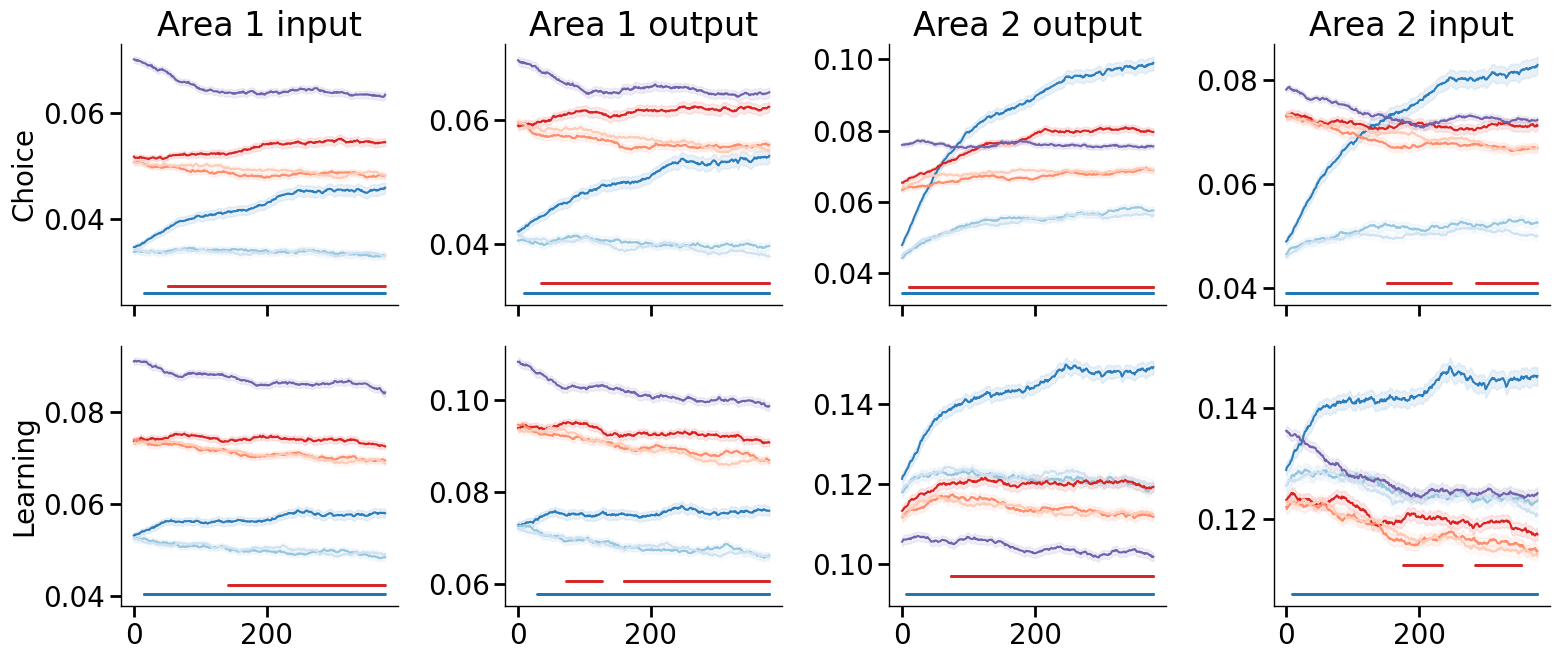

In [51]:
fig, axes = plt.subplots(2,4, figsize=(16,7), sharex=True)

h_avg_ch = all_saved_states['hs'][:,task_mdprl.T_fixation+task_mdprl.T_stim-1,:,:] 
# activity at steady state of choice feedback phase
h_avg_lrn =  all_saved_states['hs'][:,-1,:,:]

all_sess_choice_proj_in_ch = plot_hs_exp_var_dynamic(all_model_dpca_stim_in, h_avg_ch[...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[0,0])

all_sess_choice_proj_in_ch = plot_hs_exp_var_dynamic(all_model_dpca_stim_out, h_avg_ch[...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[0,1])

all_sess_choice_proj_out_ch = plot_hs_exp_var_dynamic(all_model_dpca_choice_out, h_avg_ch[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[0,2])

all_sess_choice_proj_ch_ch = plot_hs_exp_var_dynamic(all_model_dpca_choice_in, h_avg_ch[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[0,3])

all_sess_choice_proj_in_lrn = plot_hs_exp_var_dynamic(all_model_dpca_stim_in, h_avg_lrn[...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[1,0])

all_sess_choice_proj_in_lrn = plot_hs_exp_var_dynamic(all_model_dpca_stim_out, h_avg_lrn[...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[1,1])


all_sess_choice_proj_out_lrn = plot_hs_exp_var_dynamic(all_model_dpca_choice_out, h_avg_lrn[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[1,2])

all_sess_choice_proj_ch_lrn = plot_hs_exp_var_dynamic(all_model_dpca_choice_in, h_avg_lrn[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[1,3])

axes[0,0].set_ylabel('Choice')
axes[1,0].set_ylabel('Learning')

axes[0,0].set_title('Area 1 input')
axes[0,1].set_title('Area 1 output')
axes[0,2].set_title('Area 2 output')
axes[0,3].set_title('Area 2 input')

sns.despine()
plt.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/activity_subspace_proj.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/activity_subspace_proj.pdf')
    

100%|██████████| 192/192 [00:00<00:00, 457.25it/s]
/scratch/f005d7d/ipykernel_2531351/913355718.py:117: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/f005d7d/ipykernel_2531351/913355718.py:129: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| 192/192 [00:00<00:00, 546.09it/s]
/scratch/f005d7d/ipykernel_2531351/913355718.py:117: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/f005d7d/ipykernel_2531351/913355718.py:129: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| 192/192 [00:00<00:00, 469.29it/s]
/scratch/f005d7d/ipykernel_2531351/913355718.py:117: RuntimeWarning: Ignoring argument 

Figure saved at plots/exp/test1/activity_subspace_proj_simple.pdf


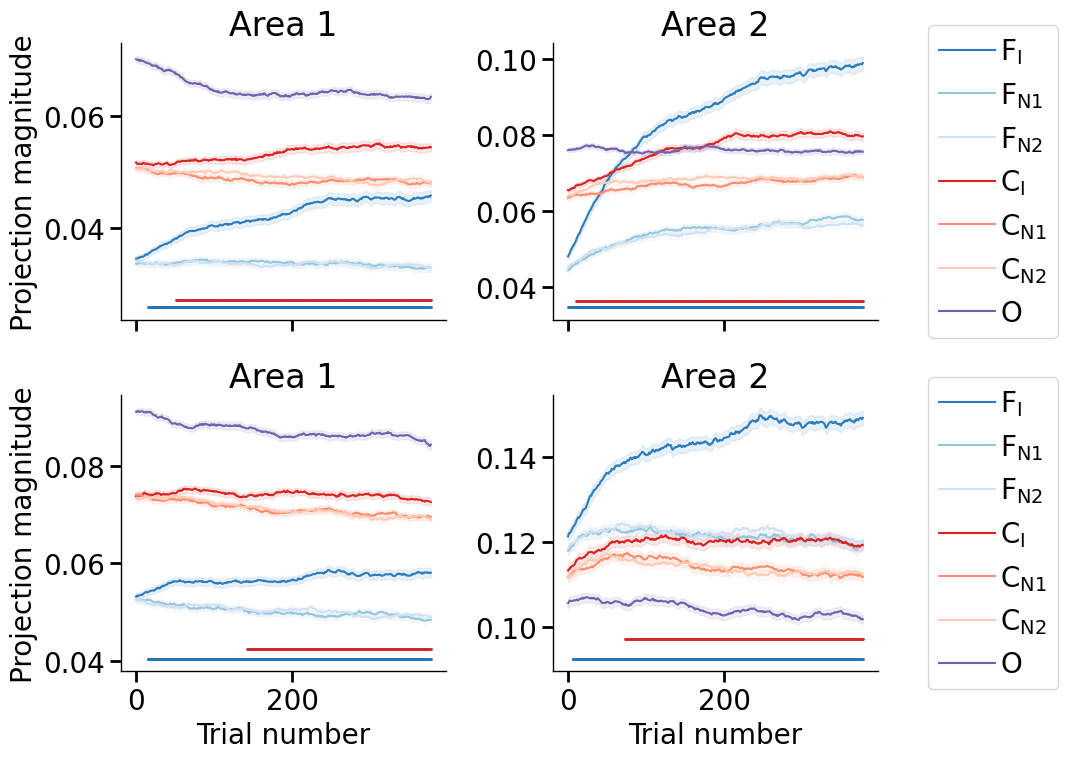

In [86]:
fig, axes = plt.subplots(2,2, figsize=(12,8), sharex=True)


all_sess_choice_proj_in_ch = plot_hs_exp_var_dynamic(all_model_dpca_stim_in, h_avg_ch[...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[0,0])


all_sess_choice_proj_out_ch = plot_hs_exp_var_dynamic(all_model_dpca_choice_out, h_avg_ch[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[0,1])

all_sess_choice_proj_in_ch = plot_hs_exp_var_dynamic(all_model_dpca_stim_in, h_avg_lrn[...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[1,0])


all_sess_choice_proj_out_ch = plot_hs_exp_var_dynamic(all_model_dpca_choice_out, h_avg_lrn[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[1,1])


axes[0,1].legend(loc='right', bbox_to_anchor=(1.6, 0.5), columnspacing=1, handletextpad=0.2, ncols=1, frameon=True)
axes[1,1].legend(loc='right', bbox_to_anchor=(1.6, 0.5), columnspacing=1, handletextpad=0.2, ncols=1, frameon=True)

axes[0,0].set_ylabel('Projection magnitude')
axes[1,0].set_ylabel('Projection magnitude')
axes[1,0].set_xlabel('Trial number')
axes[1,1].set_xlabel('Trial number')

axes[0,0].set_title('Area 1')
axes[0,1].set_title('Area 2')

axes[1,0].set_title('Area 1')
axes[1,1].set_title('Area 2')


sns.despine()
fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/activity_subspace_proj_simple.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/activity_subspace_proj_simple.pdf')



In [88]:
def plot_proj_behav_corr(all_model_dpca, all_sess_hs, all_sess_chosen, all_sess_foregone,
                         all_sess_model_assignment, all_sess_credit_assignment_coeffs, task_mdprl):

    all_sess_choice_proj = []
    all_sess_exp_var = []
    
    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key=['spc']
    
    dim_labels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']
    
    for sess_idx in tqdm.tqdm(range(192)):
        
#         if (all_sess_model_assignment[sess_idx]!=2):
#             continue
        
        key_order = ft_keys + conj_keys + obj_key

#         permutted_key_index = np.concatenate([
#             np.array(all_sess_dim_order_reverse[sess_idx]), 
#             np.array(all_sess_dim_order_reverse[sess_idx])+3, [6]])
    
        curr_sess_dpca_psth = all_model_dpca['marginalized_psth'][all_sess_model_assignment[sess_idx]]
        curr_sess_encoding_axes = all_model_dpca['encoding_axes'][all_sess_model_assignment[sess_idx]]
        
        num_trials = len(all_sess_chosen)
        num_timesteps = all_sess_hs.shape[1]
        
        curr_sess_choice_proj = np.zeros((num_trials,7))
        curr_sess_exp_var = np.zeros((num_trials,7))
        
        curr_sess_better = np.empty_like(all_sess_chosen[...,sess_idx])*np.nan
        curr_sess_worse = np.empty_like(all_sess_chosen[...,sess_idx])*np.nan

        curr_sess_correct = all_saved_states['choose_better'][...,sess_idx]
        curr_sess_chosen = all_sess_chosen[...,sess_idx].long()
        curr_sess_foregone = all_sess_foregone[...,sess_idx].long()
                
        curr_sess_better[curr_sess_correct>0.5] = curr_sess_chosen[curr_sess_correct>0.5]
        curr_sess_better[curr_sess_correct<0.5] = curr_sess_foregone[curr_sess_correct<0.5]
        curr_sess_better = curr_sess_better.astype(int)
        
        curr_sess_worse[curr_sess_correct>0.5] = curr_sess_foregone[curr_sess_correct>0.5]
        curr_sess_worse[curr_sess_correct<0.5] = curr_sess_chosen[curr_sess_correct<0.5]
        curr_sess_worse = curr_sess_worse.astype(int)
        
        stim_chosen_FCO = obj_to_ft_conj(curr_sess_chosen, task_mdprl).squeeze()
#         stim_chosen_FCO = obj_to_ft_conj(curr_sess_better, task_mdprl).squeeze()
#         stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]

        stim_foregone_FCO = obj_to_ft_conj(curr_sess_foregone, task_mdprl).squeeze()
#         stim_foregone_FCO = obj_to_ft_conj(curr_sess_worse, task_mdprl).squeeze()
#         stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
        
        curr_sess_hs = all_sess_hs[:, sess_idx, :].detach().numpy().copy()
#         curr_sess_hs -= curr_sess_hs.mean(-1, keepdims=True)
        
        for k_idx, k_name in enumerate(key_order):
                                    
            curr_sess_dim_psth = curr_sess_dpca_psth[k_name].squeeze()[:].reshape((args['hidden_size'], -1))
            
            chosen_direction = curr_sess_dim_psth[:,stim_chosen_FCO[:,k_idx]]
#             chosen_direction = chosen_direction/np.linalg.norm(chosen_direction, axis=0, keepdims=True)
            foregone_direction = curr_sess_dim_psth[:,stim_foregone_FCO[:,k_idx]]            
#             foregone_direction = foregone_direction/np.linalg.norm(foregone_direction, axis=0, keepdims=True)
            choice_direction = (chosen_direction-foregone_direction)
            choice_direction = choice_direction/(np.linalg.norm(choice_direction, axis=0, keepdims=True)+1e-10)
        

            h_choice_proj = (curr_sess_hs*choice_direction.T).sum(1)
            h_reparam = (curr_sess_hs@curr_sess_encoding_axes[k_name])
            
            curr_sess_choice_proj[:,k_idx] = np.abs(h_choice_proj)/(np.linalg.norm(curr_sess_hs, axis=1)+1e-6)
            curr_sess_exp_var[:,k_idx] = (h_reparam**2).sum(1)/(np.linalg.norm(curr_sess_hs, axis=1)**2+1e-6)

        all_sess_choice_proj.append(curr_sess_choice_proj)
        all_sess_exp_var.append(curr_sess_exp_var)
        
    all_sess_choice_proj = np.stack(all_sess_choice_proj, 1)
    all_sess_exp_var = np.stack(all_sess_exp_var, 1)
    
    
#     for idx_k in range(7):
        
# #         smth_exp_var = np.stack([
# #             np.convolve(all_sess_choice_proj[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
# #                 for idx_sess in range(all_sess_choice_proj.shape[1])], axis=1)
        
#         plot_mean_and_std(ax=ax,
#                       m=all_sess_choice_proj[:,:,:,idx_k].mean((0,1)), 
#                       sd=all_sess_choice_proj[:,:,:,idx_k].mean(0).std(0)/np.sqrt(92), 
#                       label=dim_labels[idx_k], 
#                       color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
        
# #         ax.set_ylim([-ax.get_ylim()[1]*0.1, ax.get_ylim()[1]*1.])
# #         ax.set_ylim([-0.1, 0.6])

#         ax.axvline(task_mdprl.T_fixation-1, ls=':', color='lightgrey')
#         ax.axvline(task_mdprl.T_stim+task_mdprl.T_fixation-1, ls=':', color='lightgrey')
#         ax.axvline(task_mdprl.T_stim+task_mdprl.T_fixation+task_mdprl.T_ch-1, ls=':', color='lightgrey')

#     fig.tight_layout()
    
    return all_sess_choice_proj
    

In [89]:
all_sess_choice_proj_choice_ch = plot_proj_behav_corr(all_model_dpca_choice_out, h_avg_ch[...,output_weight_inds],
                                                all_saved_states['choices'], all_saved_states['foregone'], 
                                                all_saved_states['model_assignment'], 
                                                all_run_coeffs, task_mdprl)

all_sess_choice_proj_stim_ch = plot_proj_behav_corr(all_model_dpca_stim_in, h_avg_ch[...,input_weight_inds],
                                                all_saved_states['choices'], all_saved_states['foregone'], 
                                                all_saved_states['model_assignment'], 
                                                all_run_coeffs, task_mdprl)


all_sess_choice_proj_choice_lrn = plot_proj_behav_corr(all_model_dpca_choice_out, h_avg_lrn[...,output_weight_inds],
                                                all_saved_states['choices'], all_saved_states['foregone'], 
                                                all_saved_states['model_assignment'], 
                                                all_run_coeffs, task_mdprl)

all_sess_choice_proj_stim_lrn = plot_proj_behav_corr(all_model_dpca_stim_in, h_avg_lrn[...,input_weight_inds],
                                                all_saved_states['choices'], all_saved_states['foregone'], 
                                                all_saved_states['model_assignment'], 
                                                all_run_coeffs, task_mdprl)

100%|██████████| 192/192 [00:00<00:00, 481.63it/s]


SignificanceResult(statistic=0.3105476854293824, pvalue=2.4157097803346307e-14)
SignificanceResult(statistic=0.559394921256876, pvalue=9.852527751471016e-49)
SignificanceResult(statistic=0.2396401301082561, pvalue=5.747607493807941e-09)
SignificanceResult(statistic=0.4785051993067591, pvalue=2.690357738680738e-34)
SignificanceResult(statistic=0.15800473463441592, pvalue=0.00014019674541981662)
SignificanceResult(statistic=0.24044683897219504, pvalue=5.091909752528463e-09)
SignificanceResult(statistic=0.13893759576017886, pvalue=0.0008273219204716932)
SignificanceResult(statistic=0.06783877125562003, pvalue=0.1038501802396754)
Figure saved at plots/exp/test1/subspace_proj_behav_corr.pdf


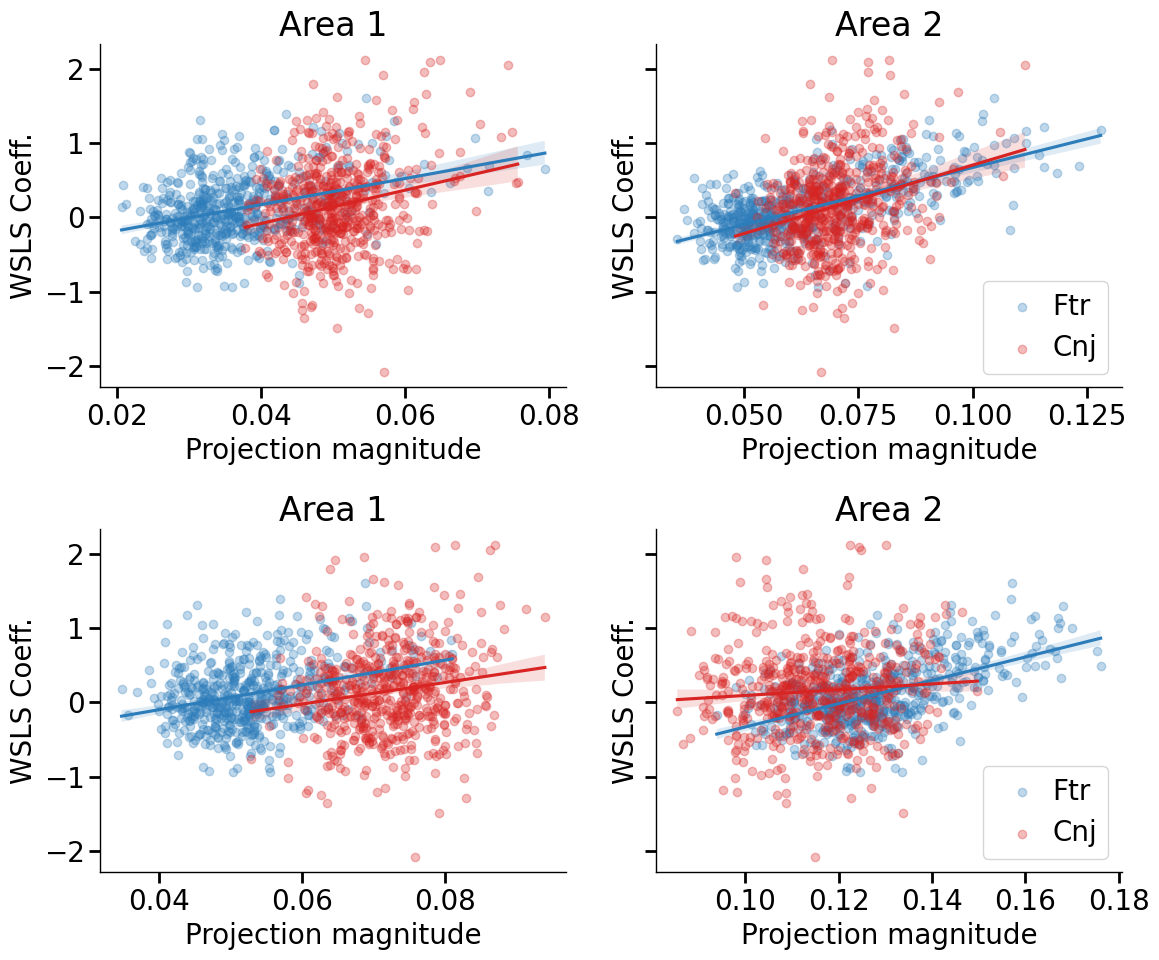

In [91]:
yyy = all_run_coeffs

ind_groups = [[0,1,2], [3,4,5]]

colors = [mpl.colormaps['Blues'](180), 
          mpl.colormaps['Reds'](180),
          mpl.colormaps['Purples'](180)]

labels = ["Ftr", "Cnj", "Obj"]

fig, axes = plt.subplots(2,2, figsize=(12, 10), sharex=False, sharey=True)

for group_idx, ind_groups in enumerate(ind_groups):
    xxx = all_sess_choice_proj_stim_ch.mean(0)
    sns.regplot(x=xxx[:,ind_groups].flatten(), y=yyy[:,ind_groups].flatten(),
               color=colors[group_idx], 
               scatter_kws={'alpha': 0.3, 'facecolor': colors[group_idx]*np.array([1,1,1,0.1]), 
                            'edgecolor': colors[group_idx]*np.array([1,1,1,0.]),
                           'linewidths': 1}, 
               label=labels[group_idx],
               ax = axes[0,0])
    print(stats.spearmanr(xxx[:,ind_groups].flatten(), yyy[:,ind_groups].flatten()))
    
    xxx = all_sess_choice_proj_choice_ch.mean(0)
    sns.regplot(x=xxx[:,ind_groups].flatten(), y=yyy[:,ind_groups].flatten(),
               color=colors[group_idx], 
               scatter_kws={'alpha': 0.3, 'facecolor': colors[group_idx]*np.array([1,1,1,0.1]), 
                            'edgecolor': colors[group_idx]*np.array([1,1,1,0.]),
                           'linewidths': 1}, 
               label=labels[group_idx],
               ax = axes[0,1])
    print(stats.spearmanr(xxx[:,ind_groups].flatten(), yyy[:,ind_groups].flatten()))

    xxx = all_sess_choice_proj_stim_lrn.mean(0)
    sns.regplot(x=xxx[:,ind_groups].flatten(), y=yyy[:,ind_groups].flatten(),
               color=colors[group_idx], 
               scatter_kws={'alpha': 0.3, 'facecolor': colors[group_idx]*np.array([1,1,1,0.1]), 
                            'edgecolor': colors[group_idx]*np.array([1,1,1,0.]),
                           'linewidths': 1}, 
               label=labels[group_idx],
               ax = axes[1,0])
    print(stats.spearmanr(xxx[:,ind_groups].flatten(), yyy[:,ind_groups].flatten()))
    
    xxx = all_sess_choice_proj_choice_lrn.mean(0)
    sns.regplot(x=xxx[:,ind_groups].flatten(), y=yyy[:,ind_groups].flatten(),
               color=colors[group_idx], 
               scatter_kws={'alpha': 0.3, 'facecolor': colors[group_idx]*np.array([1,1,1,0.1]), 
                            'edgecolor': colors[group_idx]*np.array([1,1,1,0.]),
                           'linewidths': 1}, 
               label=labels[group_idx],
               ax = axes[1,1])
    print(stats.spearmanr(xxx[:,ind_groups].flatten(), yyy[:,ind_groups].flatten()))
    
for i in range(2):
    for j in range(2):
        axes[i,j].set_xlabel('Projection magnitude')
        axes[i,j].set_ylabel('WSLS Coeff.')
        
axes[0,1].legend(columnspacing=0.2, handletextpad=0.1, ncols=1, frameon=True)
axes[1,1].legend(columnspacing=0.2, handletextpad=0.1, ncols=1, frameon=True)

for i in range(2):
    axes[i,0].set_title('Area 1')
    axes[i,1].set_title('Area 2')

sns.despine()
fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/subspace_proj_behav_corr.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/subspace_proj_behav_corr.pdf')



In [168]:
def plot_hs_exp_var_dynamic_by_timestep(all_model_dpca, all_sess_hs, all_sess_chosen, all_sess_foregone,
                                        all_sess_model_assignment, all_sess_dim_order_reverse, task_mdprl,
                                        ax):

    all_sess_choice_proj = []
    all_sess_exp_var = []
    
    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']
    
    for sess_idx in tqdm.tqdm(range(192)):
        
#         if (all_sess_model_assignment[sess_idx]!=2):
#             continue
        
        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]

        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3, [6]])
    
        curr_sess_dpca_psth = all_model_dpca['marginalized_psth'][all_sess_model_assignment[sess_idx]]
        curr_sess_encoding_axes = all_model_dpca['encoding_axes'][all_sess_model_assignment[sess_idx]]
        
        num_trials = len(all_sess_chosen)
        num_timesteps = all_sess_hs.shape[1]
        
        curr_sess_choice_proj = np.zeros((num_trials,num_timesteps,7))
        curr_sess_exp_var = np.zeros((num_trials,num_timesteps,7))
        
        curr_sess_better = np.empty_like(all_sess_chosen[...,sess_idx])*np.nan
        curr_sess_worse = np.empty_like(all_sess_chosen[...,sess_idx])*np.nan

#         curr_sess_correct = all_saved_states['choose_better'][...,sess_idx]
        curr_sess_chosen = all_sess_chosen[...,sess_idx].long()
        curr_sess_foregone = all_sess_foregone[...,sess_idx].long()
                
#         curr_sess_better[curr_sess_correct>0.5] = curr_sess_chosen[curr_sess_correct>0.5]
#         curr_sess_better[curr_sess_correct<0.5] = curr_sess_foregone[curr_sess_correct<0.5]
#         curr_sess_better = curr_sess_better.astype(int)
        
#         curr_sess_worse[curr_sess_correct>0.5] = curr_sess_foregone[curr_sess_correct>0.5]
#         curr_sess_worse[curr_sess_correct<0.5] = curr_sess_chosen[curr_sess_correct<0.5]
#         curr_sess_worse = curr_sess_worse.astype(int)
        
        stim_chosen_FCO = obj_to_ft_conj(curr_sess_chosen, task_mdprl).squeeze()
#         stim_chosen_FCO = obj_to_ft_conj(curr_sess_better, task_mdprl).squeeze()
        stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]

        stim_foregone_FCO = obj_to_ft_conj(curr_sess_foregone, task_mdprl).squeeze()
#         stim_foregone_FCO = obj_to_ft_conj(curr_sess_worse, task_mdprl).squeeze()
        stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
        
        curr_sess_hs = all_sess_hs[:, :, sess_idx, :].detach().numpy().copy()
#         curr_sess_hs -= curr_sess_hs.mean(-1, keepdims=True)
        
        for k_idx, k_name in enumerate(permutted_key_order):
                        
            curr_sess_dim_psth = curr_sess_dpca_psth[k_name].squeeze()[:].reshape((args['hidden_size'], -1))
            
            chosen_direction = curr_sess_dim_psth[:,stim_chosen_FCO[:,k_idx]]
#             chosen_direction = chosen_direction/np.linalg.norm(chosen_direction, axis=0, keepdims=True)
            foregone_direction = curr_sess_dim_psth[:,stim_foregone_FCO[:,k_idx]]            
#             foregone_direction = foregone_direction/np.linalg.norm(foregone_direction, axis=0, keepdims=True)
            choice_direction = (chosen_direction-foregone_direction)
            choice_direction = choice_direction/(np.linalg.norm(choice_direction, axis=0, keepdims=True)+1e-6)
            choice_direction = choice_direction.T[:,None]
            
            h_choice_proj = (curr_sess_hs*choice_direction).sum(-1)
            h_reparam = (curr_sess_hs@curr_sess_encoding_axes[k_name])
                        
            curr_sess_choice_proj[:,:,k_idx] = np.abs(h_choice_proj)/(np.linalg.norm(curr_sess_hs, axis=-1)+1e-6)
            curr_sess_exp_var[:,:,k_idx] = (h_reparam**2).sum(-1)/(np.linalg.norm(curr_sess_hs, axis=-1)**2+1e-6)

        all_sess_choice_proj.append(curr_sess_choice_proj)
        all_sess_exp_var.append(curr_sess_exp_var)
        
    all_sess_choice_proj = np.stack(all_sess_choice_proj, 1)
    all_sess_exp_var = np.stack(all_sess_exp_var, 1)
    
    colormap = np.concatenate([mpl.colormaps['Blues']([180, 100, 50]), 
                       mpl.colormaps['Reds']([180, 100, 50]), 
                       mpl.colormaps['Purples']([180])])
    
    for idx_k in range(7):
        
#         smth_exp_var = np.stack([
#             np.convolve(all_sess_choice_proj[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
#                 for idx_sess in range(all_sess_choice_proj.shape[1])], axis=1)
        
        plot_mean_and_std(ax=ax,
                      m=all_sess_choice_proj[:,:,:,idx_k].mean((0,1)), 
                      sd=all_sess_choice_proj[:,:,:,idx_k].mean(0).std(0)/np.sqrt(92), 
                      label=dim_labels[idx_k], 
                      color=colormap[idx_k])
        
#         ax.set_ylim([-ax.get_ylim()[1]*0.1, ax.get_ylim()[1]*1.])
#         ax.set_ylim([-0.1, 0.6])

        ax.axvline(task_mdprl.T_fixation-1, ls=':', color='lightgrey')
        ax.axvline(task_mdprl.T_stim+task_mdprl.T_fixation-1, ls=':', color='lightgrey')
        ax.axvline(task_mdprl.T_stim+task_mdprl.T_fixation+task_mdprl.T_ch-1, ls=':', color='lightgrey')
        
    
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [all_sess_choice_proj[...,0].mean(0), all_sess_choice_proj[...,1].mean(0), all_sess_choice_proj[...,2].mean(0)],
        n_permutations=1000,
        n_jobs=None,
        verbose=False,
    )
        
    sig_dot_y = ax.get_ylim()[0]-(ax.get_ylim()[1]-ax.get_ylim()[0])*0.1
    for (clus, clus_p) in zip(clusters, cluster_p_values):
        if clus_p<0.05:
            ax.scatter(clus, sig_dot_y*np.ones_like(clus), color='tab:blue', s=4)
    
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [all_sess_choice_proj[...,3].mean(0), all_sess_choice_proj[...,4].mean(0), all_sess_choice_proj[...,5].mean(0)],
        n_permutations=1000,
        n_jobs=None,
        verbose=False,
    )
        
    sig_dot_y *= 1.2
    for (clus, clus_p) in zip(clusters, cluster_p_values):
        if clus_p<0.05:
            ax.scatter(clus, sig_dot_y*np.ones_like(clus), color='tab:red', s=4)

        
    fig.tight_layout()
    
    return all_sess_choice_proj
    

100%|██████████| 192/192 [00:23<00:00,  8.34it/s]
/scratch/f005d7d/ipykernel_2602013/1570831937.py:110: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/f005d7d/ipykernel_2602013/1570831937.py:122: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| 192/192 [00:18<00:00, 10.36it/s]
/scratch/f005d7d/ipykernel_2602013/1570831937.py:110: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/f005d7d/ipykernel_2602013/1570831937.py:122: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Figure saved at plots/exp/test1/subspace_proj_timecourse.pdf


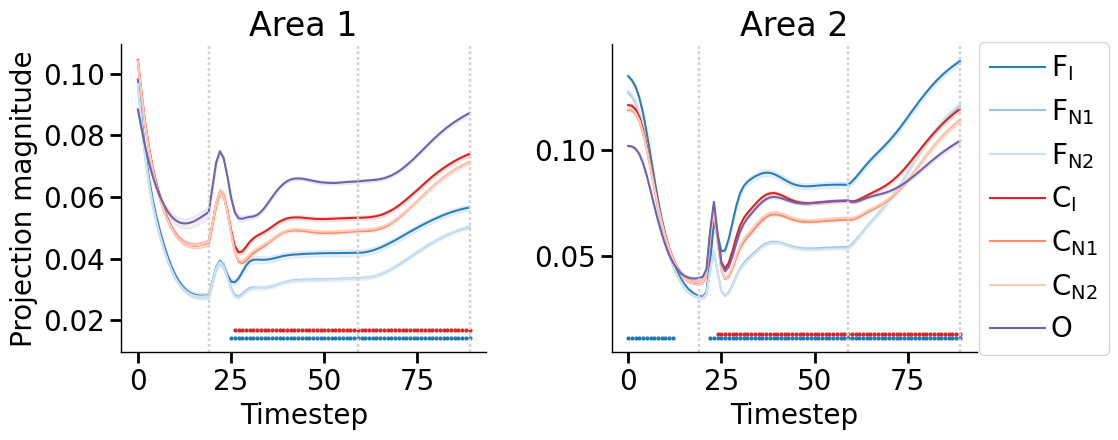

In [178]:
fig, axes = plt.subplots(1,2, figsize=(12,4.8), sharex=True)


_ = plot_hs_exp_var_dynamic_by_timestep(all_model_dpca_stim_in, all_saved_states['hs'][...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[0])

_ = plot_hs_exp_var_dynamic_by_timestep(all_model_dpca_choice_out, all_saved_states['hs'][...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[1])

# _ = plot_hs_exp_var_dynamic_by_timestep(all_model_dpca_choice_in, all_saved_states['hs'][...,output_weight_inds], 
#                             all_saved_states['choices'], all_saved_states['foregone'], 
#                             all_saved_states['model_assignment'], 
#                             all_saved_states['test_stim_dim_order'],
#                             task_mdprl, axes[2])


axes[0].set_title('Area 1')
axes[1].set_title('Area 2')

axes[0].set_xlabel('Timestep')
axes[1].set_xlabel('Timestep')

axes[0].set_ylabel('Projection magnitude')
# axes[1].set_ylabel('Projection magnitude')

axes[1].legend(loc='right', bbox_to_anchor=(1.4, 0.5), 
               columnspacing=1, handletextpad=0.2, ncols=1, frameon=True)

sns.despine()
plt.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/subspace_proj_timecourse.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/subspace_proj_timecourse.pdf')
    